<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/3.%205Q%20TFIM%20VQNHE%20QEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

In [ ]:
from functools import cache

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

# Hamiltonian Diagonalization

$$ H = Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [ ]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

# 1. Error Rate Estimation (Baseline)

## Depolarization Channel, Error 0.001~0.1, Shots = 100000, Hidden Layer 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

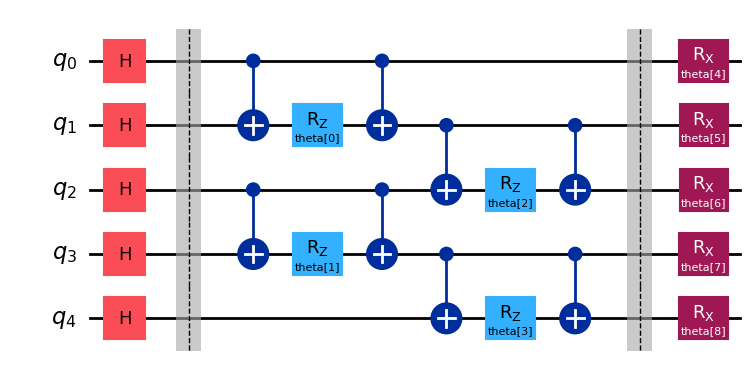

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

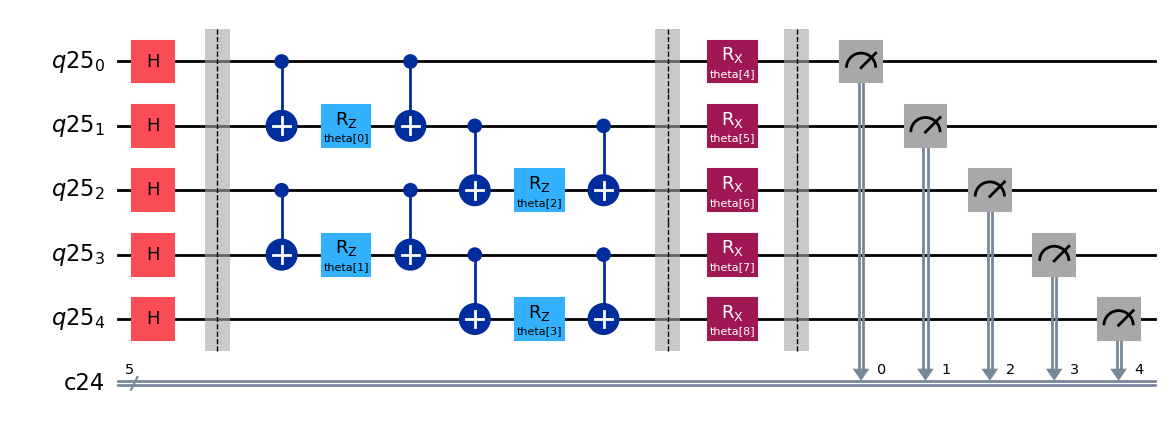

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

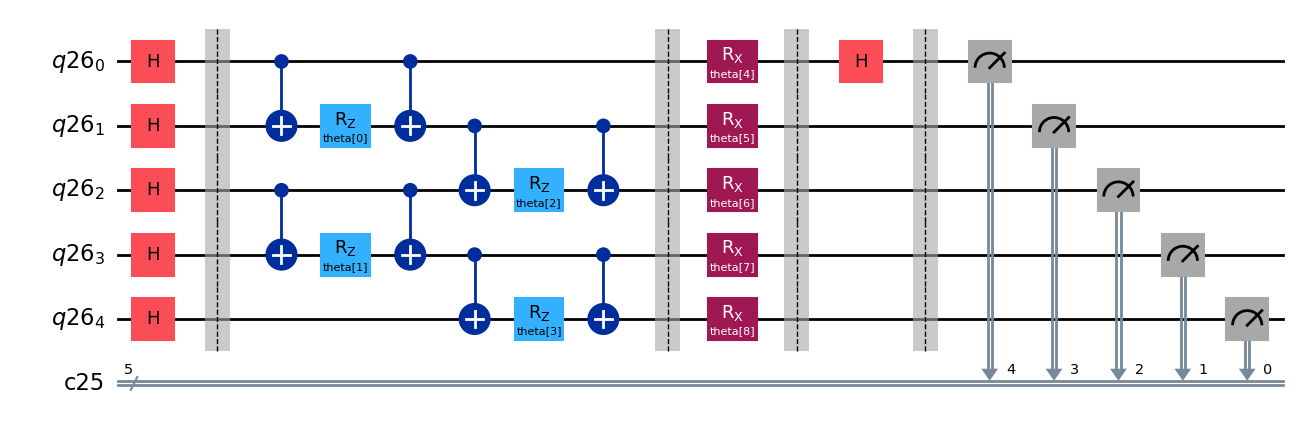

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

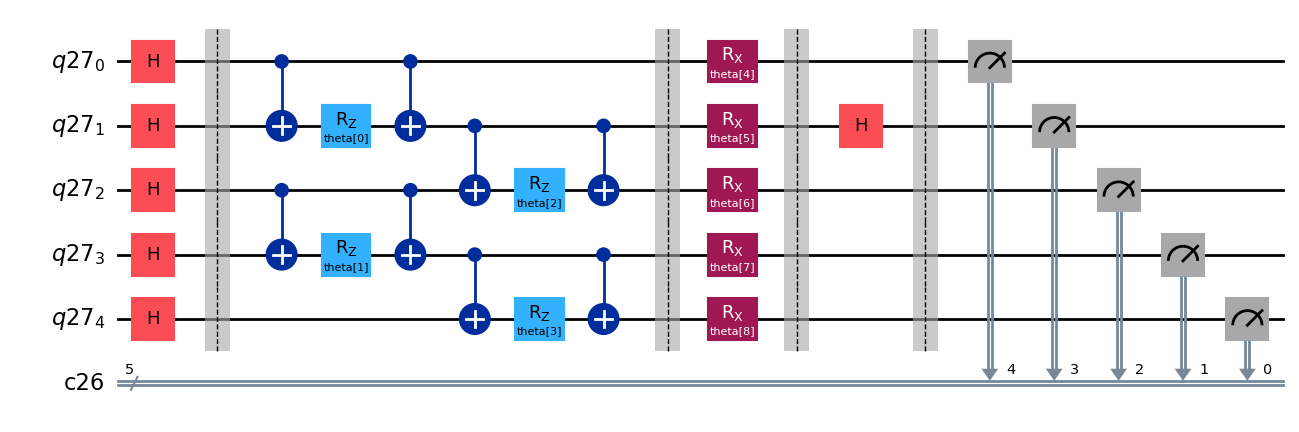

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

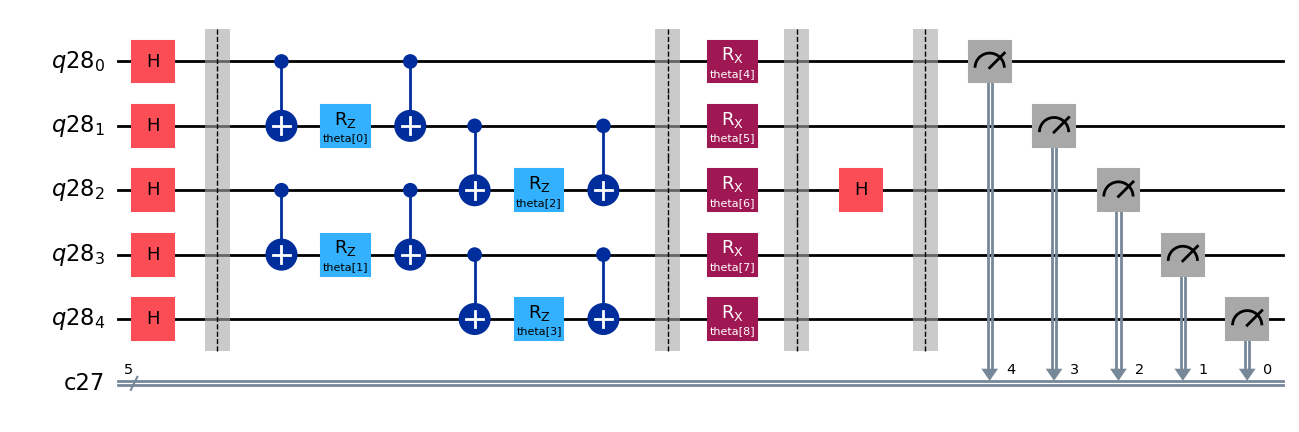

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

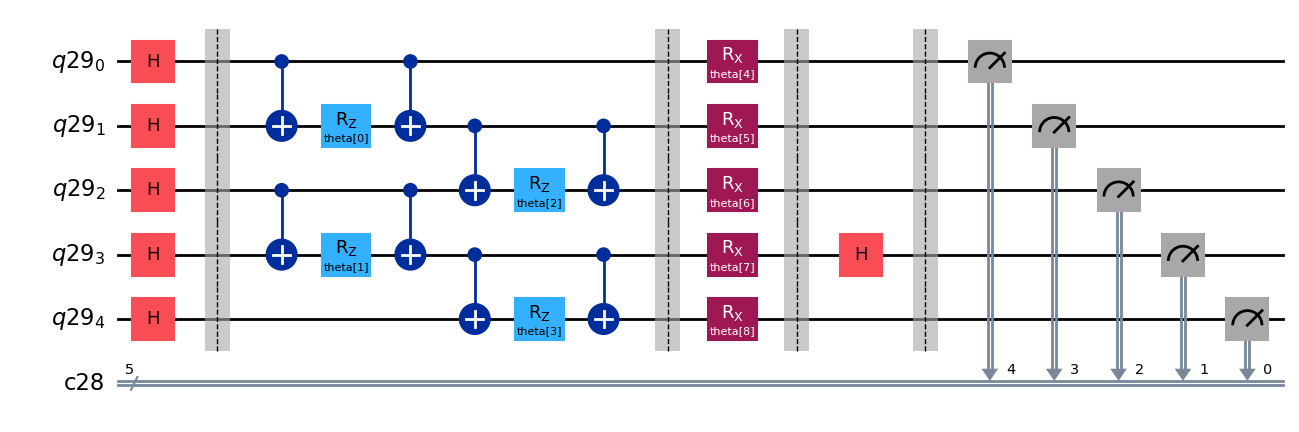

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

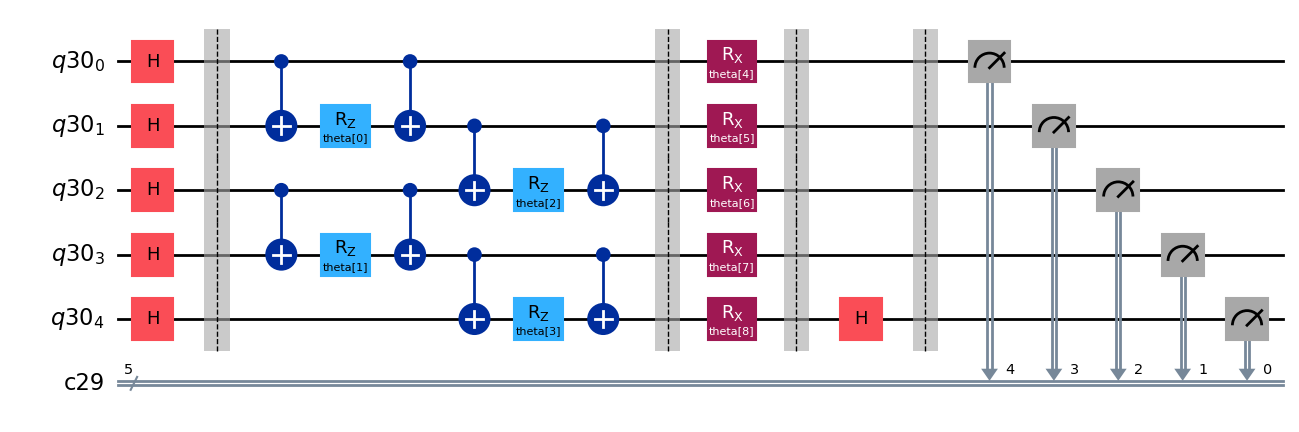

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005198
         Iterations: 100
         Function evaluations: 5824
         Gradient evaluations: 112
         Current function value: -6.001280
         Iterations: 100
         Function evaluations: 7020
         Gradient evaluations: 135
         Current function value: -5.917861
         Iterations: 100
         Function evaluations: 8268
         Gradient evaluations: 159
         Current function value: -6.006155
         Iterations: 100
         Function evaluations: 6084
         Gradient evaluations: 117
         Current function value: -6.000713
         Iterations: 100
         Function evaluations: 5928
         Gradient evaluations: 114
         Current function value: -6.005823
         Iterations: 100
         Function evaluations: 8788
         Gradient evaluations: 169
         Current function value: -5.998328
         Iterations: 100
         Function evaluations: 6916
         Gradient evaluations: 133
         Current function v

In [ ]:
lowest_energy_vqnhe_list

# 2. Shot Error & Intrinsic Error Estimation

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, Hidden Layer 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

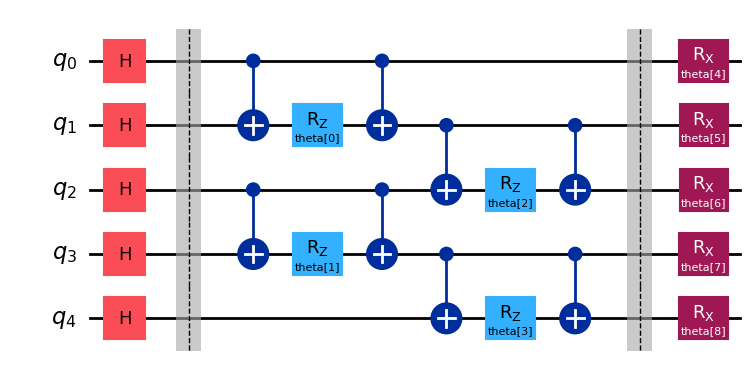

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

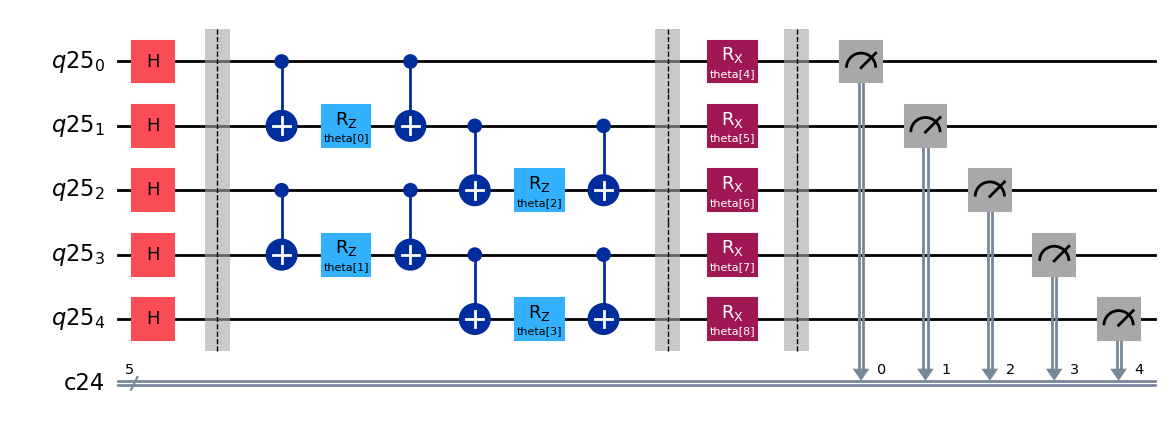

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

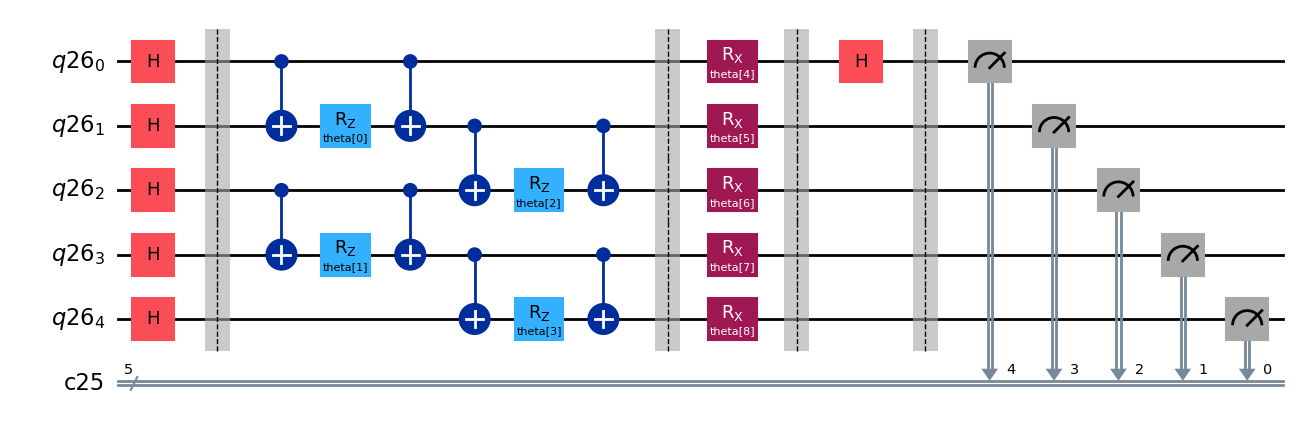

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

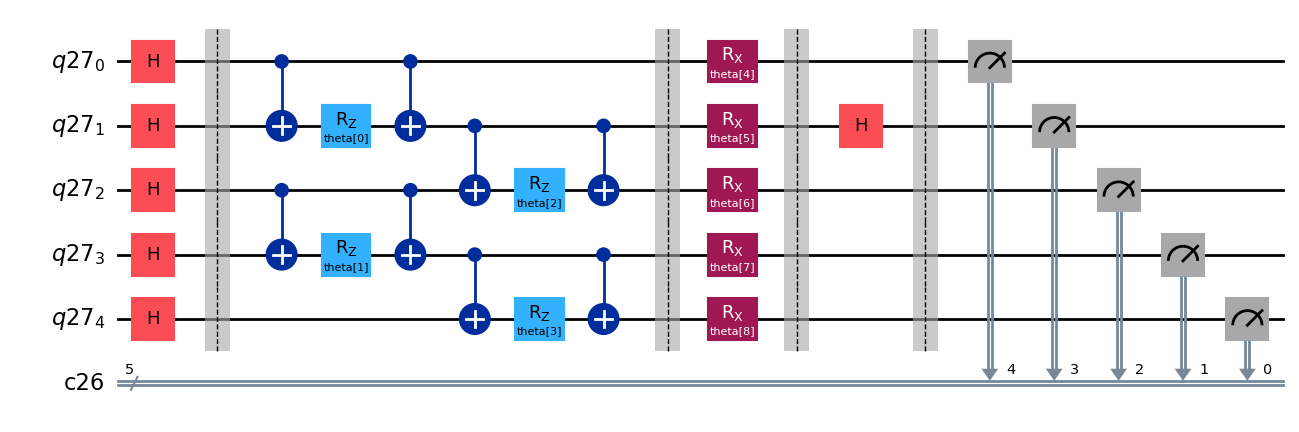

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

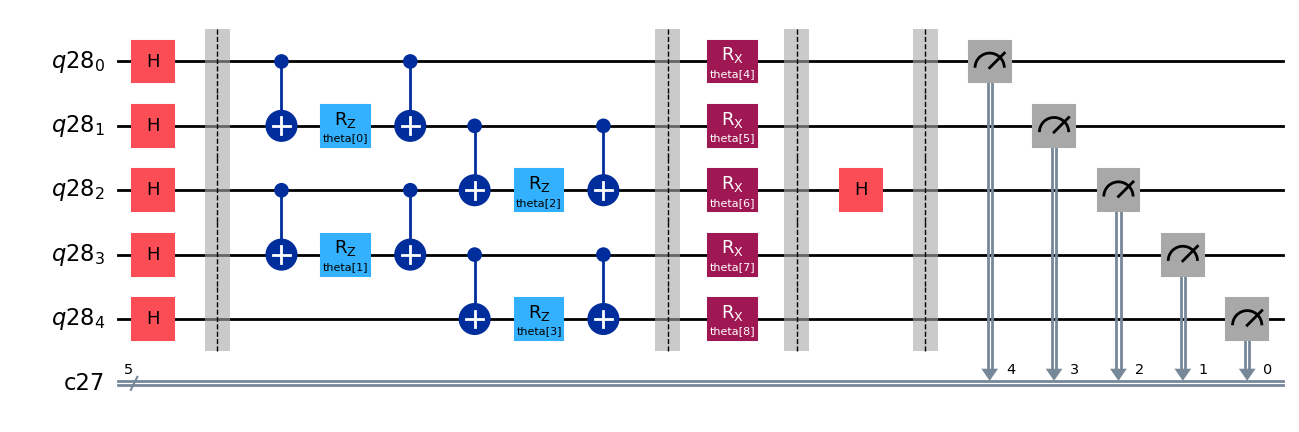

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

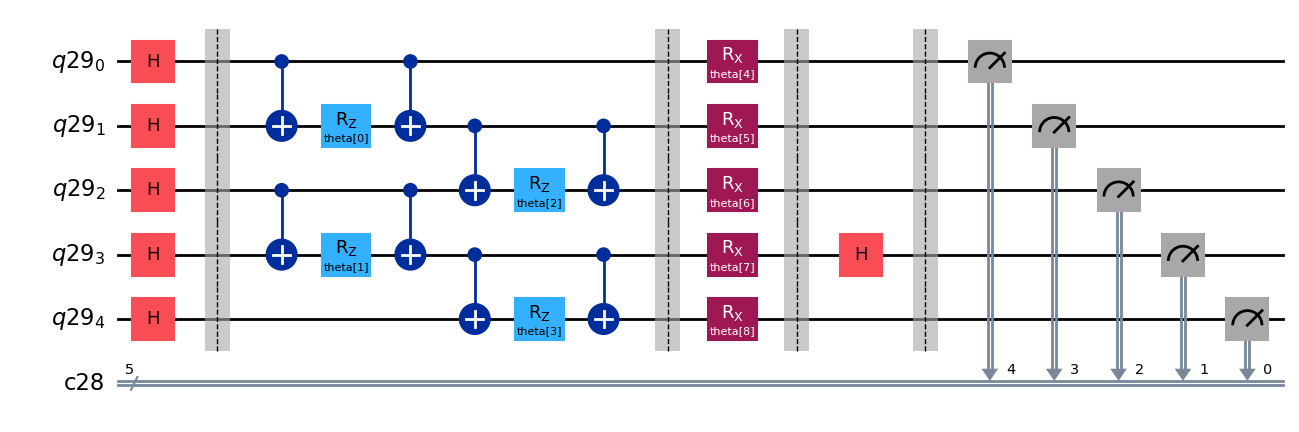

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

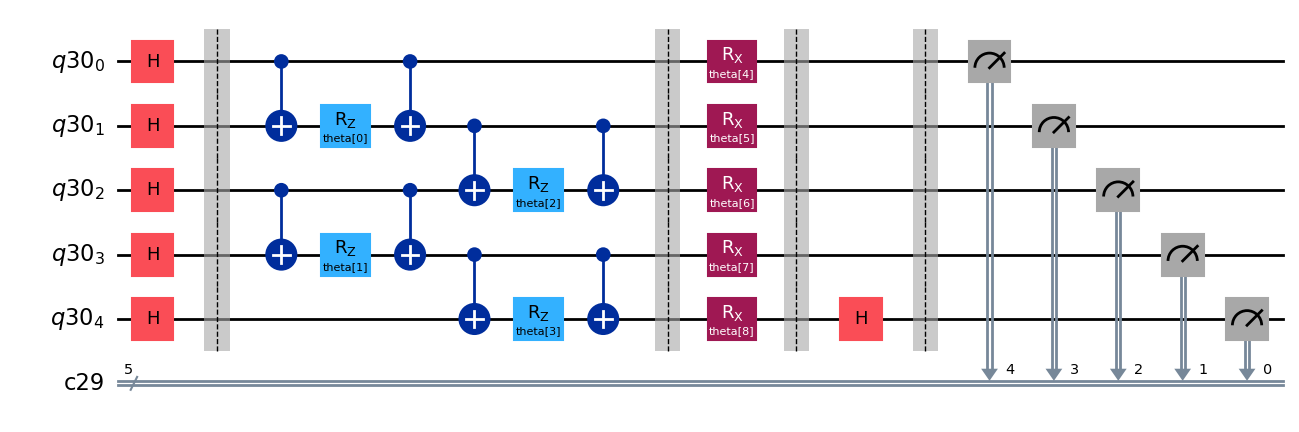

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005198
         Iterations: 100
         Function evaluations: 5824
         Gradient evaluations: 112
         Current function value: -6.001280
         Iterations: 100
         Function evaluations: 7020
         Gradient evaluations: 135
         Current function value: -5.917861
         Iterations: 100
         Function evaluations: 8268
         Gradient evaluations: 159
         Current function value: -6.006155
         Iterations: 100
         Function evaluations: 6084
         Gradient evaluations: 117
         Current function value: -6.000713
         Iterations: 100
         Function evaluations: 5928
         Gradient evaluations: 114
         Current function value: -6.005823
         Iterations: 100
         Function evaluations: 8788
         Gradient evaluations: 169
         Current function value: -5.998328
         Iterations: 100
         Function evaluations: 6916
         Gradient evaluations: 133
         Current function v

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.855328
         Iterations: 52
         Function evaluations: 5410
         Gradient evaluations: 104


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977617
         Iterations: 100
         Function evaluations: 7696
         Gradient evaluations: 148
         Current function value: -5.975694
         Iterations: 100
         Function evaluations: 6188
         Gradient evaluations: 119
         Current function value: -5.916544
         Iterations: 100
         Function evaluations: 5668
         Gradient evaluations: 109
         Current function value: -5.966396
         Iterations: 100
         Function evaluations: 6188
         Gradient evaluations: 119
error rate : 0.001, lowest energy vqnhe : -5.987551193726036



error rate : 0.002, lowest energy vqe : -5.775000000000001

         Current function value: -5.935745
         Iterations: 100
         Function evaluations: 6084
         Gradient evaluations: 117
         Current function value: -5.990799
         Iterations: 100
         Function evaluations: 6032
         Gradient evaluations: 116


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978450
         Iterations: 97
         Function evaluations: 12380
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005695
         Iterations: 100
         Function evaluations: 6760
         Gradient evaluations: 130
         Current function value: -5.826994
         Iterations: 100
         Function evaluations: 7696
         Gradient evaluations: 148
         Current function value: -5.978973
         Iterations: 100
         Function evaluations: 6812
         Gradient evaluations: 131
         Current function value: -5.978033
         Iterations: 100
         Function evaluations: 5564
         Gradient evaluations: 107
         Current function value: -5.992350
         Iterations: 100
         Function evaluations: 8476
         Gradient evaluations: 163
         Current function value: -5.990047
         Iterations: 100
         Function evaluations: 9256
         Gradient evaluations: 178
         Current function value: -6.002335
         Iterations: 100
         Function evaluations: 6032
         Gradient evaluations: 116
error rate : 0.002, lowest 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.870899
         Iterations: 85
         Function evaluations: 7020
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.947427
         Iterations: 100
         Function evaluations: 6084
         Gradient evaluations: 117
         Current function value: -5.938008
         Iterations: 100
         Function evaluations: 6032
         Gradient evaluations: 116
         Current function value: -5.950582
         Iterations: 100
         Function evaluations: 5980
         Gradient evaluations: 115
         Current function value: -5.928583
         Iterations: 100
         Function evaluations: 6344
         Gradient evaluations: 122
         Current function value: -5.923434
         Iterations: 100
         Function evaluations: 5668
         Gradient evaluations: 109
         Current function value: -5.941791
         Iterations: 100
         Function evaluations: 5928
         Gradient evaluations: 114
         Current function value: -5.956373
         Iterations: 100
         Function evaluations: 5720
         Gradient evaluations: 110
         Current function v

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.905886
         Iterations: 92
         Function evaluations: 8436
         Gradient evaluations: 162


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.858805
         Iterations: 100
         Function evaluations: 8164
         Gradient evaluations: 157
         Current function value: -5.905987
         Iterations: 100
         Function evaluations: 6344
         Gradient evaluations: 122
         Current function value: -5.904107
         Iterations: 100
         Function evaluations: 6500
         Gradient evaluations: 125
         Current function value: -5.906884
         Iterations: 100
         Function evaluations: 6708
         Gradient evaluations: 129


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.883541
         Iterations: 99
         Function evaluations: 8332
         Gradient evaluations: 160


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.789575
         Iterations: 61
         Function evaluations: 6720
         Gradient evaluations: 129


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.841532
         Iterations: 100
         Function evaluations: 7488
         Gradient evaluations: 144
error rate : 0.004, lowest energy vqnhe : -5.906884458757285



error rate : 0.005, lowest energy vqe : -5.742000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986069
         Iterations: 92
         Function evaluations: 8592
         Gradient evaluations: 165


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985388
         Iterations: 100
         Function evaluations: 6136
         Gradient evaluations: 118


In [ ]:
lowest_energy_vqnhe_list

## Depolarization Channel, Error 0.001~0.1, Shots = 30000, Hidden Layer 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=30000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=30000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=30000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=30000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=30000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=30000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=30000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

## Depolarization Channel, Error 0.001~0.1, Shots = 100000, Hidden Layer 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

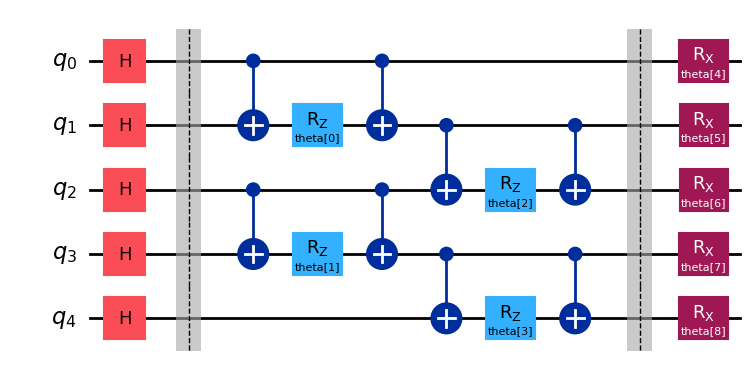

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

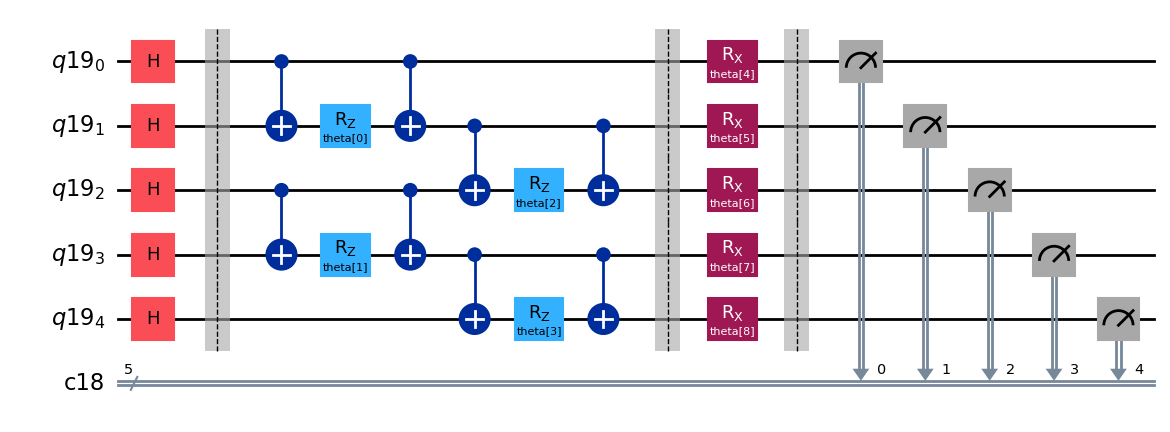

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

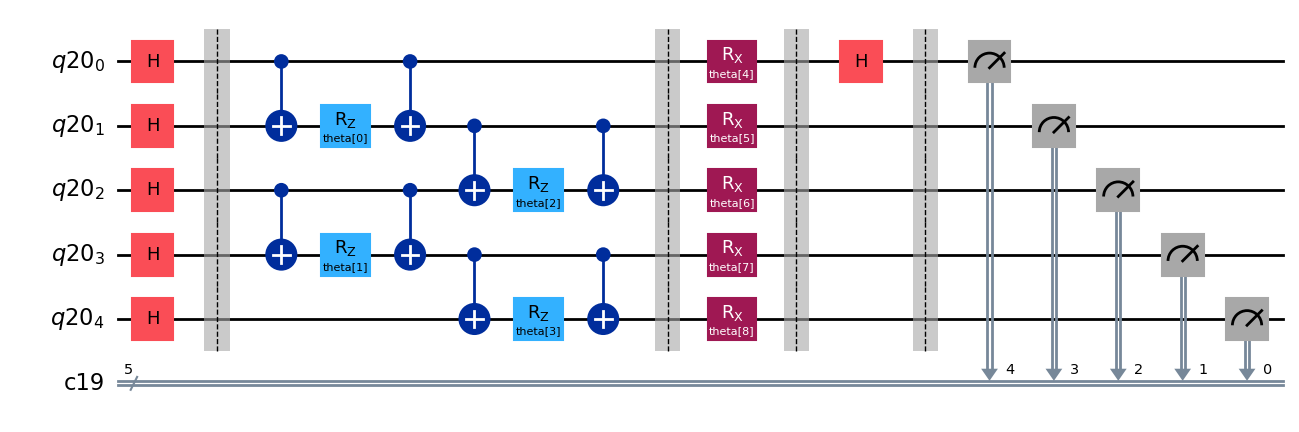

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

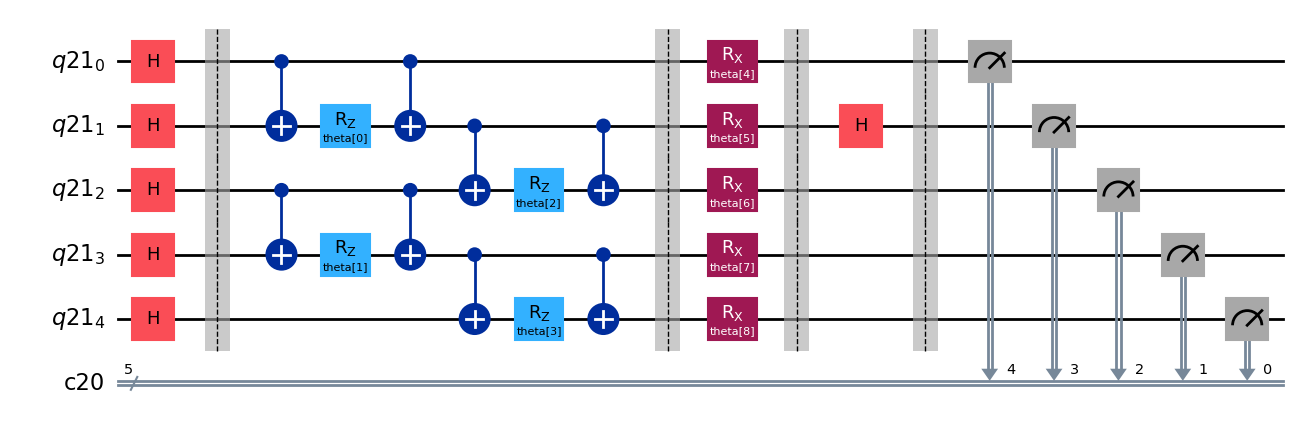

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

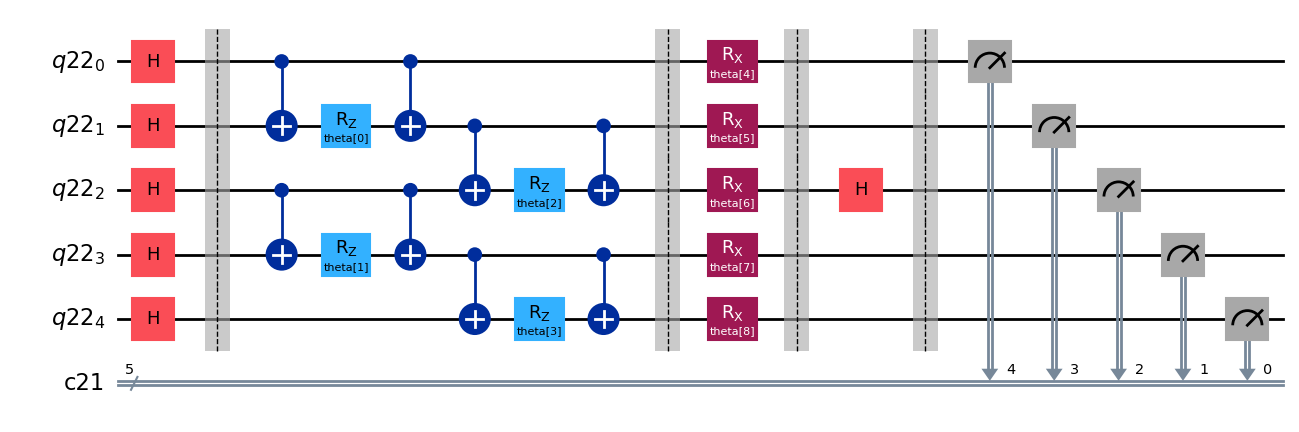

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

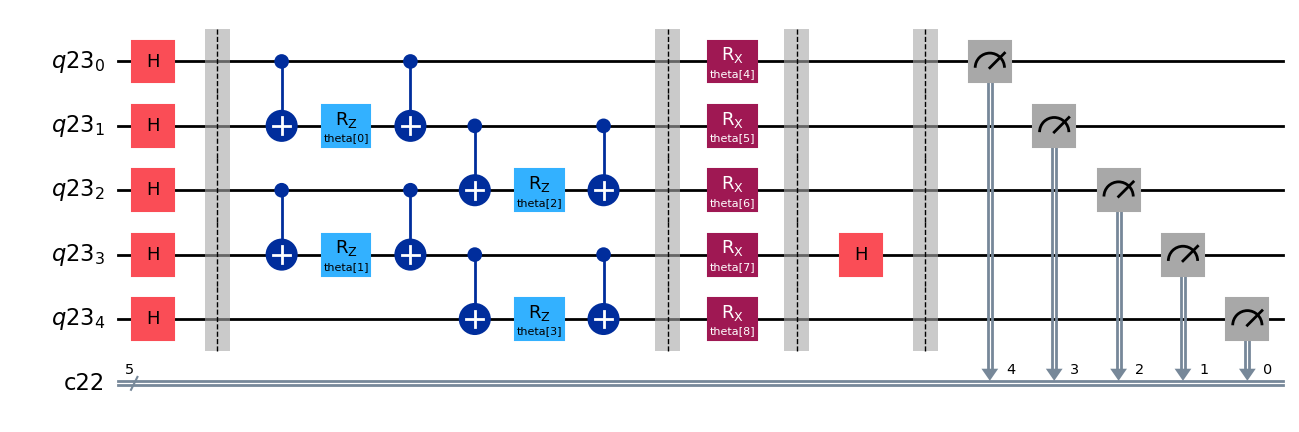

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

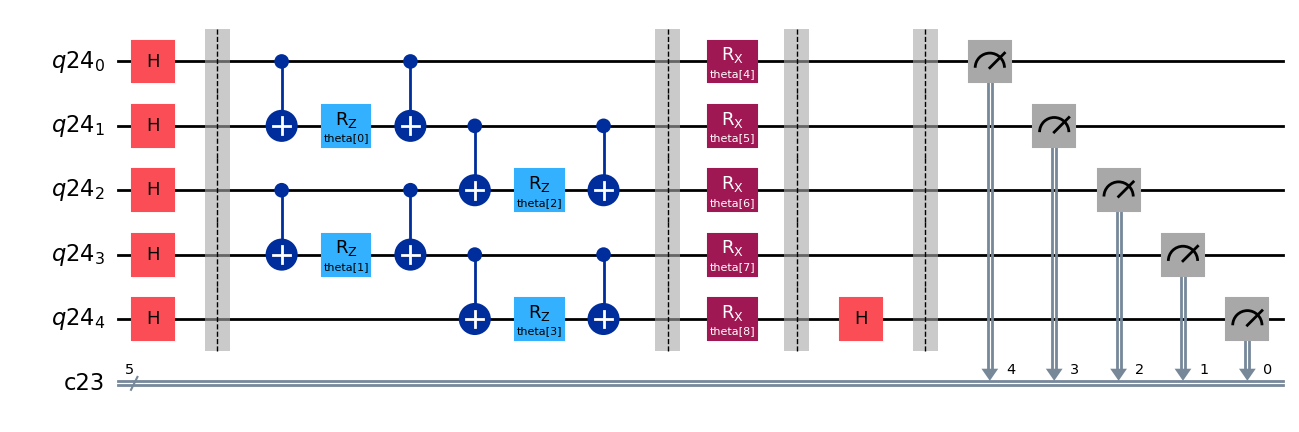

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002



In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

# 3. Error Type Estimation

## Depolarization Channel, Error 0.001~0.1, Shots = 100000, Hidden Layer 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

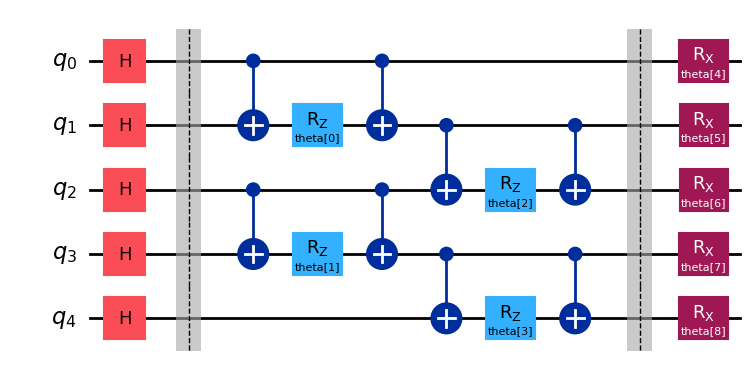

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

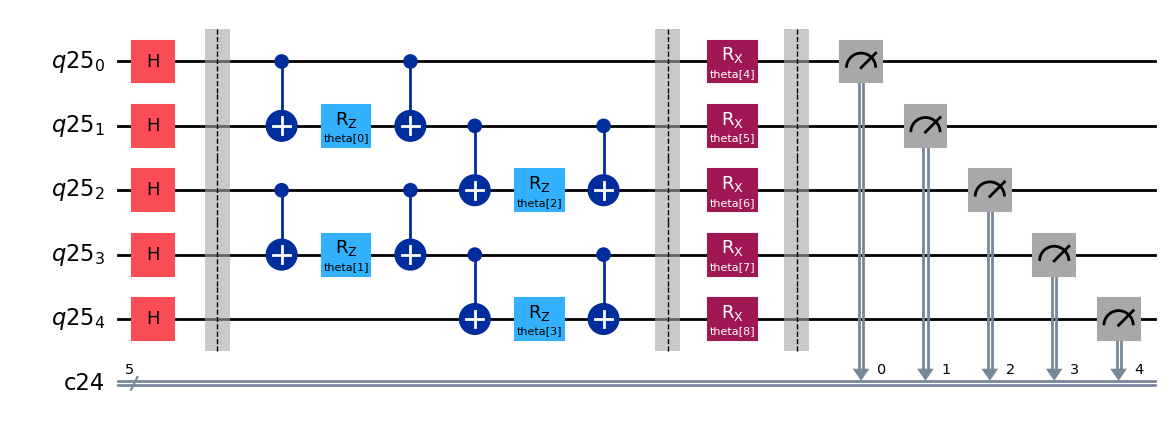

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

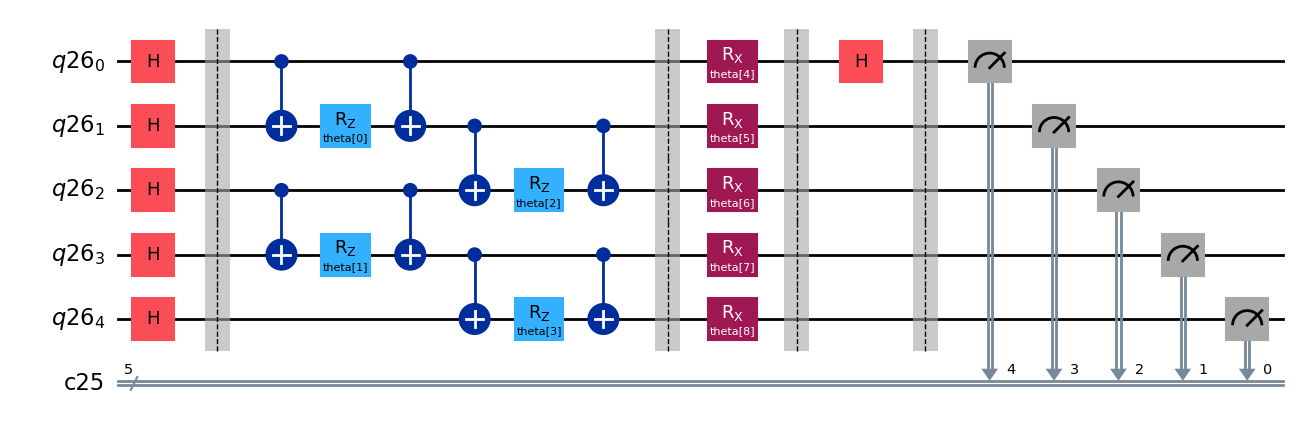

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

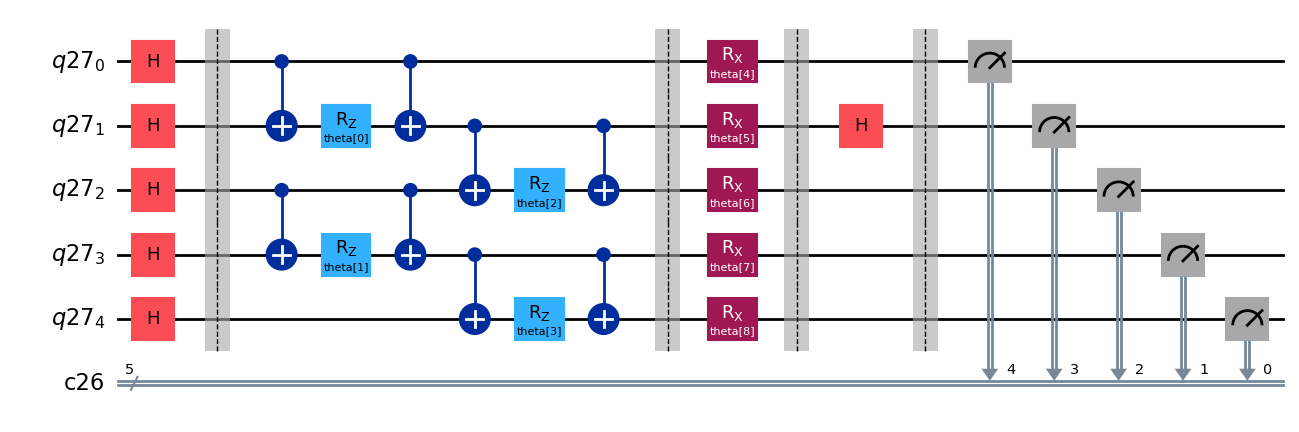

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

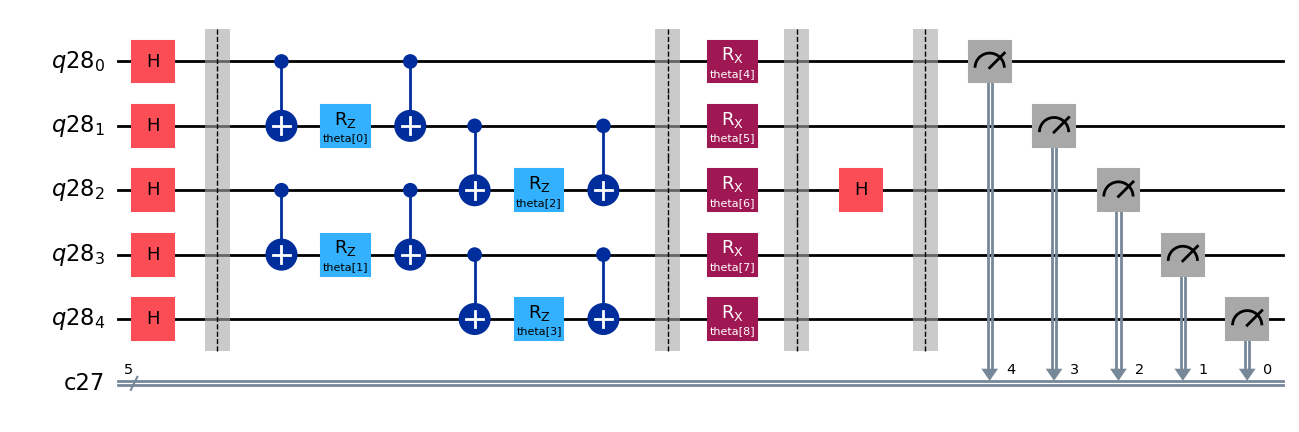

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

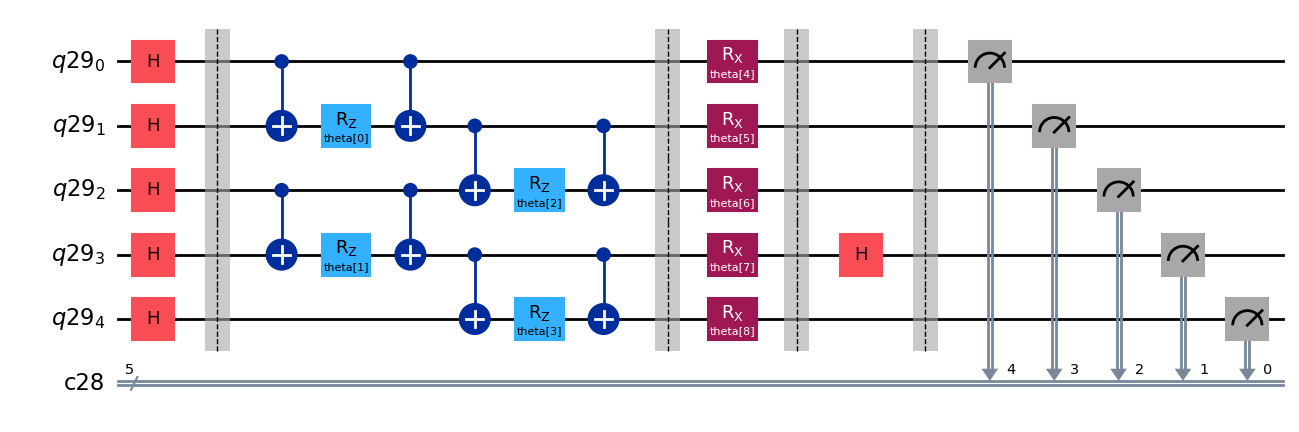

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

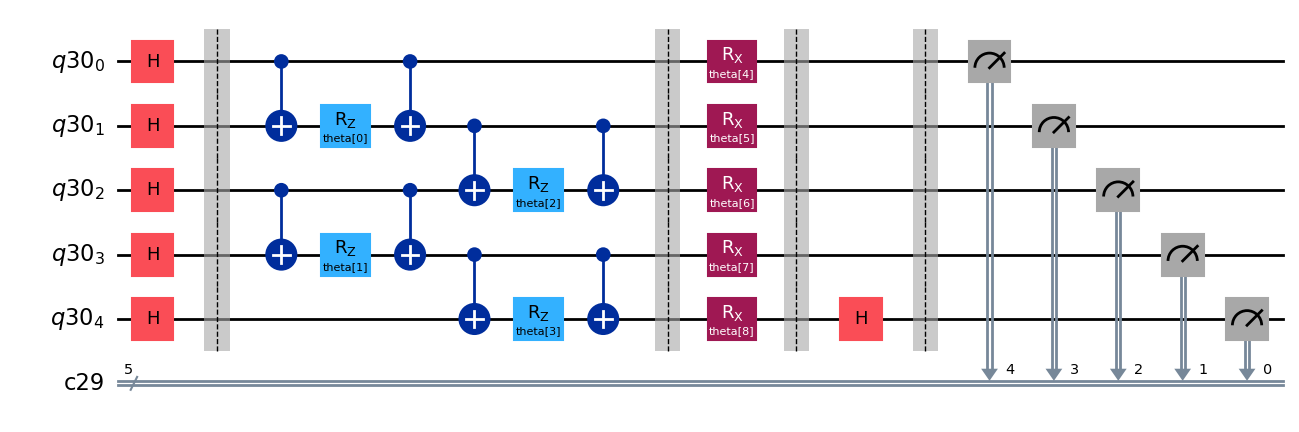

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005198
         Iterations: 100
         Function evaluations: 5824
         Gradient evaluations: 112
         Current function value: -6.001280
         Iterations: 100
         Function evaluations: 7020
         Gradient evaluations: 135
         Current function value: -5.917861
         Iterations: 100
         Function evaluations: 8268
         Gradient evaluations: 159
         Current function value: -6.006155
         Iterations: 100
         Function evaluations: 6084
         Gradient evaluations: 117
         Current function value: -6.000713
         Iterations: 100
         Function evaluations: 5928
         Gradient evaluations: 114
         Current function value: -6.005823
         Iterations: 100
         Function evaluations: 8788
         Gradient evaluations: 169
         Current function value: -5.998328
         Iterations: 100
         Function evaluations: 6916
         Gradient evaluations: 133
         Current function v

In [ ]:
lowest_energy_vqnhe_list

## Bit Flip Channel, Error 0.001~0.1, Shots = 100000, Hidden Layer 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

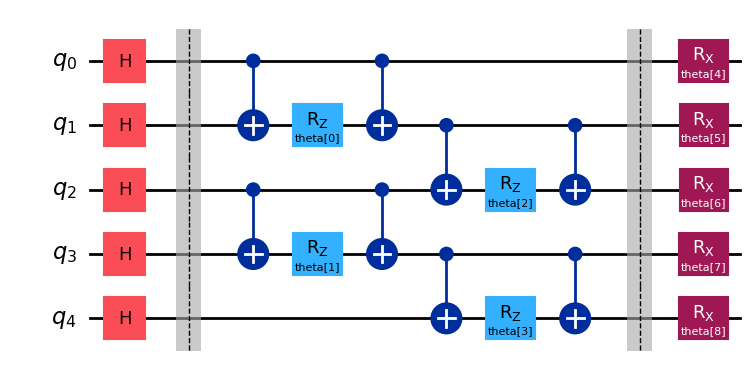

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

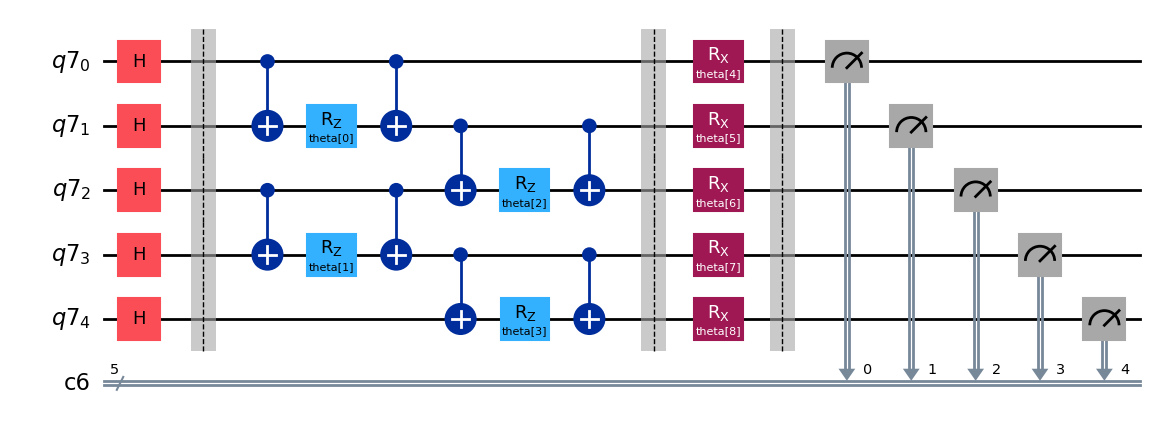

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

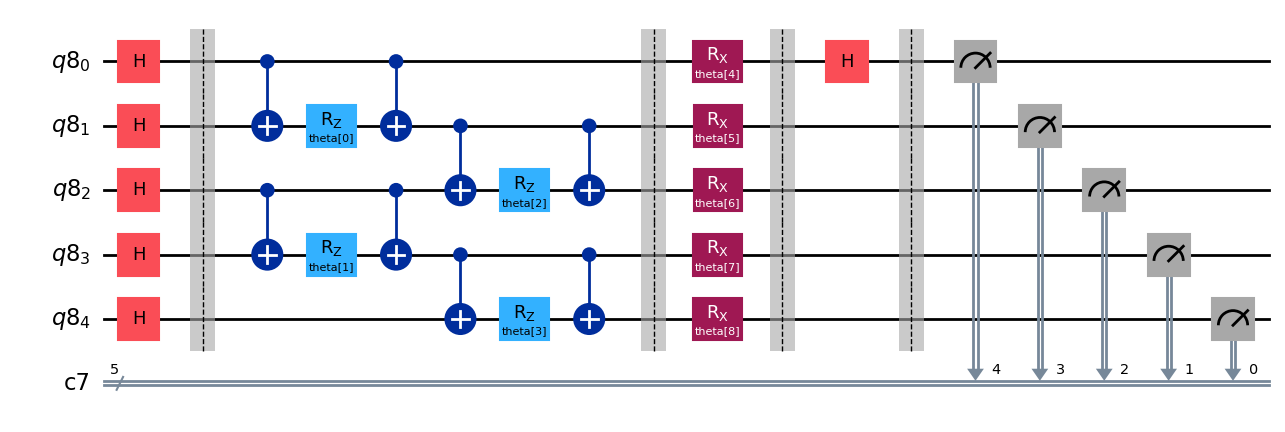

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

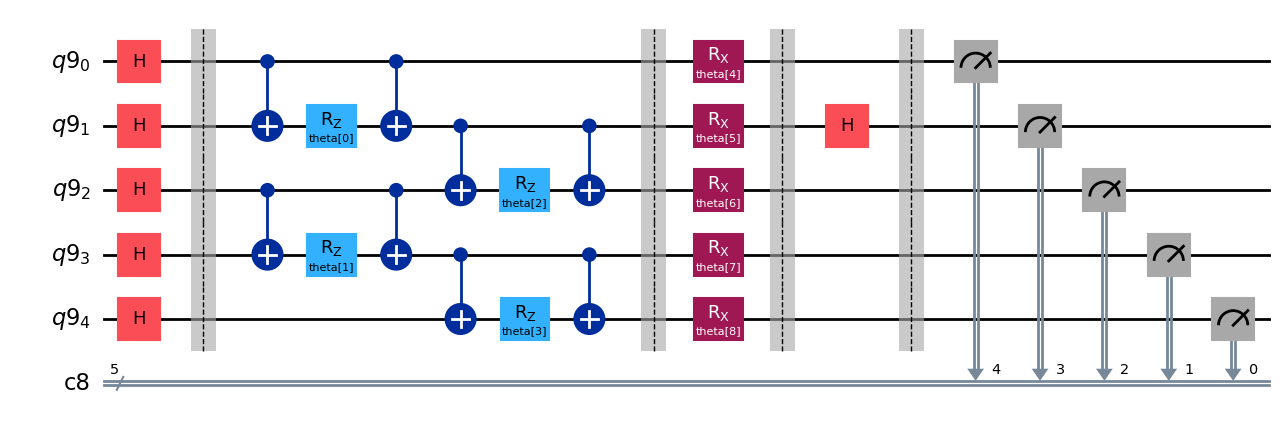

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

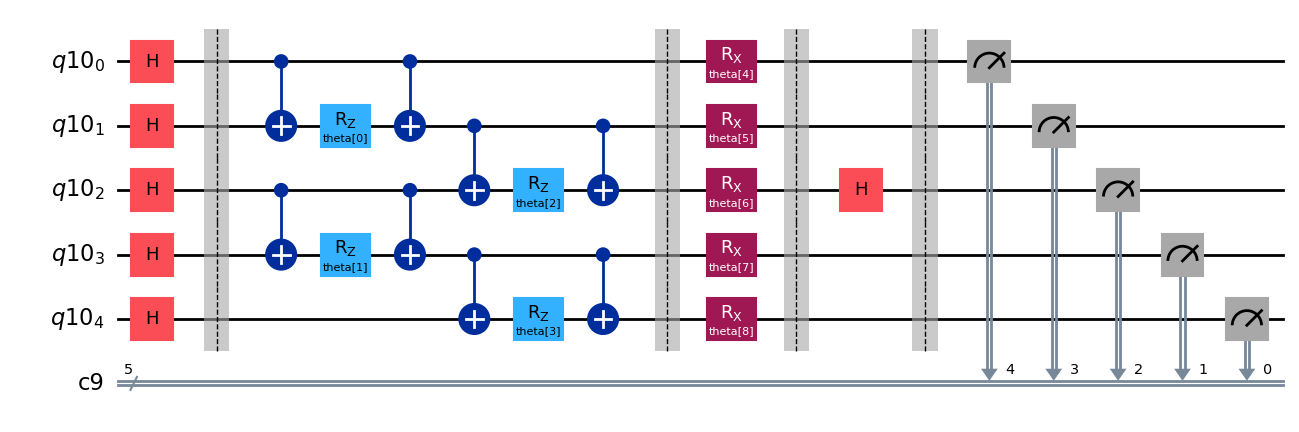

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

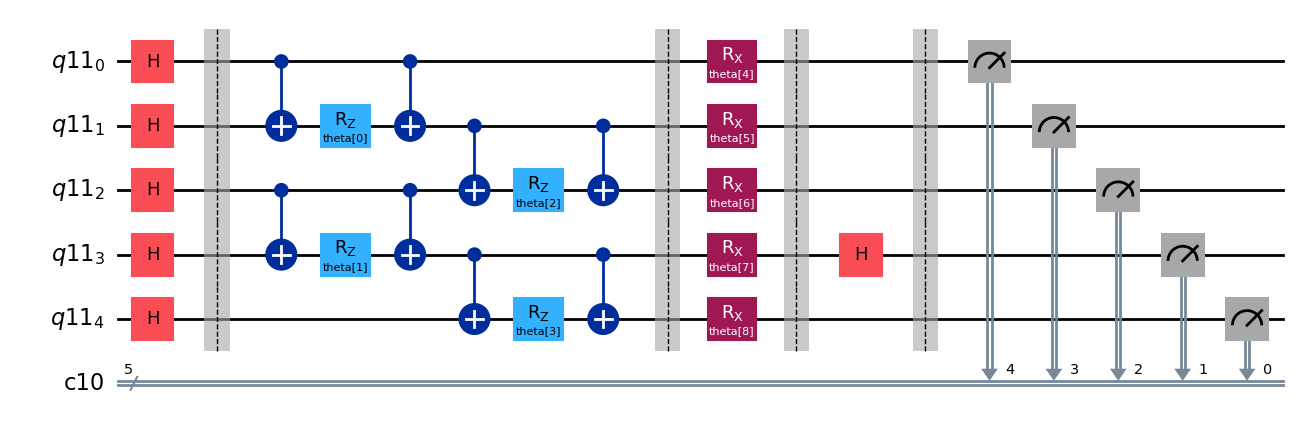

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

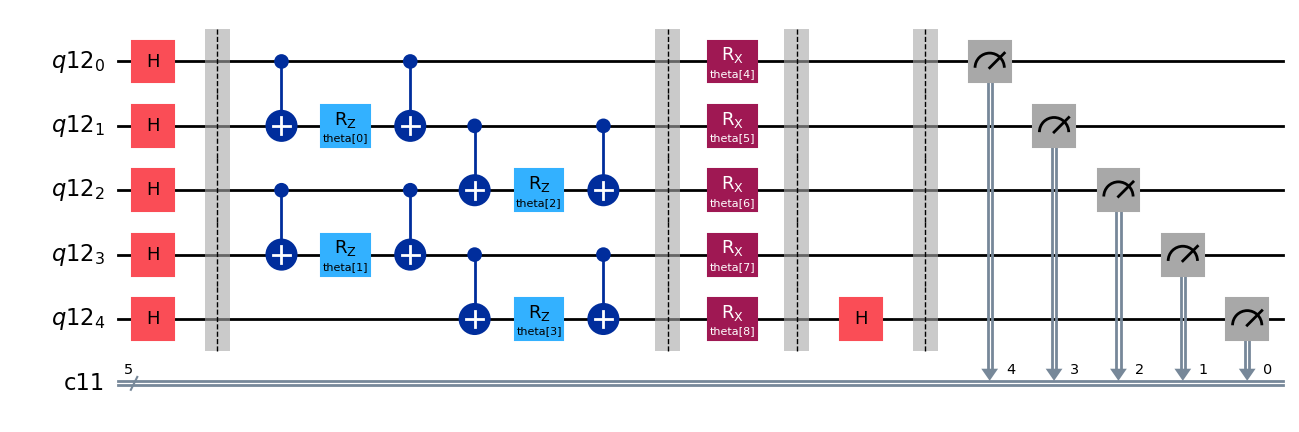

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.876600000000001

error rate : 0.001, lowest energy vqe : -5.878239999999999

error rate : 0.002, lowest energy vqe : -5.87098

error rate : 0.003, lowest energy vqe : -5.860439999999999

error rate : 0.004, lowest energy vqe : -5.8485000000000005

error rate : 0.005, lowest energy vqe : -5.8170600000000015

error rate : 0.006, lowest energy vqe : -5.824020000000002

error rate : 0.007, lowest energy vqe : -5.820760000000001

error rate : 0.008, lowest energy vqe : -5.8051200000000005

error rate : 0.009000000000000001, lowest energy vqe : -5.798660000000001

error rate : 0.01, lowest energy vqe : -5.77824

error rate : 0.02, lowest energy vqe : -5.684420000000001

error rate : 0.03, lowest energy vqe : -5.59114

error rate : 0.04, lowest energy vqe : -5.51376

error rate : 0.05, lowest energy vqe : -5.46274

error rate : 0.06, lowest energy vqe : -5.3962200000000005

error rate : 0.07, lowest energy vqe : -5.35034

error rate : 0.08, lowest ener

In [ ]:
lowest_energy_vqe_list

[-5.876600000000001,
 -5.878239999999999,
 -5.87098,
 -5.860439999999999,
 -5.8485000000000005,
 -5.8170600000000015,
 -5.824020000000002,
 -5.820760000000001,
 -5.8051200000000005,
 -5.798660000000001,
 -5.77824,
 -5.684420000000001,
 -5.59114,
 -5.51376,
 -5.46274,
 -5.3962200000000005,
 -5.35034,
 -5.310279999999999,
 -5.273199999999999,
 -5.24208]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.876600000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009719
         Iterations: 200
         Function evaluations: 15184
         Gradient evaluations: 292
         Current function value: -5.997993
         Iterations: 200
         Function evaluations: 17160
         Gradient evaluations: 330


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.948344
         Iterations: 194
         Function evaluations: 18783
         Gradient evaluations: 361


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983642
         Iterations: 168
         Function evaluations: 13109
         Gradient evaluations: 252


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.007646
         Iterations: 200
         Function evaluations: 13520
         Gradient evaluations: 260
         Current function value: -5.982173
         Iterations: 200
         Function evaluations: 13104
         Gradient evaluations: 252


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016802
         Iterations: 73
         Function evaluations: 9060
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015892
         Iterations: 200
         Function evaluations: 11232
         Gradient evaluations: 216


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000869
         Iterations: 131
         Function evaluations: 16600
         Gradient evaluations: 319


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005230
         Iterations: 200
         Function evaluations: 12168
         Gradient evaluations: 234


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004933
         Iterations: 94
         Function evaluations: 8384
         Gradient evaluations: 161


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005579
         Iterations: 200
         Function evaluations: 14404
         Gradient evaluations: 277
         Current function value: -6.013095
         Iterations: 200
         Function evaluations: 13676
         Gradient evaluations: 263
Optimization terminated successfully.
         Current function value: -5.946478
         Iterations: 144
         Function evaluations: 8788
         Gradient evaluations: 169
         Current function value: -6.009129
         Iterations: 200
         Function evaluations: 15756
         Gradient evaluations: 303


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971507
         Iterations: 123
         Function evaluations: 13428
         Gradient evaluations: 258


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011210
         Iterations: 200
         Function evaluations: 17108
         Gradient evaluations: 329
         Current function value: -6.019127
         Iterations: 200
         Function evaluations: 11700
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955755
         Iterations: 182
         Function evaluations: 19666
         Gradient evaluations: 378


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011474
         Iterations: 200
         Function evaluations: 13624
         Gradient evaluations: 262
error rate : 0.04, lowest energy vqnhe : -6.019126621218642



error rate : 0.001, lowest energy vqe : -5.878239999999999

         Current function value: -6.018374
         Iterations: 200
         Function evaluations: 17420
         Gradient evaluations: 335
         Current function value: -6.012009
         Iterations: 200
         Function evaluations: 13104
         Gradient evaluations: 252
         Current function value: -6.015585
         Iterations: 200
         Function evaluations: 16432
         Gradient evaluations: 316
Optimization terminated successfully.
         Current function value: -5.922415
         Iterations: 118
         Function evaluations: 8840
         Gradient evaluations: 170
         Current function value: -6.017453
         Iterations: 200
         Function evaluations: 13052
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.896962
         Iterations: 12
         Function evaluations: 5420
         Gradient evaluations: 104


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.021041
         Iterations: 200
         Function evaluations: 13572
         Gradient evaluations: 261
         Current function value: -6.018146
         Iterations: 200
         Function evaluations: 14196
         Gradient evaluations: 273


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.968944
         Iterations: 123
         Function evaluations: 11499
         Gradient evaluations: 221


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005798
         Iterations: 200
         Function evaluations: 15028
         Gradient evaluations: 289
         Current function value: -6.005409
         Iterations: 200
         Function evaluations: 17056
         Gradient evaluations: 328
Optimization terminated successfully.
         Current function value: -5.973261
         Iterations: 178
         Function evaluations: 12324
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017197
         Iterations: 184
         Function evaluations: 14676
         Gradient evaluations: 282


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.008921
         Iterations: 112
         Function evaluations: 11446
         Gradient evaluations: 220


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.929532
         Iterations: 200
         Function evaluations: 14820
         Gradient evaluations: 285
         Current function value: -6.021394
         Iterations: 200
         Function evaluations: 11700
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015191
         Iterations: 173
         Function evaluations: 14156
         Gradient evaluations: 272


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004266
         Iterations: 58
         Function evaluations: 8118
         Gradient evaluations: 156
Optimization terminated successfully.
         Current function value: -5.971687
         Iterations: 109
         Function evaluations: 6656
         Gradient evaluations: 128


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.013301
         Iterations: 200
         Function evaluations: 12948
         Gradient evaluations: 249
error rate : 0.04, lowest energy vqnhe : -6.0213940058525806



error rate : 0.002, lowest energy vqe : -5.87098

         Current function value: -6.012239
         Iterations: 200
         Function evaluations: 12896
         Gradient evaluations: 248
         Current function value: -6.002371
         Iterations: 200
         Function evaluations: 14352
         Gradient evaluations: 276
         Current function value: -6.014601
         Iterations: 200
         Function evaluations: 12896
         Gradient evaluations: 248
         Current function value: -6.010335
         Iterations: 200
         Function evaluations: 15496
         Gradient evaluations: 298
         Current function value: -6.015604
         Iterations: 200
         Function evaluations: 11336
         Gradient evaluations: 218


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009802
         Iterations: 190
         Function evaluations: 16444
         Gradient evaluations: 316


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012298
         Iterations: 76
         Function evaluations: 8171
         Gradient evaluations: 157


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010390
         Iterations: 131
         Function evaluations: 8944
         Gradient evaluations: 172


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.008907
         Iterations: 155
         Function evaluations: 14000
         Gradient evaluations: 269


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001636
         Iterations: 200
         Function evaluations: 15236
         Gradient evaluations: 293
         Current function value: -6.008455
         Iterations: 200
         Function evaluations: 13312
         Gradient evaluations: 256
Optimization terminated successfully.
         Current function value: -5.914454
         Iterations: 117
         Function evaluations: 8892
         Gradient evaluations: 171
         Current function value: -5.990814
         Iterations: 200
         Function evaluations: 16640
         Gradient evaluations: 320


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.874693
         Iterations: 6
         Function evaluations: 4640
         Gradient evaluations: 89


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997879
         Iterations: 200
         Function evaluations: 13936
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971077
         Iterations: 124
         Function evaluations: 9784
         Gradient evaluations: 188


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011723
         Iterations: 200
         Function evaluations: 13780
         Gradient evaluations: 265


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.002611
         Iterations: 128
         Function evaluations: 12076
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012964
         Iterations: 200
         Function evaluations: 14560
         Gradient evaluations: 280
         Current function value: -5.954321
         Iterations: 200
         Function evaluations: 12376
         Gradient evaluations: 238
error rate : 0.04, lowest energy vqnhe : -6.015603515043843



error rate : 0.003, lowest energy vqe : -5.860439999999999

         Current function value: -5.996122
         Iterations: 200
         Function evaluations: 13988
         Gradient evaluations: 269
         Current function value: -6.016461
         Iterations: 200
         Function evaluations: 12844
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.990258
         Iterations: 112
         Function evaluations: 7176
         Gradient evaluations: 138
         Current function value: -6.008785
         Iterations: 200
         Function evaluations: 14092
         Gradient evaluations: 271


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009265
         Iterations: 139
         Function evaluations: 11712
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010418
         Iterations: 172
         Function evaluations: 14571
         Gradient evaluations: 280
Optimization terminated successfully.
         Current function value: -5.908258
         Iterations: 116
         Function evaluations: 7592
         Gradient evaluations: 146


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017359
         Iterations: 200
         Function evaluations: 17940
         Gradient evaluations: 345
Optimization terminated successfully.
         Current function value: -5.950131
         Iterations: 110
         Function evaluations: 6552
         Gradient evaluations: 126


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980595
         Iterations: 127
         Function evaluations: 12125
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011820
         Iterations: 169
         Function evaluations: 12230
         Gradient evaluations: 235
error rate : 0.04, lowest energy vqnhe : -6.017359142120439



error rate : 0.004, lowest energy vqe : -5.8485000000000005



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.998631
         Iterations: 200
         Function evaluations: 11752
         Gradient evaluations: 226


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985392
         Iterations: 78
         Function evaluations: 9060
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.994771
         Iterations: 197
         Function evaluations: 16388
         Gradient evaluations: 315


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.953669
         Iterations: 141
         Function evaluations: 12073
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.954003
         Iterations: 200
         Function evaluations: 14924
         Gradient evaluations: 287
         Current function value: -5.991272
         Iterations: 200
         Function evaluations: 15340
         Gradient evaluations: 295
         Current function value: -5.999638
         Iterations: 200
         Function evaluations: 12168
         Gradient evaluations: 234
Optimization terminated successfully.
         Current function value: -5.995722
         Iterations: 148
         Function evaluations: 11648
         Gradient evaluations: 224
         Current function value: -5.895596
         Iterations: 200
         Function evaluations: 12324
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.995516
         Iterations: 183
         Function evaluations: 14462
         Gradient evaluations: 278


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.922630
         Iterations: 200
         Function evaluations: 17732
         Gradient evaluations: 341


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.995571
         Iterations: 198
         Function evaluations: 18991
         Gradient evaluations: 365


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.949415
         Iterations: 70
         Function evaluations: 7344
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.996322
         Iterations: 144
         Function evaluations: 9828
         Gradient evaluations: 189


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983668
         Iterations: 163
         Function evaluations: 13158
         Gradient evaluations: 253


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973712
         Iterations: 166
         Function evaluations: 14248
         Gradient evaluations: 274


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.981601
         Iterations: 200
         Function evaluations: 12116
         Gradient evaluations: 233
         Current function value: -6.001246
         Iterations: 200
         Function evaluations: 14040
         Gradient evaluations: 270


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.956217
         Iterations: 143
         Function evaluations: 12804
         Gradient evaluations: 246
Optimization terminated successfully.
         Current function value: -5.959709
         Iterations: 149
         Function evaluations: 8528
         Gradient evaluations: 164
error rate : 0.04, lowest energy vqnhe : -6.001245818368271



error rate : 0.005, lowest energy vqe : -5.8170600000000015



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944439
         Iterations: 127
         Function evaluations: 11920
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.988176
         Iterations: 200
         Function evaluations: 12740
         Gradient evaluations: 245


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977989
         Iterations: 68
         Function evaluations: 6875
         Gradient evaluations: 132
Optimization terminated successfully.
         Current function value: -5.981867
         Iterations: 100
         Function evaluations: 5356
         Gradient evaluations: 103


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.979077
         Iterations: 200
         Function evaluations: 12844
         Gradient evaluations: 247
         Current function value: -5.965848
         Iterations: 200
         Function evaluations: 11700
         Gradient evaluations: 225
         Current function value: -5.965831
         Iterations: 200
         Function evaluations: 18564
         Gradient evaluations: 357


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965095
         Iterations: 95
         Function evaluations: 11088
         Gradient evaluations: 213
Optimization terminated successfully.
         Current function value: -5.986958
         Iterations: 146
         Function evaluations: 9776
         Gradient evaluations: 188


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971654
         Iterations: 200
         Function evaluations: 11856
         Gradient evaluations: 228
         Current function value: -5.963970
         Iterations: 200
         Function evaluations: 15184
         Gradient evaluations: 292


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987845
         Iterations: 179
         Function evaluations: 14570
         Gradient evaluations: 280


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986833
         Iterations: 200
         Function evaluations: 14144
         Gradient evaluations: 272
Optimization terminated successfully.
         Current function value: -5.913121
         Iterations: 99
         Function evaluations: 6864
         Gradient evaluations: 132


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.938852
         Iterations: 117
         Function evaluations: 12073
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986919
         Iterations: 178
         Function evaluations: 14300
         Gradient evaluations: 275


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973688
         Iterations: 200
         Function evaluations: 13572
         Gradient evaluations: 261
         Current function value: -5.982265
         Iterations: 200
         Function evaluations: 12168
         Gradient evaluations: 234


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965575
         Iterations: 143
         Function evaluations: 11764
         Gradient evaluations: 226


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985126
         Iterations: 200
         Function evaluations: 15236
         Gradient evaluations: 293
error rate : 0.04, lowest energy vqnhe : -5.988176273738773



error rate : 0.006, lowest energy vqe : -5.824020000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.962638
         Iterations: 158
         Function evaluations: 18683
         Gradient evaluations: 359


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980152
         Iterations: 200
         Function evaluations: 13104
         Gradient evaluations: 252
         Current function value: -5.976845
         Iterations: 200
         Function evaluations: 15340
         Gradient evaluations: 295
         Current function value: -5.970363
         Iterations: 200
         Function evaluations: 13208
         Gradient evaluations: 254
Optimization terminated successfully.
         Current function value: -5.922502
         Iterations: 175
         Function evaluations: 13208
         Gradient evaluations: 254
         Current function value: -5.976324
         Iterations: 200
         Function evaluations: 14092
         Gradient evaluations: 271


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984090
         Iterations: 146
         Function evaluations: 10827
         Gradient evaluations: 208


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.960658
         Iterations: 200
         Function evaluations: 15236
         Gradient evaluations: 293


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.953515
         Iterations: 155
         Function evaluations: 11596
         Gradient evaluations: 223


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980782
         Iterations: 200
         Function evaluations: 12324
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.906622
         Iterations: 60
         Function evaluations: 8325
         Gradient evaluations: 160


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976092
         Iterations: 93
         Function evaluations: 8846
         Gradient evaluations: 170


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973209
         Iterations: 200
         Function evaluations: 16692
         Gradient evaluations: 321
         Current function value: -5.969471
         Iterations: 200
         Function evaluations: 11440
         Gradient evaluations: 220


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983281
         Iterations: 181
         Function evaluations: 11024
         Gradient evaluations: 212


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.963675
         Iterations: 150
         Function evaluations: 13320
         Gradient evaluations: 256


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978387
         Iterations: 200
         Function evaluations: 15756
         Gradient evaluations: 303
Optimization terminated successfully.
         Current function value: -5.872721
         Iterations: 135
         Function evaluations: 7904
         Gradient evaluations: 152
         Current function value: -5.869245
         Iterations: 200
         Function evaluations: 18356
         Gradient evaluations: 353


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982194
         Iterations: 139
         Function evaluations: 11816
         Gradient evaluations: 227
error rate : 0.04, lowest energy vqnhe : -5.984089709709089



error rate : 0.007, lowest energy vqe : -5.820760000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.991993
         Iterations: 200
         Function evaluations: 15496
         Gradient evaluations: 298
         Current function value: -5.991813
         Iterations: 200
         Function evaluations: 11804
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.979150
         Iterations: 199
         Function evaluations: 16860
         Gradient evaluations: 324
Optimization terminated successfully.
         Current function value: -5.874750
         Iterations: 196
         Function evaluations: 12428
         Gradient evaluations: 239


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989556
         Iterations: 200
         Function evaluations: 14404
         Gradient evaluations: 277
         Current function value: -5.979614
         Iterations: 200
         Function evaluations: 12740
         Gradient evaluations: 245
         Current function value: -5.979607
         Iterations: 200
         Function evaluations: 12740
         Gradient evaluations: 245
         Current function value: -5.993505
         Iterations: 200
         Function evaluations: 11804
         Gradient evaluations: 227
         Current function value: -5.992260
         Iterations: 200
         Function evaluations: 11544
         Gradient evaluations: 222
         Current function value: -5.985493
         Iterations: 200
         Function evaluations: 12688
         Gradient evaluations: 244


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.996854
         Iterations: 189
         Function evaluations: 14988
         Gradient evaluations: 288


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.962222
         Iterations: 96
         Function evaluations: 7852
         Gradient evaluations: 151
Optimization terminated successfully.
         Current function value: -5.987931
         Iterations: 119
         Function evaluations: 9674
         Gradient evaluations: 186


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.970666
         Iterations: 200
         Function evaluations: 12896
         Gradient evaluations: 248
         Current function value: -5.981756
         Iterations: 200
         Function evaluations: 14352
         Gradient evaluations: 276


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982417
         Iterations: 154
         Function evaluations: 12492
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984268
         Iterations: 137
         Function evaluations: 12020
         Gradient evaluations: 231


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976575
         Iterations: 200
         Function evaluations: 11440
         Gradient evaluations: 220
         Current function value: -5.993085
         Iterations: 200
         Function evaluations: 14820
         Gradient evaluations: 285
         Current function value: -5.987455
         Iterations: 200
         Function evaluations: 12272
         Gradient evaluations: 236
error rate : 0.04, lowest energy vqnhe : -5.99685397380326



error rate : 0.008, lowest energy vqe : -5.8051200000000005



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920126
         Iterations: 113
         Function evaluations: 13168
         Gradient evaluations: 253


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.967695
         Iterations: 174
         Function evaluations: 14409
         Gradient evaluations: 277


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976017
         Iterations: 200
         Function evaluations: 13312
         Gradient evaluations: 256
Optimization terminated successfully.
         Current function value: -5.943052
         Iterations: 143
         Function evaluations: 8892
         Gradient evaluations: 171
         Current function value: -5.960141
         Iterations: 200
         Function evaluations: 16068
         Gradient evaluations: 309
         Current function value: -5.959086
         Iterations: 200
         Function evaluations: 15600
         Gradient evaluations: 300
         Current function value: -5.975807
         Iterations: 200
         Function evaluations: 12532
         Gradient evaluations: 241


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.954518
         Iterations: 197
         Function evaluations: 16860
         Gradient evaluations: 324


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977711
         Iterations: 200
         Function evaluations: 11752
         Gradient evaluations: 226


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961348
         Iterations: 139
         Function evaluations: 12277
         Gradient evaluations: 236


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.927800
         Iterations: 88
         Function evaluations: 9105
         Gradient evaluations: 175


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.970933
         Iterations: 200
         Function evaluations: 16276
         Gradient evaluations: 313


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.968877
         Iterations: 196
         Function evaluations: 16384
         Gradient evaluations: 315


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969778
         Iterations: 146
         Function evaluations: 9464
         Gradient evaluations: 182


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961990
         Iterations: 200
         Function evaluations: 15080
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.967745
         Iterations: 199
         Function evaluations: 16027
         Gradient evaluations: 308


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.963270
         Iterations: 200
         Function evaluations: 13988
         Gradient evaluations: 269


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.975117
         Iterations: 129
         Function evaluations: 11500
         Gradient evaluations: 221
Optimization terminated successfully.
         Current function value: -5.843299
         Iterations: 86
         Function evaluations: 5096
         Gradient evaluations: 98


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.953943
         Iterations: 200
         Function evaluations: 16744
         Gradient evaluations: 322
error rate : 0.04, lowest energy vqnhe : -5.977711074345531



error rate : 0.009000000000000001, lowest energy vqe : -5.798660000000001

         Current function value: -5.961108
         Iterations: 200
         Function evaluations: 11804
         Gradient evaluations: 227
         Current function value: -5.976028
         Iterations: 200
         Function evaluations: 14508
         Gradient evaluations: 279
         Current function value: -5.931821
         Iterations: 200
         Function evaluations: 16380
         Gradient evaluations: 315


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977442
         Iterations: 139
         Function evaluations: 10307
         Gradient evaluations: 198


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.968349
         Iterations: 200
         Function evaluations: 17160
         Gradient evaluations: 330
Optimization terminated successfully.
         Current function value: -5.978538
         Iterations: 135
         Function evaluations: 9048
         Gradient evaluations: 174
         Current function value: -5.977590
         Iterations: 200
         Function evaluations: 12272
         Gradient evaluations: 236
         Current function value: -5.968799
         Iterations: 200
         Function evaluations: 11544
         Gradient evaluations: 222
         Current function value: -5.976000
         Iterations: 200
         Function evaluations: 12428
         Gradient evaluations: 239


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.925745
         Iterations: 133
         Function evaluations: 12490
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965448
         Iterations: 90
         Function evaluations: 7655
         Gradient evaluations: 147


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978768
         Iterations: 178
         Function evaluations: 13676
         Gradient evaluations: 263
Optimization terminated successfully.
         Current function value: -5.973846
         Iterations: 121
         Function evaluations: 6760
         Gradient evaluations: 130


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977731
         Iterations: 200
         Function evaluations: 12168
         Gradient evaluations: 234
         Current function value: -5.963563
         Iterations: 200
         Function evaluations: 14196
         Gradient evaluations: 273


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.957263
         Iterations: 123
         Function evaluations: 10252
         Gradient evaluations: 197


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.970878
         Iterations: 200
         Function evaluations: 11544
         Gradient evaluations: 222
         Current function value: -5.979121
         Iterations: 200
         Function evaluations: 14820
         Gradient evaluations: 285
         Current function value: -5.972875
         Iterations: 200
         Function evaluations: 11180
         Gradient evaluations: 215


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.943289
         Iterations: 149
         Function evaluations: 13890
         Gradient evaluations: 267
error rate : 0.04, lowest energy vqnhe : -5.979120673588977



error rate : 0.01, lowest energy vqe : -5.77824



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978110
         Iterations: 200
         Function evaluations: 13208
         Gradient evaluations: 254


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.963058
         Iterations: 171
         Function evaluations: 15143
         Gradient evaluations: 291


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.919243
         Iterations: 82
         Function evaluations: 9209
         Gradient evaluations: 177


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959714
         Iterations: 200
         Function evaluations: 14248
         Gradient evaluations: 274
Optimization terminated successfully.
         Current function value: -5.963561
         Iterations: 162
         Function evaluations: 9516
         Gradient evaluations: 183


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.970165
         Iterations: 139
         Function evaluations: 12231
         Gradient evaluations: 235
Optimization terminated successfully.
         Current function value: -5.825291
         Iterations: 50
         Function evaluations: 2756
         Gradient evaluations: 53


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.909637
         Iterations: 185
         Function evaluations: 15710
         Gradient evaluations: 302


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961070
         Iterations: 200
         Function evaluations: 12532
         Gradient evaluations: 241
         Current function value: -5.968194
         Iterations: 200
         Function evaluations: 12584
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.972044
         Iterations: 120
         Function evaluations: 10932
         Gradient evaluations: 210


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.975222
         Iterations: 175
         Function evaluations: 14300
         Gradient evaluations: 275


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973632
         Iterations: 138
         Function evaluations: 8736
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965062
         Iterations: 200
         Function evaluations: 13884
         Gradient evaluations: 267


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980385
         Iterations: 197
         Function evaluations: 20240
         Gradient evaluations: 389


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980299
         Iterations: 199
         Function evaluations: 12324
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978899
         Iterations: 179
         Function evaluations: 14312
         Gradient evaluations: 275


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.981786
         Iterations: 93
         Function evaluations: 7961
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.947812
         Iterations: 200
         Function evaluations: 17472
         Gradient evaluations: 336
Optimization terminated successfully.
         Current function value: -5.965756
         Iterations: 143
         Function evaluations: 8840
         Gradient evaluations: 170
error rate : 0.04, lowest energy vqnhe : -5.981785982746555



error rate : 0.02, lowest energy vqe : -5.684420000000001

Optimization terminated successfully.
         Current function value: -5.785088
         Iterations: 105
         Function evaluations: 7644
         Gradient evaluations: 147


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.954433
         Iterations: 135
         Function evaluations: 12595
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.988597
         Iterations: 200
         Function evaluations: 11284
         Gradient evaluations: 217


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.917146
         Iterations: 53
         Function evaluations: 5982
         Gradient evaluations: 115


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986623
         Iterations: 200
         Function evaluations: 14196
         Gradient evaluations: 273
         Current function value: -5.983052
         Iterations: 200
         Function evaluations: 12948
         Gradient evaluations: 249


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984217
         Iterations: 140
         Function evaluations: 13272
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989970
         Iterations: 200
         Function evaluations: 12116
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.786967
         Iterations: 185
         Function evaluations: 15351
         Gradient evaluations: 295
Optimization terminated successfully.
         Current function value: -5.785153
         Iterations: 105
         Function evaluations: 7332
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.897804
         Iterations: 200
         Function evaluations: 13780
         Gradient evaluations: 265
         Current function value: -5.974036
         Iterations: 200
         Function evaluations: 16068
         Gradient evaluations: 309
Optimization terminated successfully.
         Current function value: -5.972968
         Iterations: 181
         Function evaluations: 10504
         Gradient evaluations: 202


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.853184
         Iterations: 40
         Function evaluations: 4894
         Gradient evaluations: 94


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986846
         Iterations: 200
         Function evaluations: 11908
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.948169
         Iterations: 42
         Function evaluations: 5524
         Gradient evaluations: 106


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.884245
         Iterations: 128
         Function evaluations: 10931
         Gradient evaluations: 210
Optimization terminated successfully.
         Current function value: -5.783431
         Iterations: 45
         Function evaluations: 2392
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977522
         Iterations: 104
         Function evaluations: 11036
         Gradient evaluations: 212


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980748
         Iterations: 200
         Function evaluations: 18668
         Gradient evaluations: 359
error rate : 0.04, lowest energy vqnhe : -5.989969989284615



error rate : 0.03, lowest energy vqe : -5.59114

Optimization terminated successfully.
         Current function value: -5.974414
         Iterations: 101
         Function evaluations: 6968
         Gradient evaluations: 134


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965278
         Iterations: 124
         Function evaluations: 11244
         Gradient evaluations: 216


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.995604
         Iterations: 96
         Function evaluations: 10776
         Gradient evaluations: 207


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000436
         Iterations: 169
         Function evaluations: 14362
         Gradient evaluations: 276


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969725
         Iterations: 89
         Function evaluations: 8687
         Gradient evaluations: 167
Optimization terminated successfully.
         Current function value: -5.735568
         Iterations: 47
         Function evaluations: 2704
         Gradient evaluations: 52


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.003032
         Iterations: 200
         Function evaluations: 11752
         Gradient evaluations: 226
Optimization terminated successfully.
         Current function value: -5.735413
         Iterations: 138
         Function evaluations: 11284
         Gradient evaluations: 217


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.824984
         Iterations: 98
         Function evaluations: 9733
         Gradient evaluations: 187


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973166
         Iterations: 200
         Function evaluations: 12064
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.006848
         Iterations: 141
         Function evaluations: 10088
         Gradient evaluations: 194
Optimization terminated successfully.
         Current function value: -5.814943
         Iterations: 98
         Function evaluations: 6656
         Gradient evaluations: 128


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997064
         Iterations: 200
         Function evaluations: 12480
         Gradient evaluations: 240
         Current function value: -5.999008
         Iterations: 200
         Function evaluations: 15912
         Gradient evaluations: 306
Optimization terminated successfully.
         Current function value: -6.003846
         Iterations: 144
         Function evaluations: 8372
         Gradient evaluations: 161
         Current function value: -5.992890
         Iterations: 200
         Function evaluations: 13468
         Gradient evaluations: 259
Optimization terminated successfully.
         Current function value: -5.841788
         Iterations: 100
         Function evaluations: 7280
         Gradient evaluations: 140


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.918545
         Iterations: 89
         Function evaluations: 7291
         Gradient evaluations: 140


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987716
         Iterations: 200
         Function evaluations: 13624
         Gradient evaluations: 262


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.735674
         Iterations: 41
         Function evaluations: 5309
         Gradient evaluations: 102
error rate : 0.04, lowest energy vqnhe : -6.006848070735053



error rate : 0.04, lowest energy vqe : -5.51376



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.042157
         Iterations: 121
         Function evaluations: 13688
         Gradient evaluations: 263


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987269
         Iterations: 137
         Function evaluations: 12387
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011360
         Iterations: 200
         Function evaluations: 14976
         Gradient evaluations: 288
Optimization terminated successfully.
         Current function value: -5.539621
         Iterations: 16
         Function evaluations: 1456
         Gradient evaluations: 28
         Current function value: -6.035247
         Iterations: 200
         Function evaluations: 14612
         Gradient evaluations: 281


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.008311
         Iterations: 151
         Function evaluations: 14832
         Gradient evaluations: 285
Optimization terminated successfully.
         Current function value: -5.626924
         Iterations: 66
         Function evaluations: 3900
         Gradient evaluations: 75


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.972800
         Iterations: 153
         Function evaluations: 15707
         Gradient evaluations: 302


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.019904
         Iterations: 200
         Function evaluations: 16484
         Gradient evaluations: 317
         Current function value: -6.013241
         Iterations: 200
         Function evaluations: 12116
         Gradient evaluations: 233
         Current function value: -6.046741
         Iterations: 200
         Function evaluations: 13052
         Gradient evaluations: 251
         Current function value: -5.883143
         Iterations: 200
         Function evaluations: 14092
         Gradient evaluations: 271


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920464
         Iterations: 46
         Function evaluations: 6714
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: -5.681298
         Iterations: 88
         Function evaluations: 5772
         Gradient evaluations: 111


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.992419
         Iterations: 138
         Function evaluations: 15559
         Gradient evaluations: 299
Optimization terminated successfully.
         Current function value: -6.047315
         Iterations: 153
         Function evaluations: 9204
         Gradient evaluations: 177


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.021354
         Iterations: 200
         Function evaluations: 14352
         Gradient evaluations: 276
         Current function value: -6.022711
         Iterations: 200
         Function evaluations: 12584
         Gradient evaluations: 242
         Current function value: -5.975249
         Iterations: 200
         Function evaluations: 15288
         Gradient evaluations: 294
         Current function value: -5.978128
         Iterations: 200
         Function evaluations: 12688
         Gradient evaluations: 244
error rate : 0.04, lowest energy vqnhe : -6.047315282989249



error rate : 0.05, lowest energy vqe : -5.46274

Optimization terminated successfully.
         Current function value: -5.902396
         Iterations: 105
         Function evaluations: 9152
         Gradient evaluations: 176
         Current function value: -6.037119
         Iterations: 200
         Function evaluations: 11648
         Gradient evaluations: 224


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.642422
         Iterations: 121
         Function evaluations: 10672
         Gradient evaluations: 205


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011557
         Iterations: 136
         Function evaluations: 12381
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.029989
         Iterations: 200
         Function evaluations: 13416
         Gradient evaluations: 258
         Current function value: -6.036889
         Iterations: 200
         Function evaluations: 13416
         Gradient evaluations: 258
Optimization terminated successfully.
         Current function value: -6.037660
         Iterations: 194
         Function evaluations: 12844
         Gradient evaluations: 247
         Current function value: -6.038947
         Iterations: 200
         Function evaluations: 14560
         Gradient evaluations: 280
Optimization terminated successfully.
         Current function value: -5.645899
         Iterations: 85
         Function evaluations: 5824
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978701
         Iterations: 153
         Function evaluations: 12231
         Gradient evaluations: 235
Optimization terminated successfully.
         Current function value: -5.826016
         Iterations: 122
         Function evaluations: 8476
         Gradient evaluations: 163
Optimization terminated successfully.
         Current function value: -5.643370
         Iterations: 70
         Function evaluations: 3848
         Gradient evaluations: 74


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.030690
         Iterations: 200
         Function evaluations: 15496
         Gradient evaluations: 298


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.800472
         Iterations: 138
         Function evaluations: 17529
         Gradient evaluations: 337


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.032457
         Iterations: 72
         Function evaluations: 6816
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: -5.643370
         Iterations: 52
         Function evaluations: 2808
         Gradient evaluations: 54


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.927645
         Iterations: 94
         Function evaluations: 9993
         Gradient evaluations: 192


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.933622
         Iterations: 200
         Function evaluations: 11700
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.799735
         Iterations: 109
         Function evaluations: 8736
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.035649
         Iterations: 151
         Function evaluations: 11815
         Gradient evaluations: 227
error rate : 0.04, lowest energy vqnhe : -6.0389465575756605



error rate : 0.06, lowest energy vqe : -5.3962200000000005



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.053812
         Iterations: 200
         Function evaluations: 15288
         Gradient evaluations: 294


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.935445
         Iterations: 184
         Function evaluations: 14466
         Gradient evaluations: 278


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.954810
         Iterations: 194
         Function evaluations: 15659
         Gradient evaluations: 301
Optimization terminated successfully.
         Current function value: -5.986763
         Iterations: 78
         Function evaluations: 4368
         Gradient evaluations: 84


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.805367
         Iterations: 200
         Function evaluations: 19656
         Gradient evaluations: 378


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.914108
         Iterations: 103
         Function evaluations: 10095
         Gradient evaluations: 194


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.051451
         Iterations: 200
         Function evaluations: 12272
         Gradient evaluations: 236
Optimization terminated successfully.
         Current function value: -5.584746
         Iterations: 54
         Function evaluations: 3536
         Gradient evaluations: 68
         Current function value: -5.954693
         Iterations: 200
         Function evaluations: 12948
         Gradient evaluations: 249
         Current function value: -6.057383
         Iterations: 200
         Function evaluations: 13312
         Gradient evaluations: 256


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.589283
         Iterations: 158
         Function evaluations: 13791
         Gradient evaluations: 265


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.964980
         Iterations: 112
         Function evaluations: 11192
         Gradient evaluations: 215


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.046009
         Iterations: 200
         Function evaluations: 12636
         Gradient evaluations: 243
         Current function value: -5.978745
         Iterations: 200
         Function evaluations: 15288
         Gradient evaluations: 294


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.952640
         Iterations: 148
         Function evaluations: 11912
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.948433
         Iterations: 103
         Function evaluations: 9888
         Gradient evaluations: 190
Optimization terminated successfully.
         Current function value: -5.583244
         Iterations: 90
         Function evaluations: 5564
         Gradient evaluations: 107


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.793721
         Iterations: 77
         Function evaluations: 5616
         Gradient evaluations: 108
Optimization terminated successfully.
         Current function value: -5.584947
         Iterations: 59
         Function evaluations: 3848
         Gradient evaluations: 74


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.958876
         Iterations: 200
         Function evaluations: 13884
         Gradient evaluations: 267
error rate : 0.04, lowest energy vqnhe : -6.057383003790219



error rate : 0.07, lowest energy vqe : -5.35034



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.664901
         Iterations: 58
         Function evaluations: 7289
         Gradient evaluations: 140
Optimization terminated successfully.
         Current function value: -5.580106
         Iterations: 56
         Function evaluations: 3432
         Gradient evaluations: 66


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.046144
         Iterations: 200
         Function evaluations: 13520
         Gradient evaluations: 260
         Current function value: -6.121581
         Iterations: 200
         Function evaluations: 11700
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.564154
         Iterations: 114
         Function evaluations: 7904
         Gradient evaluations: 152


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.122890
         Iterations: 200
         Function evaluations: 16276
         Gradient evaluations: 313
Optimization terminated successfully.
         Current function value: -6.059905
         Iterations: 146
         Function evaluations: 10400
         Gradient evaluations: 200


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.732427
         Iterations: 37
         Function evaluations: 4276
         Gradient evaluations: 82


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.003061
         Iterations: 146
         Function evaluations: 11804
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.062968
         Iterations: 183
         Function evaluations: 20760
         Gradient evaluations: 399


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.036758
         Iterations: 200
         Function evaluations: 14456
         Gradient evaluations: 278


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.841685
         Iterations: 190
         Function evaluations: 14144
         Gradient evaluations: 272


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.106768
         Iterations: 200
         Function evaluations: 12584
         Gradient evaluations: 242
         Current function value: -6.122018
         Iterations: 200
         Function evaluations: 16484
         Gradient evaluations: 317
Optimization terminated successfully.
         Current function value: -5.586506
         Iterations: 94
         Function evaluations: 7384
         Gradient evaluations: 142
         Current function value: -6.080700
         Iterations: 200
         Function evaluations: 14196
         Gradient evaluations: 273


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.024505
         Iterations: 149
         Function evaluations: 11599
         Gradient evaluations: 223


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.039754
         Iterations: 200
         Function evaluations: 12688
         Gradient evaluations: 244
         Current function value: -5.973889
         Iterations: 200
         Function evaluations: 12948
         Gradient evaluations: 249
         Current function value: -6.027477
         Iterations: 200
         Function evaluations: 14560
         Gradient evaluations: 280
error rate : 0.04, lowest energy vqnhe : -6.122890294493822



error rate : 0.08, lowest energy vqe : -5.310279999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.098549
         Iterations: 181
         Function evaluations: 16181
         Gradient evaluations: 311


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.924612
         Iterations: 90
         Function evaluations: 9996
         Gradient evaluations: 192


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010951
         Iterations: 200
         Function evaluations: 13364
         Gradient evaluations: 257
         Current function value: -6.023302
         Iterations: 200
         Function evaluations: 11960
         Gradient evaluations: 230
         Current function value: -6.038431
         Iterations: 200
         Function evaluations: 16172
         Gradient evaluations: 311


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.050175
         Iterations: 136
         Function evaluations: 13264
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.102377
         Iterations: 156
         Function evaluations: 13168
         Gradient evaluations: 253


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.152844
         Iterations: 109
         Function evaluations: 8585
         Gradient evaluations: 165


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.037900
         Iterations: 155
         Function evaluations: 13272
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.090405
         Iterations: 114
         Function evaluations: 11348
         Gradient evaluations: 218


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011627
         Iterations: 180
         Function evaluations: 18105
         Gradient evaluations: 348


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.087261
         Iterations: 200
         Function evaluations: 14820
         Gradient evaluations: 285
         Current function value: -6.019092
         Iterations: 200
         Function evaluations: 14508
         Gradient evaluations: 279
         Current function value: -6.148800
         Iterations: 200
         Function evaluations: 11492
         Gradient evaluations: 221
         Current function value: -5.914272
         Iterations: 200
         Function evaluations: 11804
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.026829
         Iterations: 129
         Function evaluations: 11346
         Gradient evaluations: 218


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.149168
         Iterations: 200
         Function evaluations: 13832
         Gradient evaluations: 266


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.127339
         Iterations: 156
         Function evaluations: 16548
         Gradient evaluations: 318
Optimization terminated successfully.
         Current function value: -6.140391
         Iterations: 121
         Function evaluations: 7072
         Gradient evaluations: 136


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.115184
         Iterations: 200
         Function evaluations: 12792
         Gradient evaluations: 246
error rate : 0.04, lowest energy vqnhe : -6.152843872985519



error rate : 0.09, lowest energy vqe : -5.273199999999999

         Current function value: -6.028492
         Iterations: 200
         Function evaluations: 12272
         Gradient evaluations: 236
         Current function value: -6.152557
         Iterations: 200
         Function evaluations: 11492
         Gradient evaluations: 221
Optimization terminated successfully.
         Current function value: -6.038211
         Iterations: 79
         Function evaluations: 4784
         Gradient evaluations: 92


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.080404
         Iterations: 121
         Function evaluations: 12324
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011177
         Iterations: 200
         Function evaluations: 15548
         Gradient evaluations: 299
         Current function value: -6.081748
         Iterations: 200
         Function evaluations: 11700
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989616
         Iterations: 128
         Function evaluations: 11919
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012009
         Iterations: 200
         Function evaluations: 14560
         Gradient evaluations: 280


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.076072
         Iterations: 122
         Function evaluations: 8580
         Gradient evaluations: 165


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016533
         Iterations: 188
         Function evaluations: 14877
         Gradient evaluations: 286


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.832442
         Iterations: 98
         Function evaluations: 7280
         Gradient evaluations: 140


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.023486
         Iterations: 84
         Function evaluations: 7020
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.895633
         Iterations: 200
         Function evaluations: 16172
         Gradient evaluations: 311
Optimization terminated successfully.
         Current function value: -5.937664
         Iterations: 113
         Function evaluations: 9308
         Gradient evaluations: 179


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.122537
         Iterations: 119
         Function evaluations: 10511
         Gradient evaluations: 202


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.322597
         Iterations: 6
         Function evaluations: 2508
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.151249
         Iterations: 200
         Function evaluations: 12376
         Gradient evaluations: 238
Optimization terminated successfully.
         Current function value: -6.152944
         Iterations: 192
         Function evaluations: 12220
         Gradient evaluations: 235
         Current function value: -5.965615
         Iterations: 200
         Function evaluations: 12220
         Gradient evaluations: 235
         Current function value: -5.919781
         Iterations: 200
         Function evaluations: 16016
         Gradient evaluations: 308
error rate : 0.04, lowest energy vqnhe : -6.152944447387124



error rate : 0.1, lowest energy vqe : -5.24208

         Current function value: -5.944314
         Iterations: 200
         Function evaluations: 16588
         Gradient evaluations: 319
         Current function value: -6.067455
         Iterations: 200
         Function evaluations: 11752
         Gradient evaluations: 226
Optimizatio

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.782365
         Iterations: 101
         Function evaluations: 11138
         Gradient evaluations: 214


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.942745
         Iterations: 200
         Function evaluations: 13988
         Gradient evaluations: 269


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.698737
         Iterations: 109
         Function evaluations: 8528
         Gradient evaluations: 164


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015868
         Iterations: 200
         Function evaluations: 14820
         Gradient evaluations: 285
         Current function value: -6.025142
         Iterations: 200
         Function evaluations: 16016
         Gradient evaluations: 308
         Current function value: -5.920301
         Iterations: 200
         Function evaluations: 18512
         Gradient evaluations: 356
         Current function value: -6.007053
         Iterations: 200
         Function evaluations: 11700
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.613638
         Iterations: 129
         Function evaluations: 11654
         Gradient evaluations: 224


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944303
         Iterations: 200
         Function evaluations: 17524
         Gradient evaluations: 337


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.937526
         Iterations: 137
         Function evaluations: 9627
         Gradient evaluations: 185


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.071605
         Iterations: 200
         Function evaluations: 11752
         Gradient evaluations: 226
         Current function value: -6.077127
         Iterations: 200
         Function evaluations: 13624
         Gradient evaluations: 262


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.071307
         Iterations: 185
         Function evaluations: 15814
         Gradient evaluations: 304


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.937280
         Iterations: 200
         Function evaluations: 13728
         Gradient evaluations: 264
         Current function value: -5.927977
         Iterations: 200
         Function evaluations: 15132
         Gradient evaluations: 291
Optimization terminated successfully.
         Current function value: -5.861546
         Iterations: 86
         Function evaluations: 5044
         Gradient evaluations: 97
error rate : 0.04, lowest energy vqnhe : -6.0771270946929965





In [ ]:
lowest_energy_vqnhe_list

[-6.019126621218642,
 -6.0213940058525806,
 -6.015603515043843,
 -6.017359142120439,
 -6.001245818368271,
 -5.988176273738773,
 -5.984089709709089,
 -5.99685397380326,
 -5.977711074345531,
 -5.979120673588977,
 -5.981785982746555,
 -5.989969989284615,
 -6.006848070735053,
 -6.047315282989249,
 -6.0389465575756605,
 -6.057383003790219,
 -6.122890294493822,
 -6.152843872985519,
 -6.152944447387124,
 -6.0771270946929965]

## Amplitude Damping Channel, Error 0.001~0.1, Shots = 100000, Hidden Layer 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    amplitude_damping_error
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

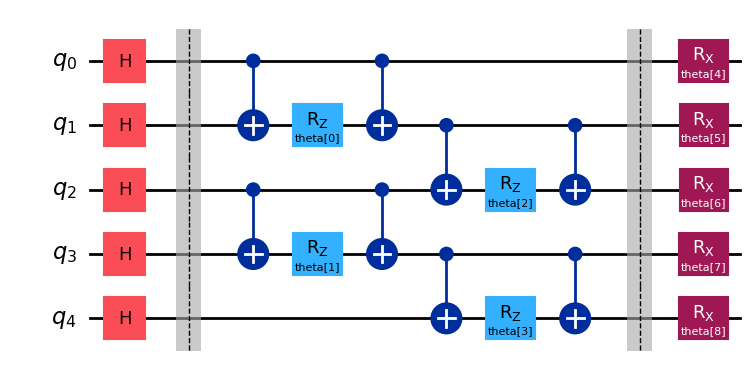

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

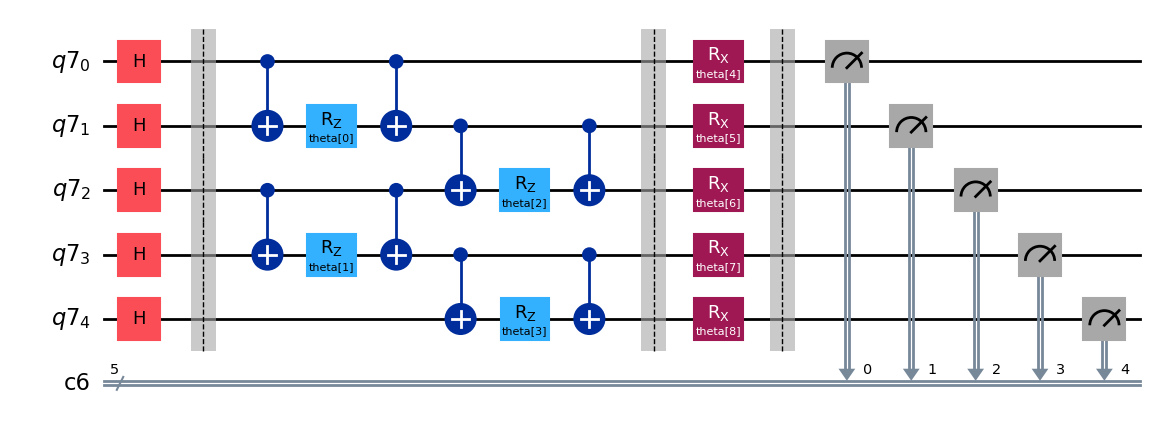

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

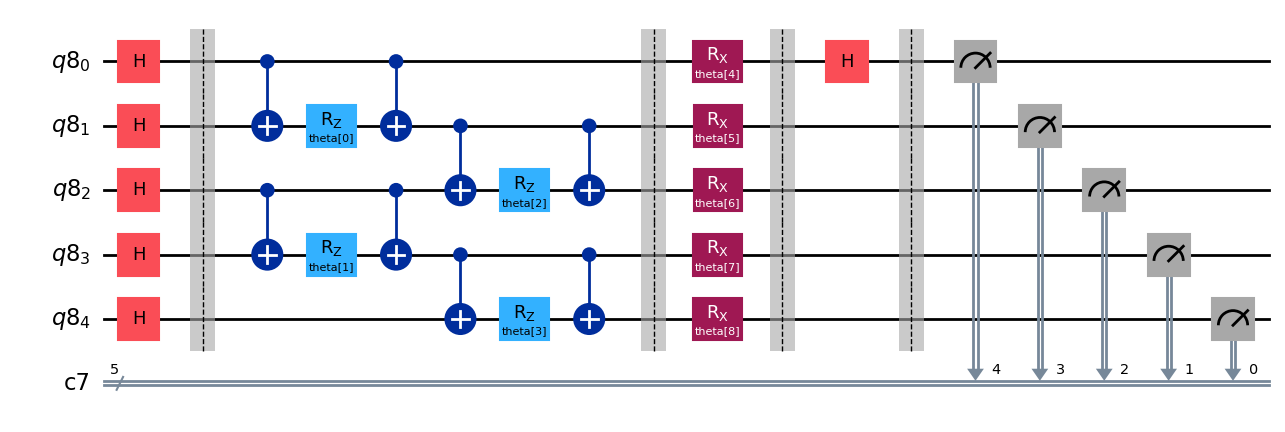

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

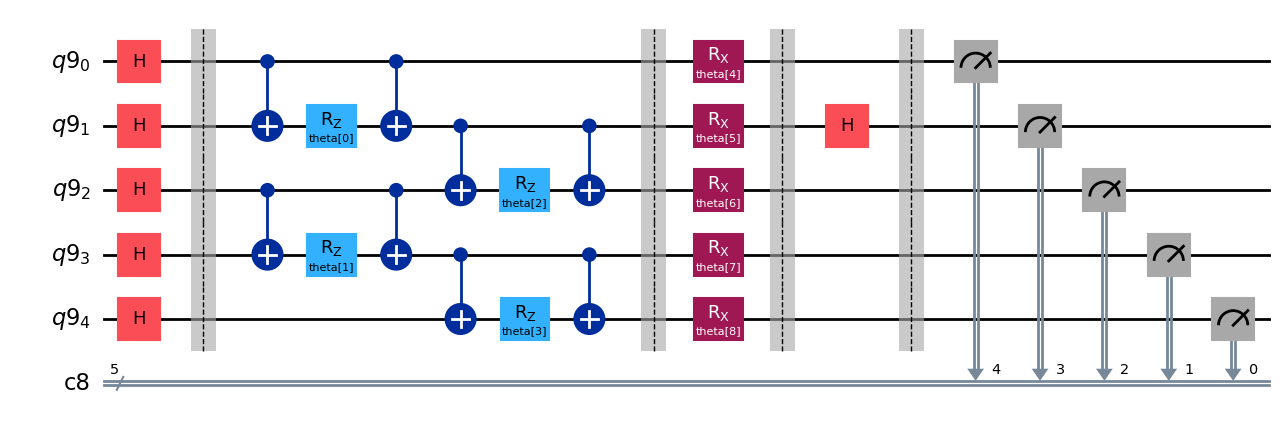

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

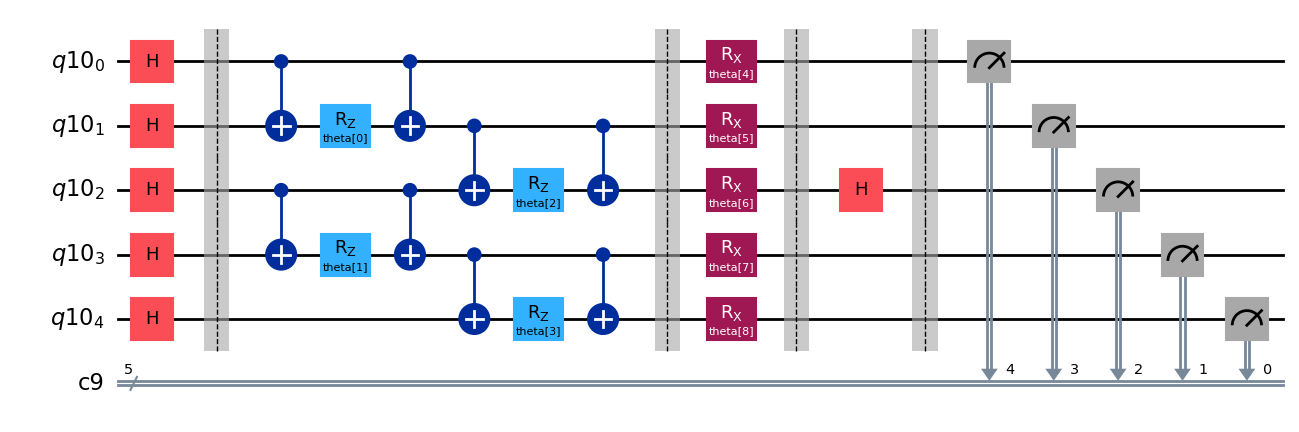

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

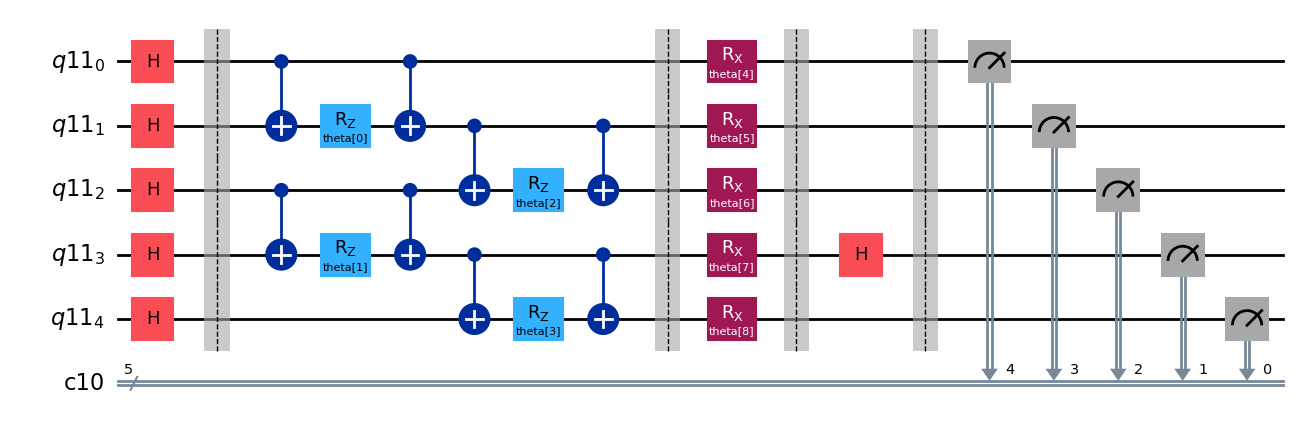

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

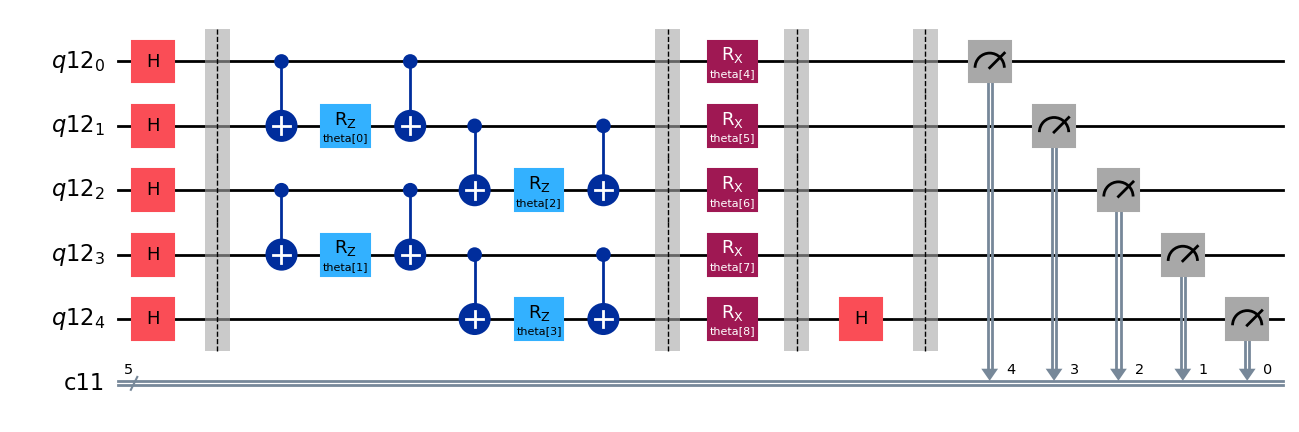

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  ampdamp_rate = error_list[num]

  damp1 = amplitude_damping_error(ampdamp_rate)
  damp2 = damp1.tensor(damp1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.876600000000001

error rate : 0.001, lowest energy vqe : -5.878239999999999

error rate : 0.002, lowest energy vqe : -5.87098

error rate : 0.003, lowest energy vqe : -5.860439999999999

error rate : 0.004, lowest energy vqe : -5.8485000000000005

error rate : 0.005, lowest energy vqe : -5.8170600000000015



In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

# 4. Hidden Layer Estimation

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, Hidden Layer 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

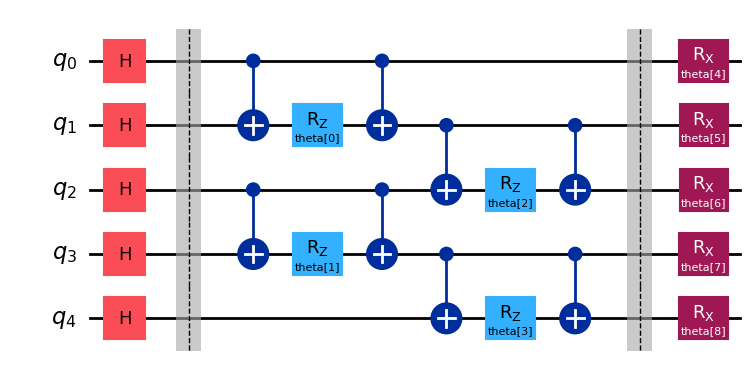

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

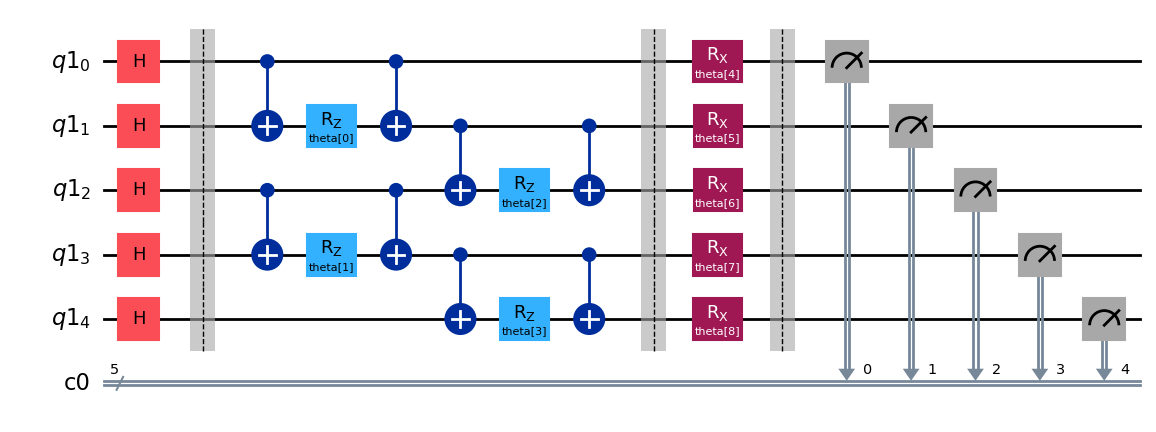

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

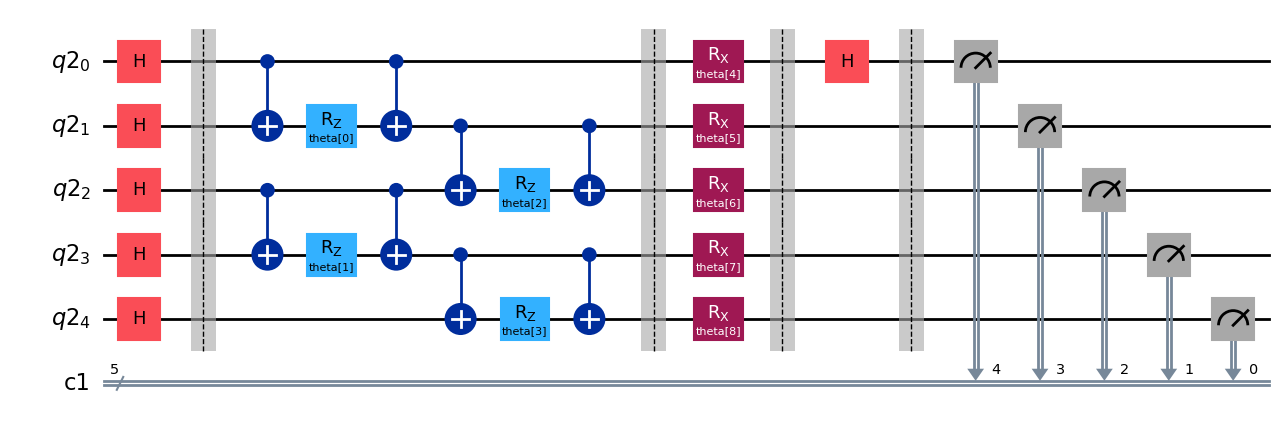

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

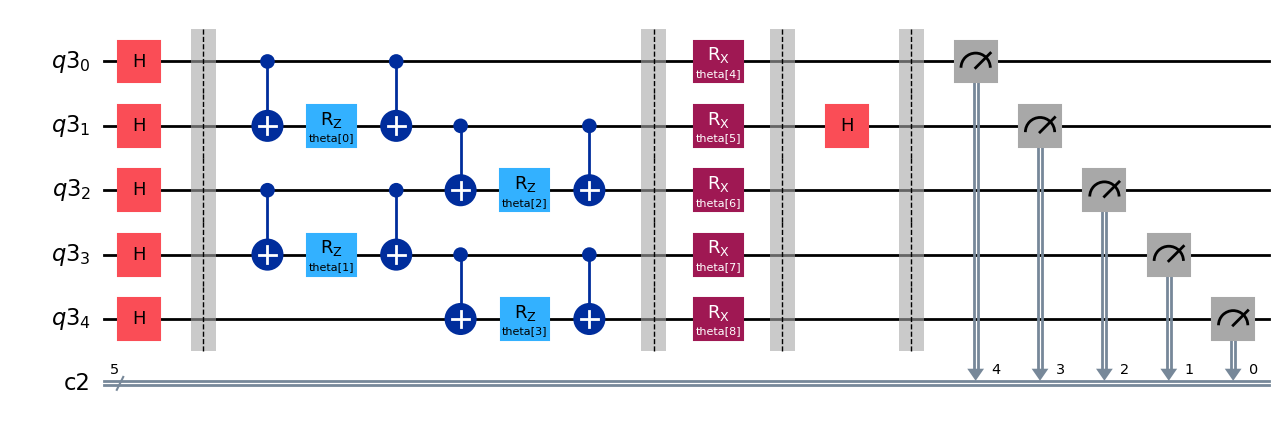

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

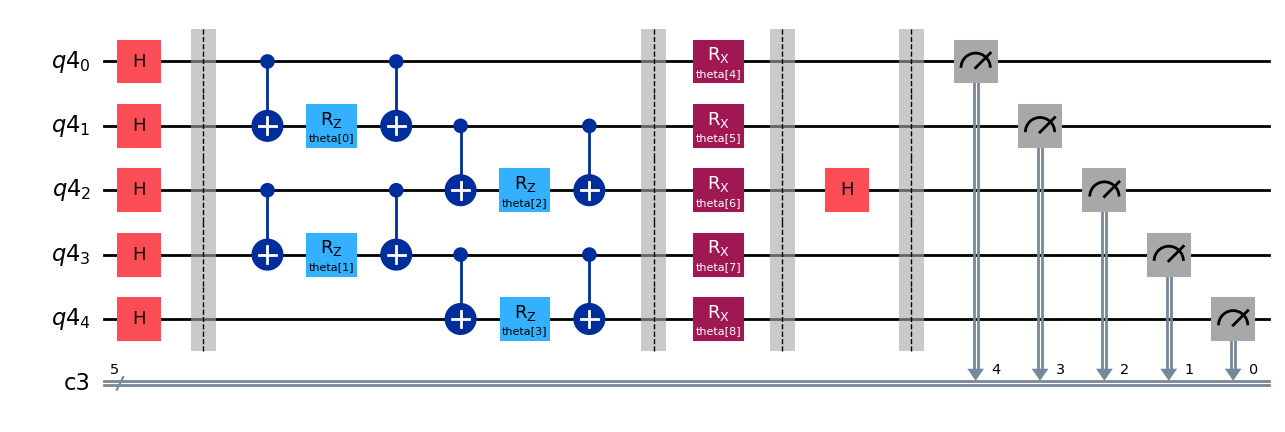

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

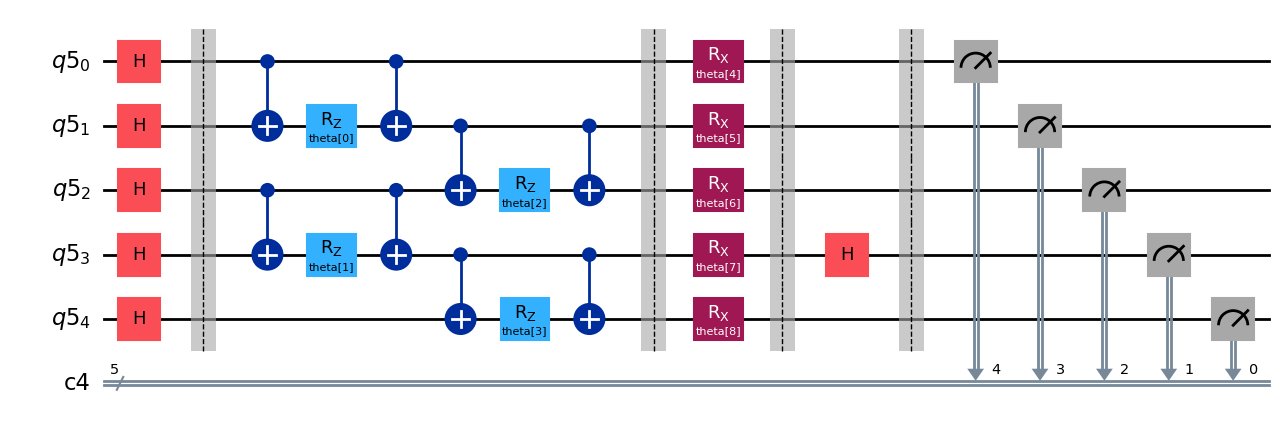

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

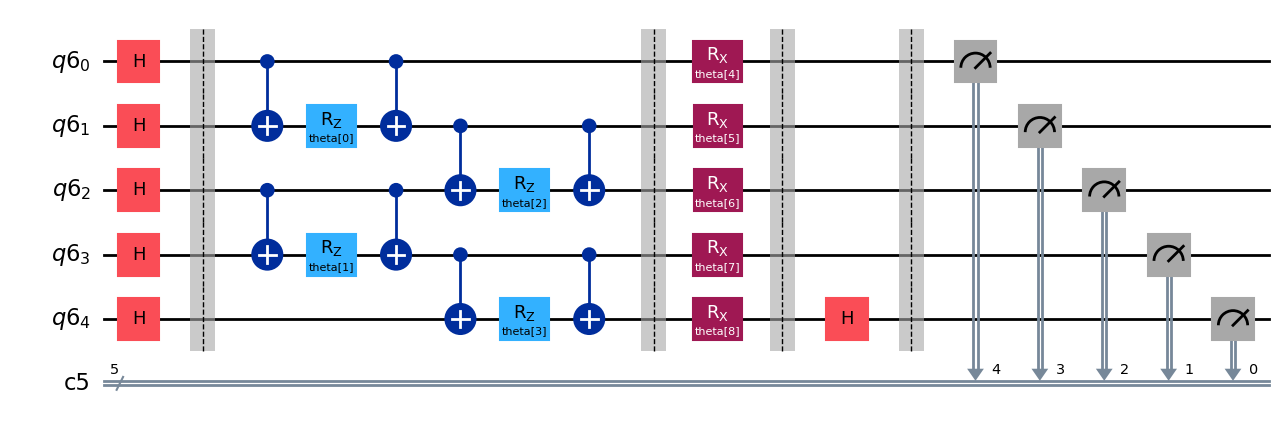

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005198
         Iterations: 100
         Function evaluations: 5824
         Gradient evaluations: 112
         Current function value: -6.001280
         Iterations: 100
         Function evaluations: 7020
         Gradient evaluations: 135
         Current function value: -5.917861
         Iterations: 100
         Function evaluations: 8268
         Gradient evaluations: 159
         Current function value: -6.006155
         Iterations: 100
         Function evaluations: 6084
         Gradient evaluations: 117
         Current function value: -6.000713
         Iterations: 100
         Function evaluations: 5928
         Gradient evaluations: 114
         Current function value: -6.005823
         Iterations: 100
         Function evaluations: 8788
         Gradient evaluations: 169
         Current function value: -5.998328
         Iterations: 100
         Function evaluations: 6916
         Gradient evaluations: 133
         Current function v

In [ ]:
lowest_energy_vqnhe_list

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, Hidden Layer 2

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

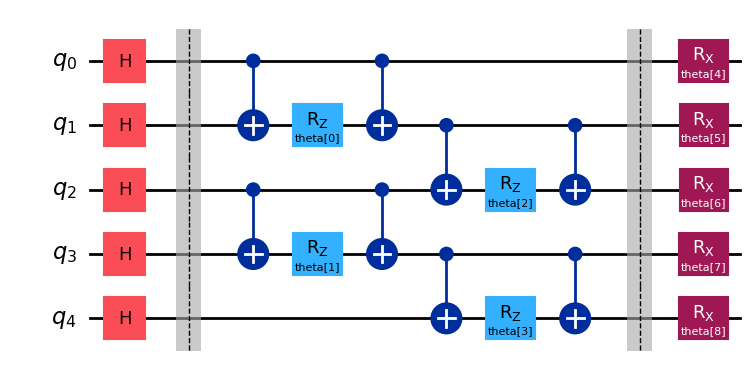

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

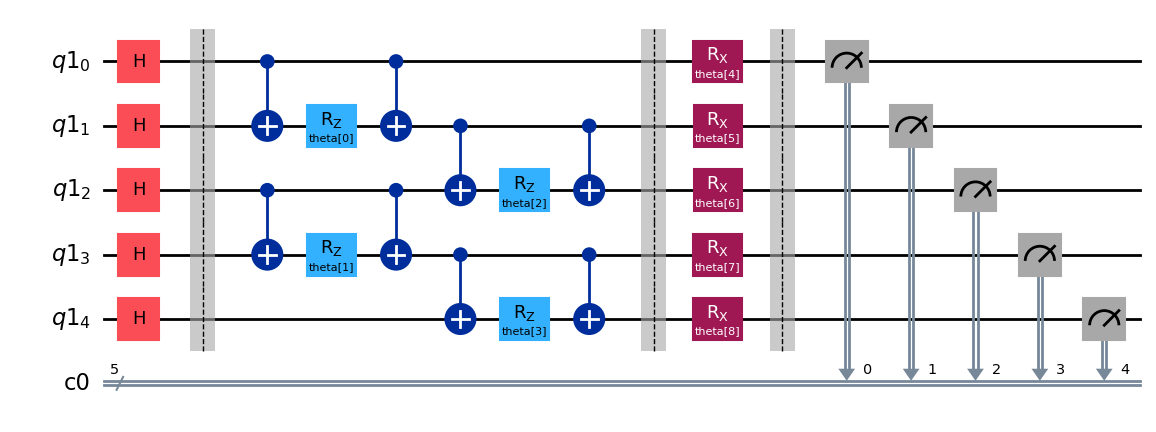

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

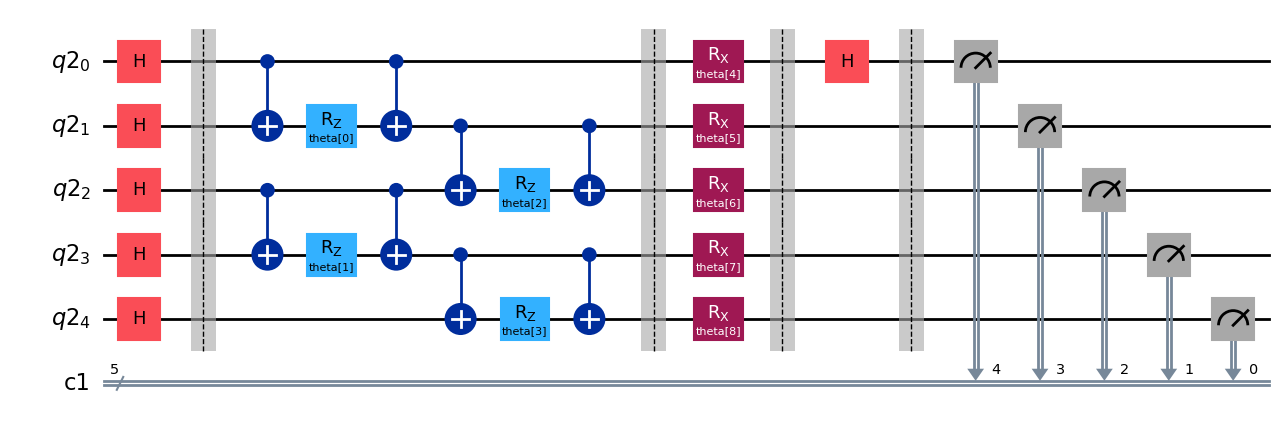

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

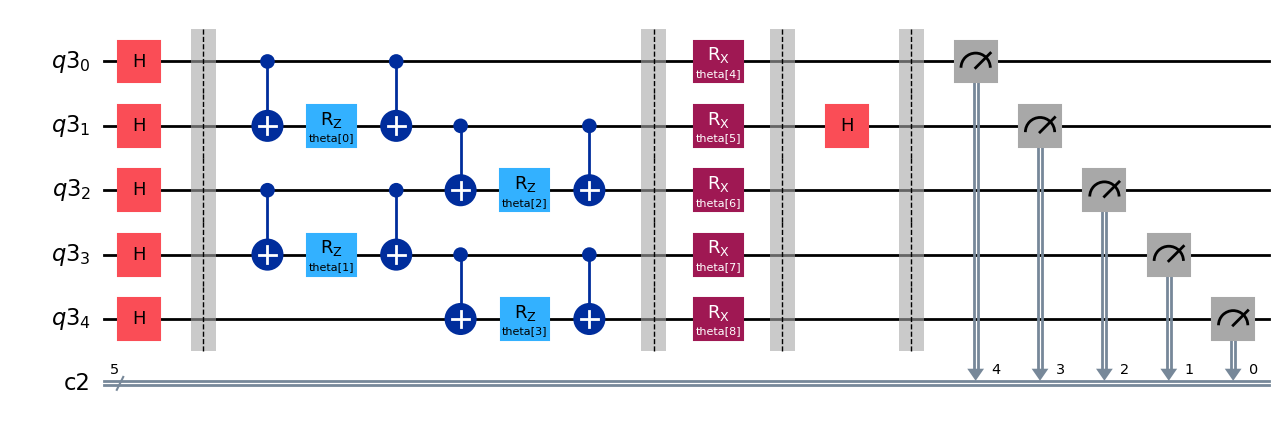

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

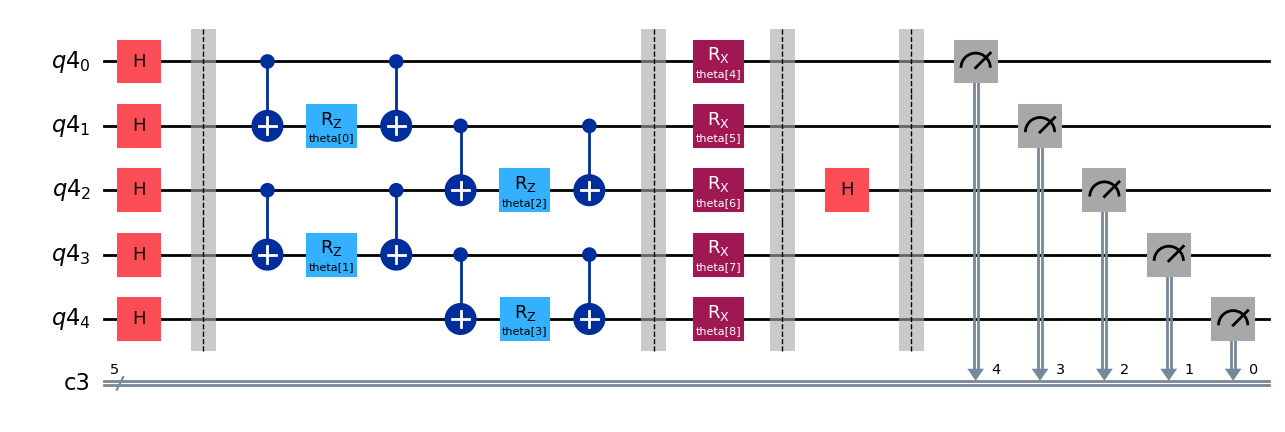

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

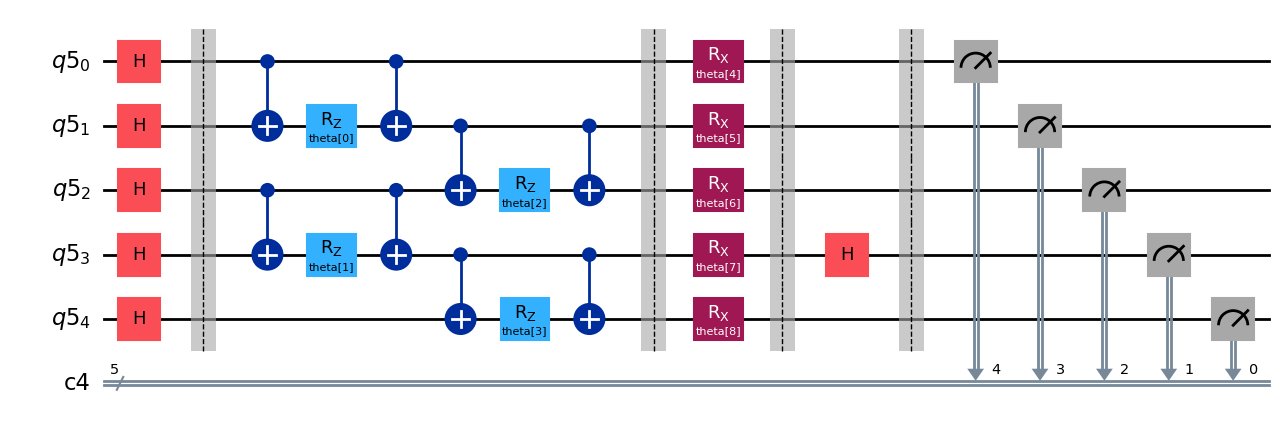

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

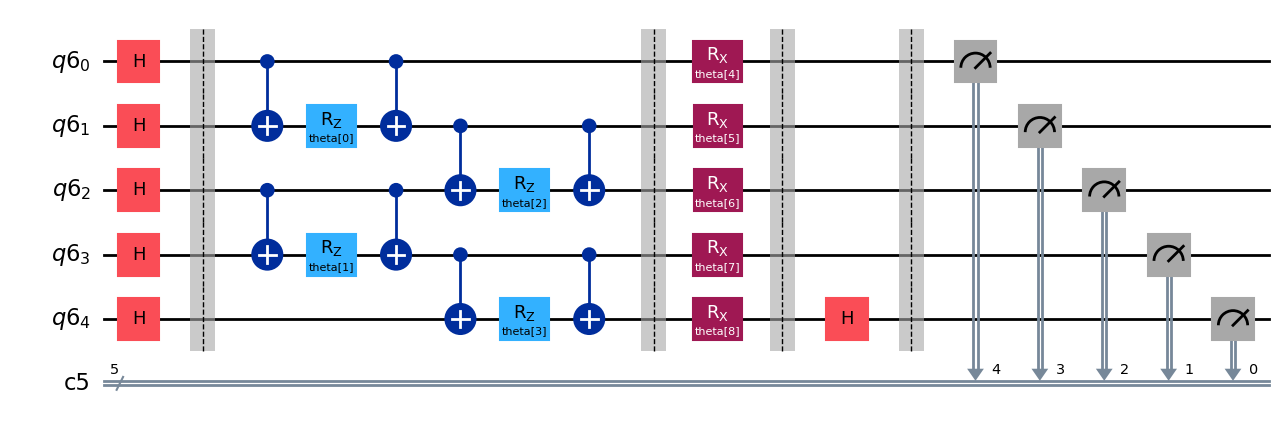

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  W3 = parameter[50:75]
  c = parameter[75]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)
  W3 = W3.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=76), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=76), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=76), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=76), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(76) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016911
         Iterations: 200
         Function evaluations: 20251
         Gradient evaluations: 263
Optimization terminated successfully.
         Current function value: -5.858540
         Iterations: 92
         Function evaluations: 8701
         Gradient evaluations: 113
         Current function value: -5.947324
         Iterations: 200
         Function evaluations: 18865
         Gradient evaluations: 245


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011483
         Iterations: 154
         Function evaluations: 19647
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001949
         Iterations: 91
         Function evaluations: 14026
         Gradient evaluations: 182


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973570
         Iterations: 200
         Function evaluations: 23100
         Gradient evaluations: 300
         Current function value: -6.004056
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229
         Current function value: -6.010048
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283
         Current function value: -6.004172
         Iterations: 200
         Function evaluations: 19327
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000299
         Iterations: 167
         Function evaluations: 20950
         Gradient evaluations: 272


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.007599
         Iterations: 200
         Function evaluations: 18711
         Gradient evaluations: 243
         Current function value: -5.993138
         Iterations: 200
         Function evaluations: 19327
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.933075
         Iterations: 37
         Function evaluations: 7481
         Gradient evaluations: 97


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.007897
         Iterations: 200
         Function evaluations: 21252
         Gradient evaluations: 276
         Current function value: -6.017371
         Iterations: 200
         Function evaluations: 17710
         Gradient evaluations: 230


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.947731
         Iterations: 106
         Function evaluations: 20648
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.948797
         Iterations: 127
         Function evaluations: 19563
         Gradient evaluations: 254


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012360
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238
         Current function value: -6.008396
         Iterations: 200
         Function evaluations: 22099
         Gradient evaluations: 287
         Current function value: -6.001598
         Iterations: 200
         Function evaluations: 23485
         Gradient evaluations: 305
error rate : 0.0, lowest energy vqnhe : -6.0173706367674225



error rate : 0.001, lowest energy vqe : -5.8191999999999995

         Current function value: -5.989320
         Iterations: 200
         Function evaluations: 18711
         Gradient evaluations: 243
Optimization terminated successfully.
         Current function value: -5.871625
         Iterations: 95
         Function evaluations: 15631
         Gradient evaluations: 203
         Current function value: -5.987592
         Iterations: 200
         Function evaluations: 16555
         Gradient evaluations: 215

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.962821
         Iterations: 54
         Function evaluations: 9559
         Gradient evaluations: 124


<ipython-input-14-e5dda20ba8ec>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-17-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:41: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:54: RuntimeWarning: invalid value encountered in scalar add
  expval = expval + prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:69: RuntimeWarning: invalid value encountered in scalar multiply
  expval = expval + delt*nnval[k]*nnval[k+16]
<ipython-input-17-942dbc8389c9>:86: RuntimeWarning: invalid value encountered in scalar multiply
  expval = expval + delt*nnval[k]*nnval[k+8]
<ipython-input-17-942dbc8389c9>:111: RuntimeWar

         Current function value: nan
         Iterations: 137
         Function evaluations: 24409
         Gradient evaluations: 317


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944494
         Iterations: 160
         Function evaluations: 19258
         Gradient evaluations: 250


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.970060
         Iterations: 85
         Function evaluations: 10945
         Gradient evaluations: 142


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920685
         Iterations: 123
         Function evaluations: 16641
         Gradient evaluations: 216


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969675
         Iterations: 200
         Function evaluations: 19404
         Gradient evaluations: 252


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969648
         Iterations: 193
         Function evaluations: 22650
         Gradient evaluations: 294


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973884
         Iterations: 200
         Function evaluations: 23793
         Gradient evaluations: 309


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.993314
         Iterations: 167
         Function evaluations: 19335
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985860
         Iterations: 200
         Function evaluations: 20636
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984256
         Iterations: 154
         Function evaluations: 23034
         Gradient evaluations: 299


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.931325
         Iterations: 79
         Function evaluations: 15946
         Gradient evaluations: 207


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982560
         Iterations: 200
         Function evaluations: 17402
         Gradient evaluations: 226
         Current function value: -5.984075
         Iterations: 200
         Function evaluations: 20251
         Gradient evaluations: 263
         Current function value: -5.987427
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233
Optimization terminated successfully.
         Current function value: -5.819594
         Iterations: 5
         Function evaluations: 539
         Gradient evaluations: 7
error rate : 0.001, lowest energy vqnhe : -5.993313911187684



error rate : 0.002, lowest energy vqe : -5.775000000000001

Optimization terminated successfully.
         Current function value: -5.965747
         Iterations: 183
         Function evaluations: 16016
         Gradient evaluations: 208


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.904327
         Iterations: 91
         Function evaluations: 18723
         Gradient evaluations: 243


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.008383
         Iterations: 194
         Function evaluations: 27110
         Gradient evaluations: 352


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011223
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
         Current function value: -5.989217
         Iterations: 200
         Function evaluations: 18557
         Gradient evaluations: 241
         Current function value: -5.929576
         Iterations: 200
         Function evaluations: 20713
         Gradient evaluations: 269
         Current function value: -6.005179
         Iterations: 200
         Function evaluations: 19635
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001492
         Iterations: 164
         Function evaluations: 19793
         Gradient evaluations: 257


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.991037
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989178
         Iterations: 24
         Function evaluations: 7633
         Gradient evaluations: 99


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.998286
         Iterations: 200
         Function evaluations: 18249
         Gradient evaluations: 237
         Current function value: -6.008645
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 219
         Current function value: -5.959829
         Iterations: 200
         Function evaluations: 20559
         Gradient evaluations: 267
         Current function value: -5.961617
         Iterations: 200
         Function evaluations: 20405
         Gradient evaluations: 265


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.873786
         Iterations: 160
         Function evaluations: 28036
         Gradient evaluations: 364


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989362
         Iterations: 200
         Function evaluations: 20790
         Gradient evaluations: 270
         Current function value: -6.011529
         Iterations: 200
         Function evaluations: 22869
         Gradient evaluations: 297
         Current function value: -6.012983
         Iterations: 200
         Function evaluations: 17556
         Gradient evaluations: 228
         Current function value: -5.993830
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229
         Current function value: -5.976523
         Iterations: 200
         Function evaluations: 21560
         Gradient evaluations: 280
error rate : 0.002, lowest energy vqnhe : -6.012982704979324



error rate : 0.003, lowest energy vqe : -5.782000000000001

         Current function value: -5.953604
         Iterations: 200
         Function evaluations: 19327
         Gradient evaluations: 251
         Current function value: -5.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.917610
         Iterations: 180
         Function evaluations: 24112
         Gradient evaluations: 313


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.907059
         Iterations: 97
         Function evaluations: 19413
         Gradient evaluations: 252


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955885
         Iterations: 200
         Function evaluations: 26334
         Gradient evaluations: 342
         Current function value: -5.950237
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.940148
         Iterations: 161
         Function evaluations: 20647
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.881269
         Iterations: 113
         Function evaluations: 16259
         Gradient evaluations: 211


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944238
         Iterations: 111
         Function evaluations: 11088
         Gradient evaluations: 144


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.931678
         Iterations: 95
         Function evaluations: 15790
         Gradient evaluations: 205


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955838
         Iterations: 111
         Function evaluations: 14796
         Gradient evaluations: 192


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.833863
         Iterations: 115
         Function evaluations: 17791
         Gradient evaluations: 231


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959515
         Iterations: 200
         Function evaluations: 18403
         Gradient evaluations: 239
         Current function value: -5.956533
         Iterations: 200
         Function evaluations: 19173
         Gradient evaluations: 249
         Current function value: -5.957408
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
         Current function value: -5.956723
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.909343
         Iterations: 57
         Function evaluations: 9551
         Gradient evaluations: 124
error rate : 0.003, lowest energy vqnhe : -5.959514687263201



error rate : 0.004, lowest energy vqe : -5.7467999999999995



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.911267
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.899742
         Iterations: 64
         Function evaluations: 10253
         Gradient evaluations: 133


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.863159
         Iterations: 23
         Function evaluations: 5241
         Gradient evaluations: 68


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.879460
         Iterations: 200
         Function evaluations: 19558
         Gradient evaluations: 254


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.753649
         Iterations: 3
         Function evaluations: 4863
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.891669
         Iterations: 60
         Function evaluations: 9560
         Gradient evaluations: 124


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.910543
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.899554
         Iterations: 170
         Function evaluations: 17260
         Gradient evaluations: 224


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.910691
         Iterations: 200
         Function evaluations: 16786
         Gradient evaluations: 218
         Current function value: -5.896111
         Iterations: 200
         Function evaluations: 18095
         Gradient evaluations: 235
Optimization terminated successfully.
         Current function value: -5.835636
         Iterations: 77
         Function evaluations: 6622
         Gradient evaluations: 86
         Current function value: -5.906503
         Iterations: 200
         Function evaluations: 16324
         Gradient evaluations: 212
         Current function value: -5.900697
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234
         Current function value: -5.811594
         Iterations: 200
         Function evaluations: 20328
         Gradient evaluations: 264
         Current function value: -5.901327
         Iterations: 200
         Function evaluations: 18095
         Gradient ev

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.839565
         Iterations: 25
         Function evaluations: 7012
         Gradient evaluations: 91


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.895065
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246
error rate : 0.004, lowest energy vqnhe : -5.911266723444214



error rate : 0.005, lowest energy vqe : -5.742000000000001

Optimization terminated successfully.
         Current function value: -5.797377
         Iterations: 43
         Function evaluations: 3927
         Gradient evaluations: 51
         Current function value: -5.986228
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.964764
         Iterations: 154
         Function evaluations: 20487
         Gradient evaluations: 266


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.966221
         Iterations: 179
         Function evaluations: 18644
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.954544
         Iterations: 200
         Function evaluations: 21945
         Gradient evaluations: 285
         Current function value: -5.990989
         Iterations: 200
         Function evaluations: 18480
         Gradient evaluations: 240
         Current function value: -5.933533
         Iterations: 200
         Function evaluations: 22330
         Gradient evaluations: 290
Optimization terminated successfully.
         Current function value: -5.892943
         Iterations: 110
         Function evaluations: 9240
         Gradient evaluations: 120
         Current function value: -5.981559
         Iterations: 200
         Function evaluations: 19250
         Gradient evaluations: 250
         Current function value: -5.973504
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 219


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977822
         Iterations: 79
         Function evaluations: 10403
         Gradient evaluations: 135
Optimization terminated successfully.
         Current function value: -5.946090
         Iterations: 174
         Function evaluations: 15323
         Gradient evaluations: 199


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971389
         Iterations: 145
         Function evaluations: 21337
         Gradient evaluations: 277


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.902528
         Iterations: 134
         Function evaluations: 18183
         Gradient evaluations: 236


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985763
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233
Optimization terminated successfully.
         Current function value: -5.981579
         Iterations: 142
         Function evaluations: 12474
         Gradient evaluations: 162
         Current function value: -5.980423
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900128
         Iterations: 64
         Function evaluations: 13946
         Gradient evaluations: 181


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.962893
         Iterations: 200
         Function evaluations: 25718
         Gradient evaluations: 334


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.894841
         Iterations: 126
         Function evaluations: 15643
         Gradient evaluations: 203
error rate : 0.005, lowest energy vqnhe : -5.990989291432052



error rate : 0.006, lowest energy vqe : -5.6944



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.899667
         Iterations: 200
         Function evaluations: 25718
         Gradient evaluations: 334


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.892306
         Iterations: 115
         Function evaluations: 17870
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920822
         Iterations: 200
         Function evaluations: 17710
         Gradient evaluations: 230


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.892594
         Iterations: 140
         Function evaluations: 18569
         Gradient evaluations: 241


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.853038
         Iterations: 200
         Function evaluations: 18865
         Gradient evaluations: 245


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.887816
         Iterations: 89
         Function evaluations: 10861
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.907645
         Iterations: 200
         Function evaluations: 18480
         Gradient evaluations: 240
         Current function value: -5.857255
         Iterations: 200
         Function evaluations: 19250
         Gradient evaluations: 250


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.891755
         Iterations: 52
         Function evaluations: 12248
         Gradient evaluations: 159


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913992
         Iterations: 200
         Function evaluations: 18095
         Gradient evaluations: 235
         Current function value: -5.921411
         Iterations: 200
         Function evaluations: 17864
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913484
         Iterations: 186
         Function evaluations: 20027
         Gradient evaluations: 260


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913901
         Iterations: 200
         Function evaluations: 23793
         Gradient evaluations: 309


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913881
         Iterations: 162
         Function evaluations: 22265
         Gradient evaluations: 289


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.908563
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.910701
         Iterations: 121
         Function evaluations: 16952
         Gradient evaluations: 220


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.876956
         Iterations: 200
         Function evaluations: 19558
         Gradient evaluations: 254
Optimization terminated successfully.
         Current function value: -5.751705
         Iterations: 154
         Function evaluations: 14707
         Gradient evaluations: 191
         Current function value: -5.915128
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229
         Current function value: -5.853954
         Iterations: 200
         Function evaluations: 20405
         Gradient evaluations: 265
error rate : 0.006, lowest energy vqnhe : -5.921411066427046



error rate : 0.007, lowest energy vqe : -5.709399999999999

         Current function value: -5.909401
         Iterations: 200
         Function evaluations: 17556
         Gradient evaluations: 228
         Current function value: -5.922813
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 21

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.783315
         Iterations: 124
         Function evaluations: 15098
         Gradient evaluations: 196


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920521
         Iterations: 200
         Function evaluations: 18711
         Gradient evaluations: 243
         Current function value: -5.916730
         Iterations: 200
         Function evaluations: 24409
         Gradient evaluations: 317


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.879408
         Iterations: 38
         Function evaluations: 7634
         Gradient evaluations: 99


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.905984
         Iterations: 200
         Function evaluations: 20482
         Gradient evaluations: 266
         Current function value: -5.921058
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.876342
         Iterations: 145
         Function evaluations: 13706
         Gradient evaluations: 178
         Current function value: -5.919936
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234
         Current function value: -5.914097
         Iterations: 200
         Function evaluations: 19173
         Gradient evaluations: 249
         Current function value: -5.913888
         Iterations: 200
         Function evaluations: 26334
         Gradient evaluations: 342
         Current function value: -5.911667
         Iterations: 200
         Function evaluations: 18557
         Gradient

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.868567
         Iterations: 52
         Function evaluations: 13179
         Gradient evaluations: 171


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.916990
         Iterations: 167
         Function evaluations: 18492
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.914753
         Iterations: 115
         Function evaluations: 14642
         Gradient evaluations: 190


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.919557
         Iterations: 200
         Function evaluations: 24871
         Gradient evaluations: 323
error rate : 0.007, lowest energy vqnhe : -5.922812789337397



error rate : 0.008, lowest energy vqe : -5.684400000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.730184
         Iterations: 25
         Function evaluations: 8476
         Gradient evaluations: 110


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.853780
         Iterations: 179
         Function evaluations: 19185
         Gradient evaluations: 249


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.857247
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
Optimization terminated successfully.
         Current function value: -5.714056
         Iterations: 118
         Function evaluations: 12936
         Gradient evaluations: 168
         Current function value: -5.847643
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283
         Current function value: -5.837996
         Iterations: 200
         Function evaluations: 20944
         Gradient evaluations: 272
         Current function value: -5.859590
         Iterations: 200
         Function evaluations: 17171
         Gradient evaluations: 223
         Current function value: -5.850868
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.791374
         Iterations: 52
         Function

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.844257
         Iterations: 75
         Function evaluations: 12640
         Gradient evaluations: 164


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.834665
         Iterations: 200
         Function evaluations: 20251
         Gradient evaluations: 263
         Current function value: -5.854714
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247
         Current function value: -5.844400
         Iterations: 200
         Function evaluations: 24948
         Gradient evaluations: 324


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.798755
         Iterations: 58
         Function evaluations: 11869
         Gradient evaluations: 154


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.854632
         Iterations: 169
         Function evaluations: 21721
         Gradient evaluations: 282


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.789106
         Iterations: 77
         Function evaluations: 12255
         Gradient evaluations: 159


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.858411
         Iterations: 200
         Function evaluations: 18634
         Gradient evaluations: 242
         Current function value: -5.854164
         Iterations: 200
         Function evaluations: 19635
         Gradient evaluations: 255
         Current function value: -5.795578
         Iterations: 200
         Function evaluations: 24871
         Gradient evaluations: 323
error rate : 0.008, lowest energy vqnhe : -5.859590075454634



error rate : 0.009000000000000001, lowest energy vqe : -5.6546



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.757683
         Iterations: 46
         Function evaluations: 7321
         Gradient evaluations: 95


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.832837
         Iterations: 182
         Function evaluations: 24960
         Gradient evaluations: 324


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.817848
         Iterations: 84
         Function evaluations: 12405
         Gradient evaluations: 161


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.786030
         Iterations: 168
         Function evaluations: 22335
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.843245
         Iterations: 200
         Function evaluations: 17248
         Gradient evaluations: 224
Optimization terminated successfully.
         Current function value: -5.771397
         Iterations: 98
         Function evaluations: 9394
         Gradient evaluations: 122
         Current function value: -5.839601
         Iterations: 200
         Function evaluations: 20020
         Gradient evaluations: 260
         Current function value: -5.840898
         Iterations: 200
         Function evaluations: 16940
         Gradient evaluations: 220


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.837037
         Iterations: 176
         Function evaluations: 19180
         Gradient evaluations: 249


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.760778
         Iterations: 119
         Function evaluations: 20878
         Gradient evaluations: 271


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.741945
         Iterations: 80
         Function evaluations: 13102
         Gradient evaluations: 170
Optimization terminated successfully.
         Current function value: -5.747974
         Iterations: 78
         Function evaluations: 6776
         Gradient evaluations: 88


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.809407
         Iterations: 111
         Function evaluations: 18492
         Gradient evaluations: 240
Optimization terminated successfully.
         Current function value: -5.762089
         Iterations: 45
         Function evaluations: 4004
         Gradient evaluations: 52


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.840906
         Iterations: 200
         Function evaluations: 17325
         Gradient evaluations: 225
         Current function value: -5.834033
         Iterations: 200
         Function evaluations: 19096
         Gradient evaluations: 248
         Current function value: -5.792708
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.832316
         Iterations: 170
         Function evaluations: 19254
         Gradient evaluations: 250


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.673188
         Iterations: 5
         Function evaluations: 6403
         Gradient evaluations: 83


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.812133
         Iterations: 120
         Function evaluations: 14174
         Gradient evaluations: 184
error rate : 0.009000000000000001, lowest energy vqnhe : -5.8432447761105



error rate : 0.01, lowest energy vqe : -5.6246



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.807386
         Iterations: 200
         Function evaluations: 17094
         Gradient evaluations: 222
         Current function value: -5.804925
         Iterations: 200
         Function evaluations: 19789
         Gradient evaluations: 257
         Current function value: -5.780112
         Iterations: 200
         Function evaluations: 25256
         Gradient evaluations: 328


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.721762
         Iterations: 123
         Function evaluations: 16336
         Gradient evaluations: 212


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.806536
         Iterations: 139
         Function evaluations: 15335
         Gradient evaluations: 199


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.812010
         Iterations: 200
         Function evaluations: 17402
         Gradient evaluations: 226
         Current function value: -5.811416
         Iterations: 200
         Function evaluations: 20559
         Gradient evaluations: 267
Optimization terminated successfully.
         Current function value: -5.733621
         Iterations: 50
         Function evaluations: 4466
         Gradient evaluations: 58


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.792923
         Iterations: 128
         Function evaluations: 16870
         Gradient evaluations: 219


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.811716
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.723886
         Iterations: 125
         Function evaluations: 17560
         Gradient evaluations: 228


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.806829
         Iterations: 154
         Function evaluations: 22419
         Gradient evaluations: 291


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.799268
         Iterations: 123
         Function evaluations: 15405
         Gradient evaluations: 200


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.781096
         Iterations: 200
         Function evaluations: 21637
         Gradient evaluations: 281


KeyboardInterrupt: 

In [ ]:
lowest_energy_vqnhe_list

NameError: name 'lowest_energy_vqnhe_list' is not defined

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, Hidden Layer 5

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

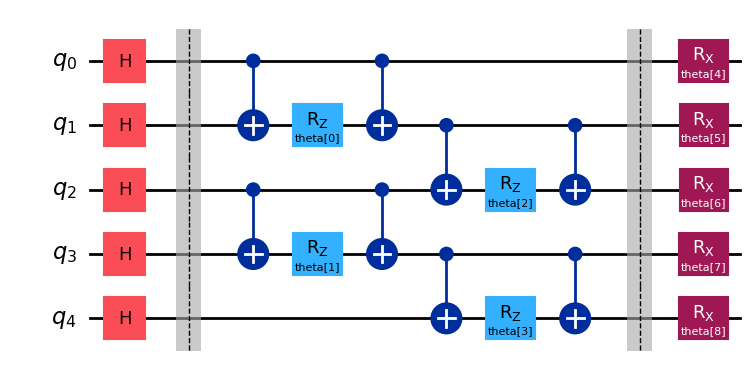

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

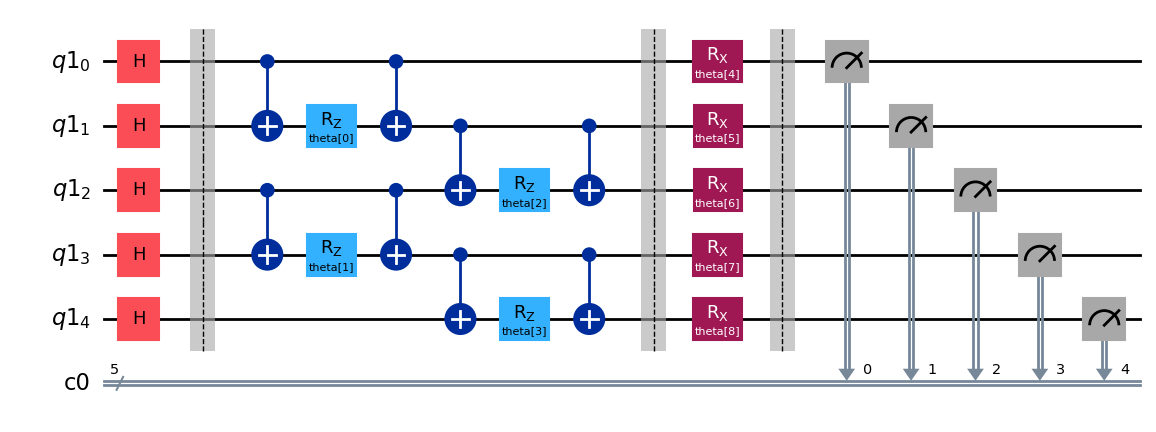

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

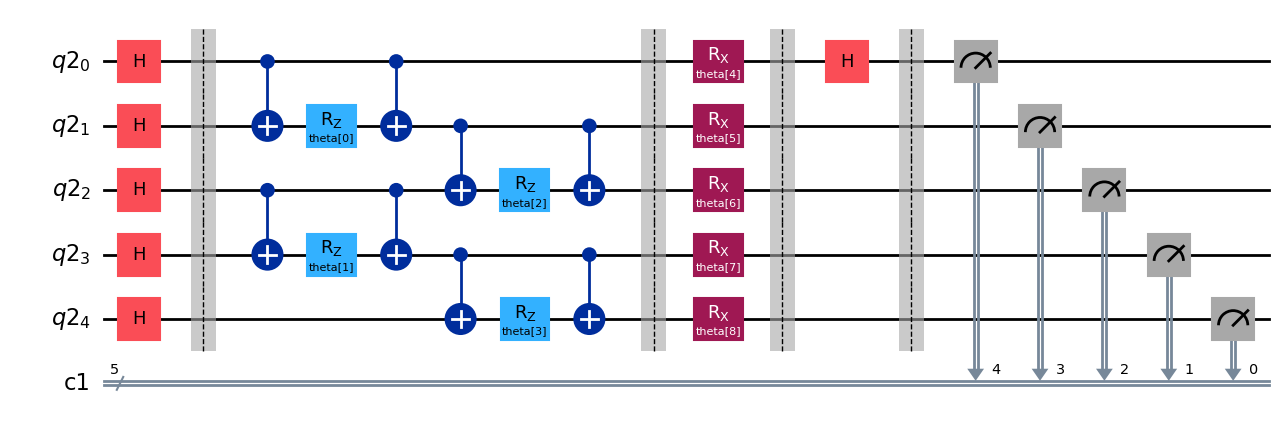

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

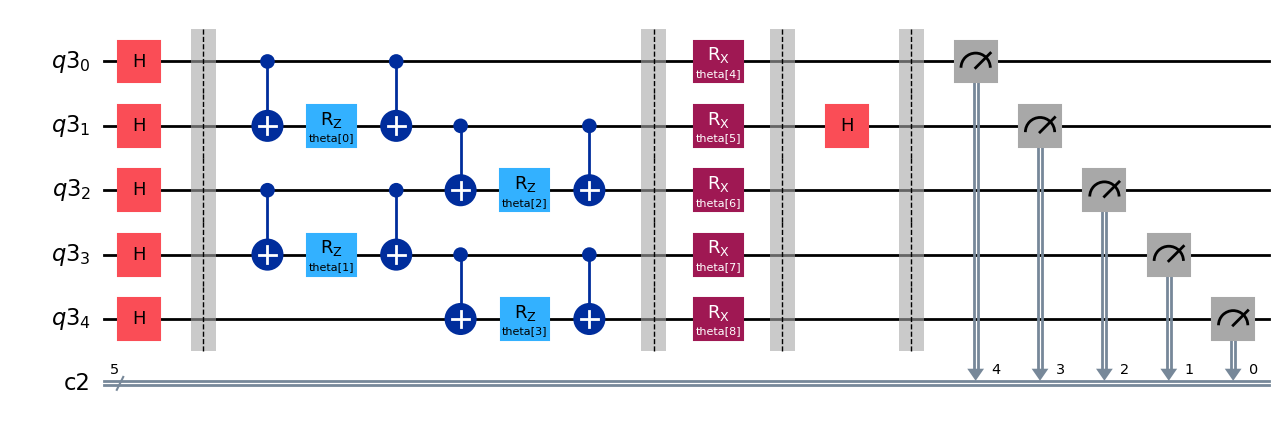

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

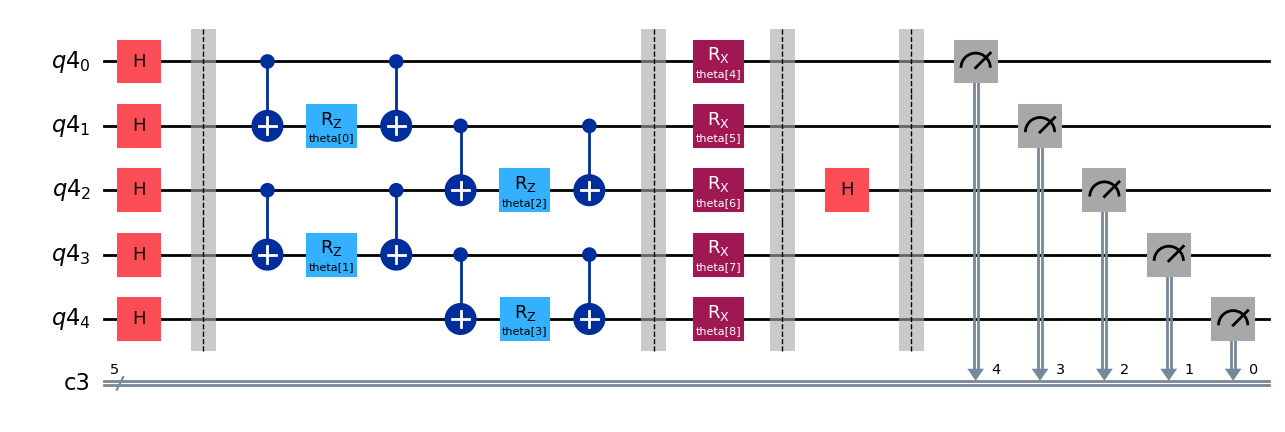

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

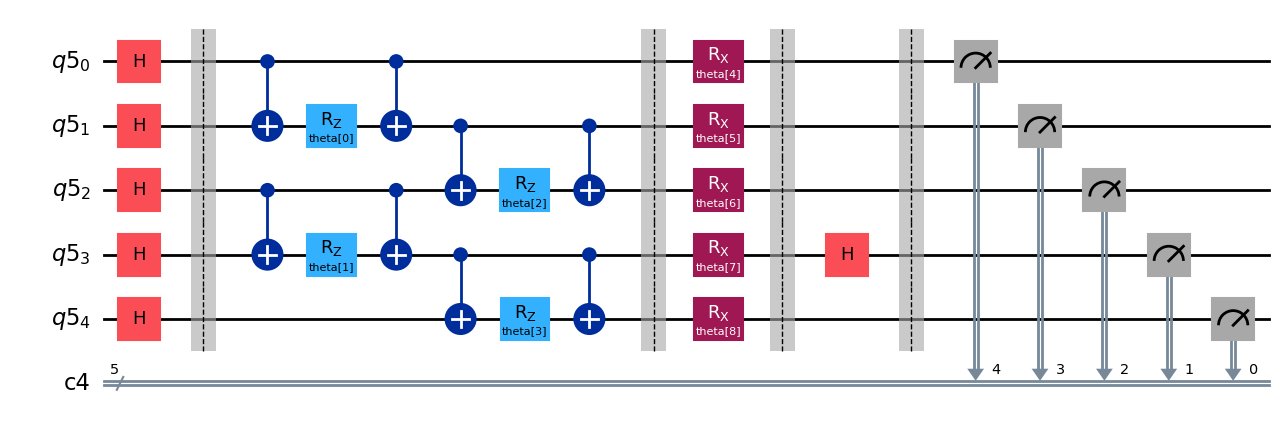

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

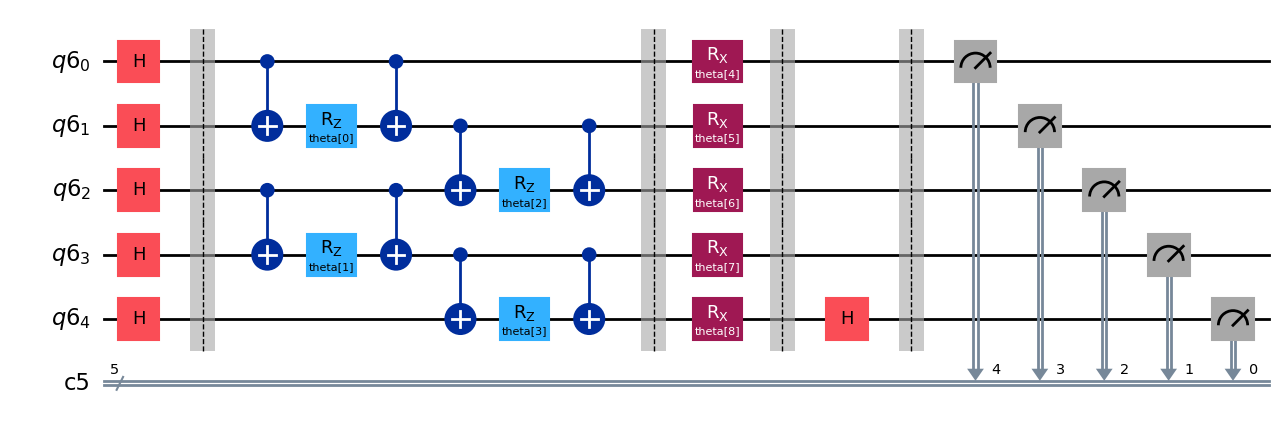

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  W3 = parameter[50:75]
  W4 = parameter[75:100]
  W5 = parameter[100:125]
  W6 = parameter[125:130]
  c = parameter[130]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)
  W3 = W3.reshape(5,5)
  W4 = W4.reshape(5,5)
  W5 = W5.reshape(5,5)
  W6 = W6.reshape(1,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  z3 = relu(a3)

  a4 = np.matmul(W4, z3)
  z4 = relu(a4)

  a5 = np.matmul(W5, z4)
  z5 = relu(a5)

  a6 = np.matmul(W6, z5)
  y = output_activate(c, a6)

  return y[0]



# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=131), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=131), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001



In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=131), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=131), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(131) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, Hidden Layer 1 But Unit 10

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

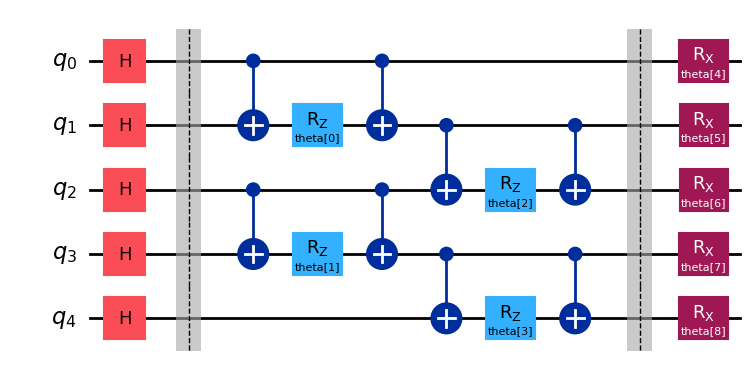

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

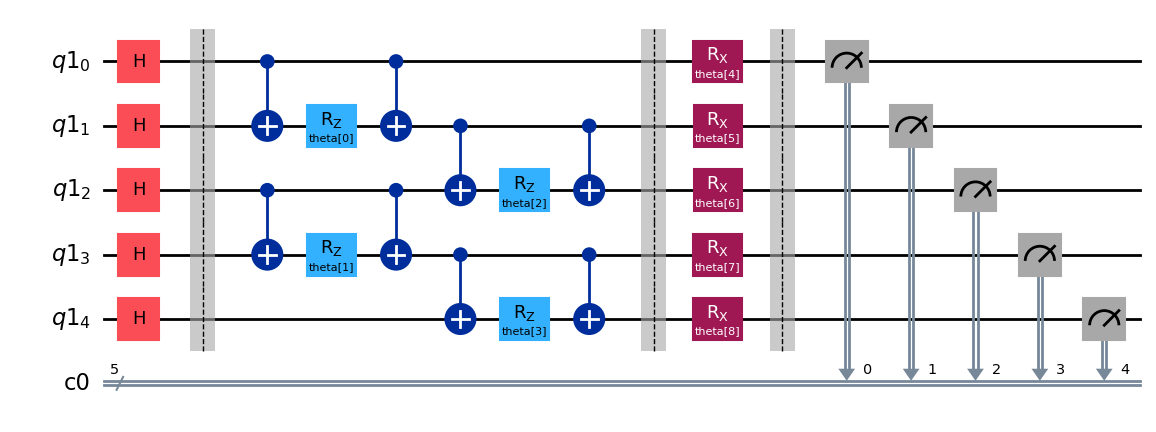

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

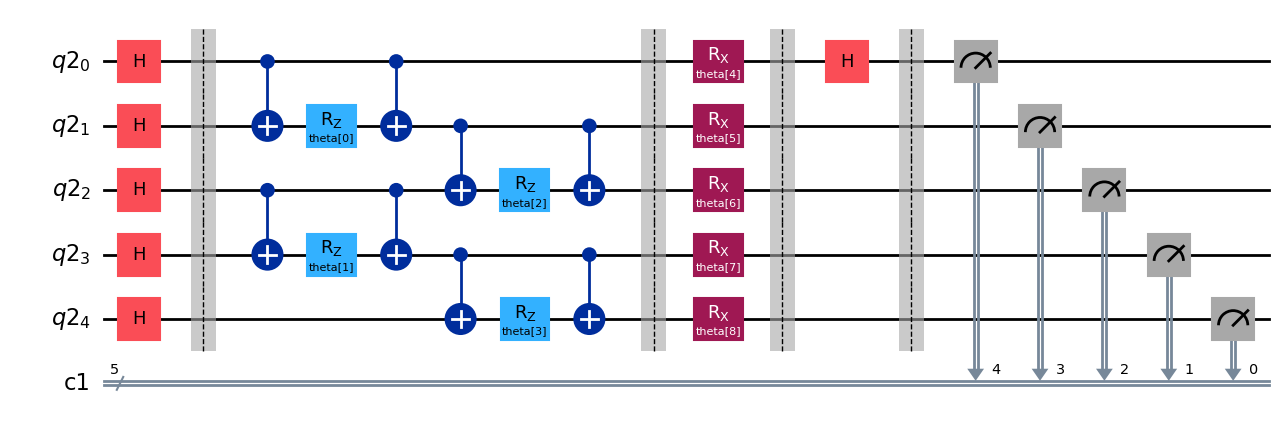

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

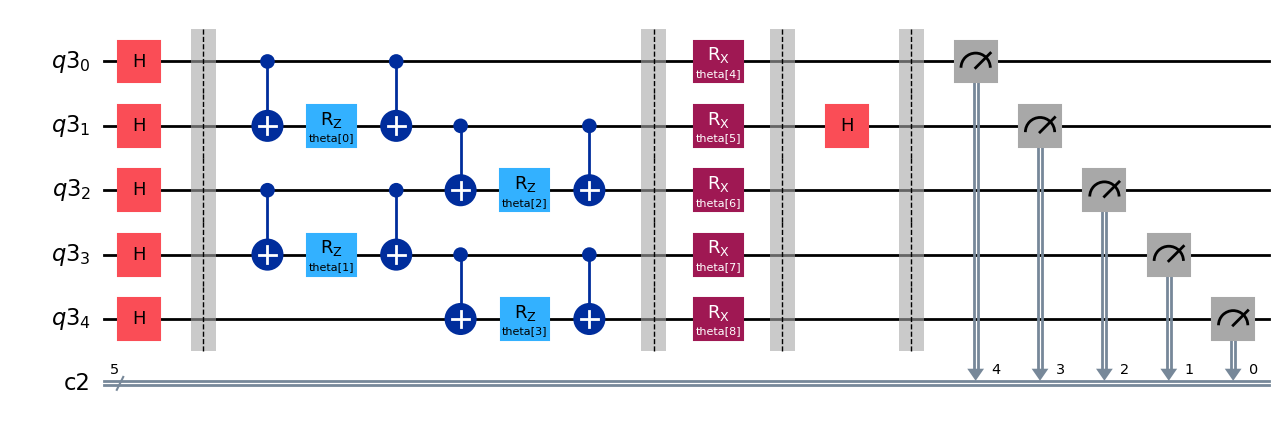

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

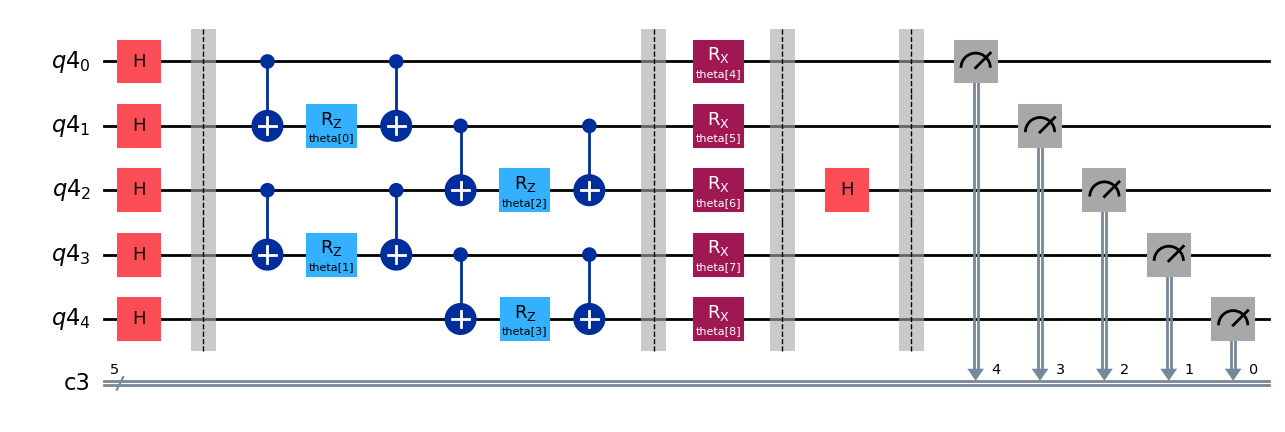

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

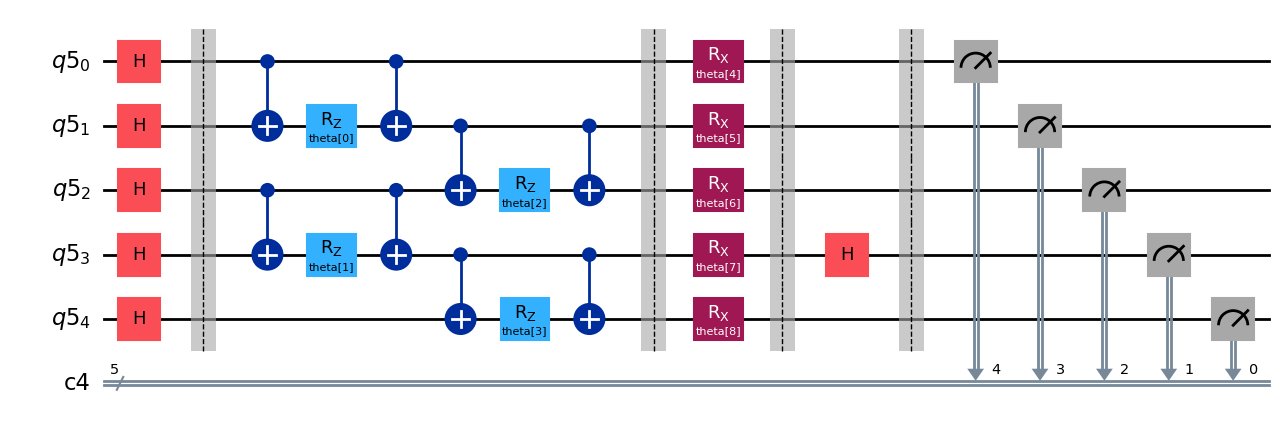

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

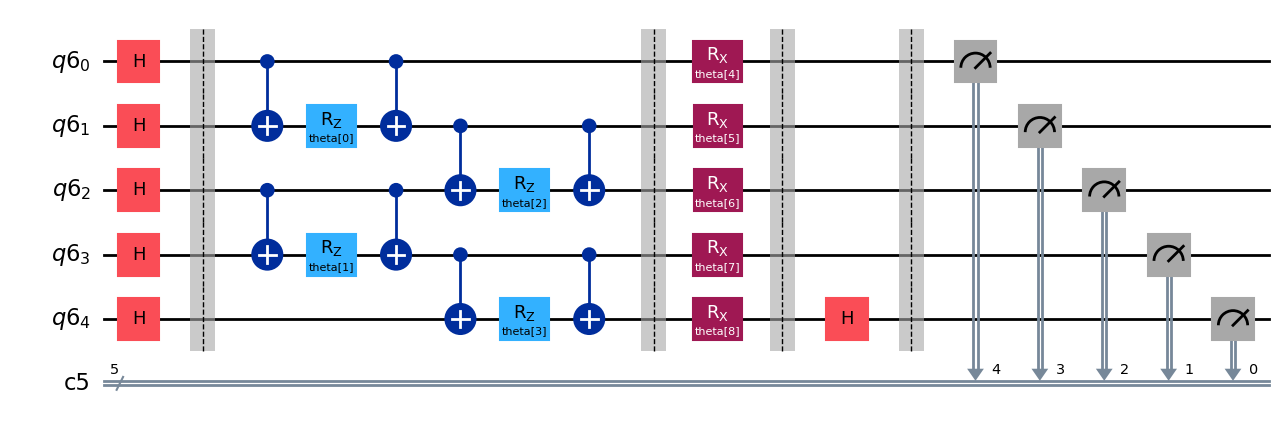

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:60]
  c = parameter[60]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(1,10)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=61), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=61), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=61), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=61), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(61) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

Optimization terminated successfully.
         Current function value: -6.018029
         Iterations: 168
         Function evaluations: 10726
         Gradient evaluations: 173


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017651
         Iterations: 200
         Function evaluations: 16120
         Gradient evaluations: 260
         Current function value: -6.013011
         Iterations: 200
         Function evaluations: 13702
         Gradient evaluations: 221
         Current function value: -6.018024
         Iterations: 200
         Function evaluations: 13516
         Gradient evaluations: 218
         Current function value: -6.018000
         Iterations: 200
         Function evaluations: 13764
         Gradient evaluations: 222
         Current function value: -6.018006
         Iterations: 200
         Function evaluations: 13330
         Gradient evaluations: 215
         Current function value: -6.010698
         Iterations: 200
         Function evaluations: 13578
         Gradient evaluations: 219
         Current function value: -6.017492
         Iterations: 200
         Function evaluations: 13268
         Gradient evaluations: 214
         Current fun

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984731
         Iterations: 174
         Function evaluations: 16438
         Gradient evaluations: 265
Optimization terminated successfully.
         Current function value: -5.872649
         Iterations: 123
         Function evaluations: 9114
         Gradient evaluations: 147


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.993914
         Iterations: 200
         Function evaluations: 14570
         Gradient evaluations: 235
         Current function value: -5.987611
         Iterations: 200
         Function evaluations: 15686
         Gradient evaluations: 253
         Current function value: -5.991204
         Iterations: 200
         Function evaluations: 14198
         Gradient evaluations: 229
         Current function value: -5.993673
         Iterations: 200
         Function evaluations: 13764
         Gradient evaluations: 222
         Current function value: -5.993913
         Iterations: 200
         Function evaluations: 14694
         Gradient evaluations: 237
         Current function value: -5.993790
         Iterations: 200
         Function evaluations: 18600
         Gradient evaluations: 300
         Current function value: -5.983254
         Iterations: 200
         Function evaluations: 14508
         Gradient evaluations: 234
error rate : 0.001, 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.827452
         Iterations: 101
         Function evaluations: 12467
         Gradient evaluations: 201


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004371
         Iterations: 166
         Function evaluations: 15010
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.006966
         Iterations: 200
         Function evaluations: 14136
         Gradient evaluations: 228
         Current function value: -6.012377
         Iterations: 200
         Function evaluations: 13888
         Gradient evaluations: 224
         Current function value: -6.012402
         Iterations: 200
         Function evaluations: 13454
         Gradient evaluations: 217
error rate : 0.002, lowest energy vqnhe : -6.014639147707469



error rate : 0.003, lowest energy vqe : -5.782000000000001

         Current function value: -5.958721
         Iterations: 200
         Function evaluations: 13950
         Gradient evaluations: 225
         Current function value: -5.959730
         Iterations: 200
         Function evaluations: 13330
         Gradient evaluations: 215
         Current function value: -5.959729
         Iterations: 200
         Function evaluations: 13144
         Gradient evaluations: 212
         Current function value: -5.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.923335
         Iterations: 161
         Function evaluations: 16380
         Gradient evaluations: 264


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.922755
         Iterations: 200
         Function evaluations: 16306
         Gradient evaluations: 263
         Current function value: -5.923067
         Iterations: 200
         Function evaluations: 13144
         Gradient evaluations: 212
error rate : 0.007, lowest energy vqnhe : -5.92337036213113



error rate : 0.008, lowest energy vqe : -5.684400000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.858582
         Iterations: 147
         Function evaluations: 16694
         Gradient evaluations: 269


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.833961
         Iterations: 47
         Function evaluations: 7080
         Gradient evaluations: 114


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.859707
         Iterations: 200
         Function evaluations: 12896
         Gradient evaluations: 208
Optimization terminated successfully.
         Current function value: -5.713845
         Iterations: 68
         Function evaluations: 4526
         Gradient evaluations: 73
Optimization terminated successfully.
         Current function value: -5.859694
         Iterations: 192
         Function evaluations: 12648
         Gradient evaluations: 204
         Current function value: -5.858608
         Iterations: 200
         Function evaluations: 13206
         Gradient evaluations: 213
Optimization terminated successfully.
         Current function value: -5.801007
         Iterations: 194
         Function evaluations: 15810
         Gradient evaluations: 255
Optimization terminated successfully.
         Current function value: -5.859725
         Iterations: 167
         Function evaluations: 11346
         Gradient evaluations: 183
         Cu

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.616081
         Iterations: 44
         Function evaluations: 6894
         Gradient evaluations: 111


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.695717
         Iterations: 200
         Function evaluations: 13578
         Gradient evaluations: 219
         Current function value: -5.695168
         Iterations: 200
         Function evaluations: 13826
         Gradient evaluations: 223
         Current function value: -5.693037
         Iterations: 200
         Function evaluations: 14694
         Gradient evaluations: 237
error rate : 0.02, lowest energy vqnhe : -5.695758589588917



error rate : 0.03, lowest energy vqe : -5.256800000000002

         Current function value: -5.495179
         Iterations: 200
         Function evaluations: 16244
         Gradient evaluations: 262
         Current function value: -5.571209
         Iterations: 200
         Function evaluations: 14880
         Gradient evaluations: 240
         Current function value: -5.573350
         Iterations: 200
         Function evaluations: 13578
         Gradient evaluations: 219
Optimization terminated successfully.


In [ ]:
lowest_energy_vqnhe_list

[-5.398764320375726,
 -5.250990830374524,
 -5.192855248104412,
 -5.170575560977388,
 -5.0383291010529865,
 -4.982976474792443]

# 5. CNN Estimation - Depolarizing Channel

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, Hidden Layer 0개

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

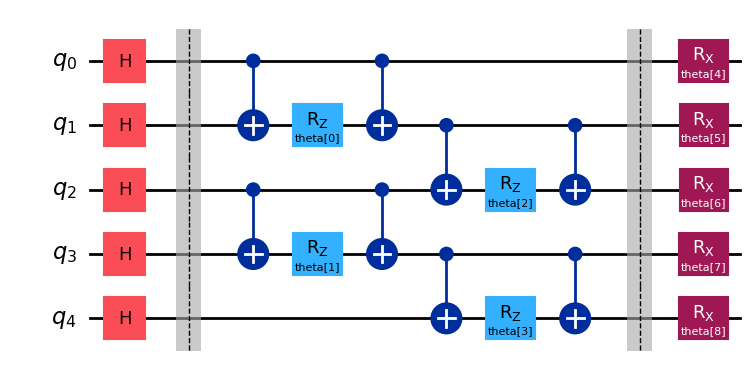

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

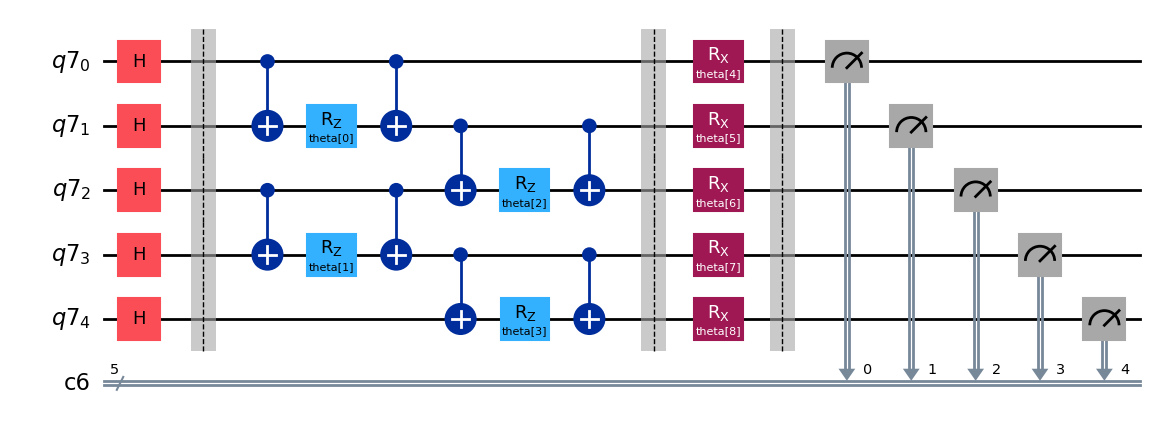

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

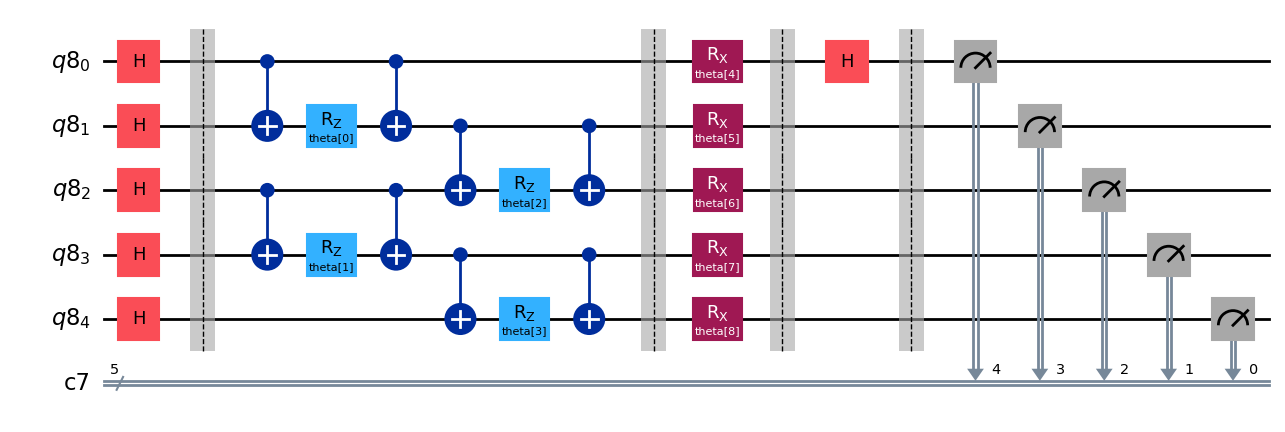

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

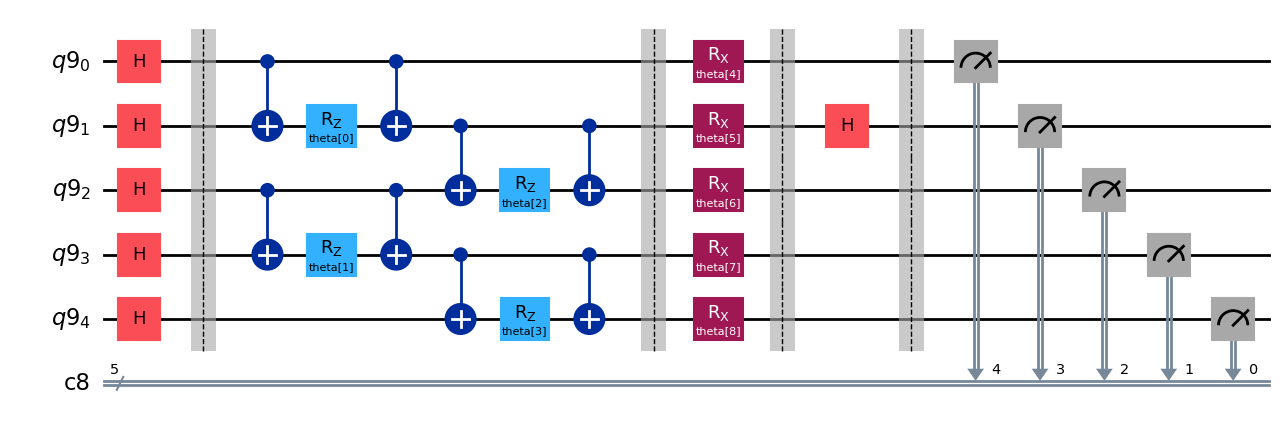

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

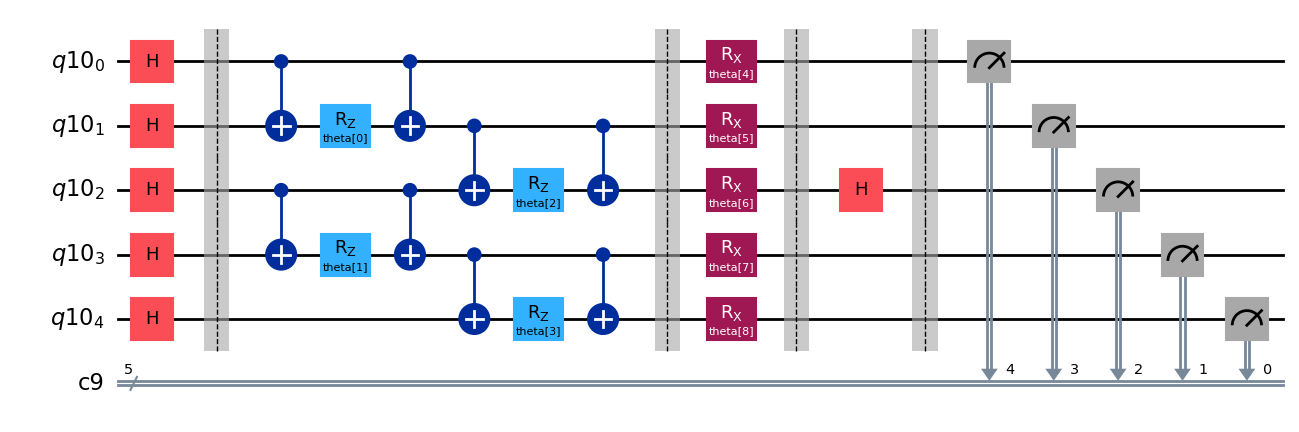

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

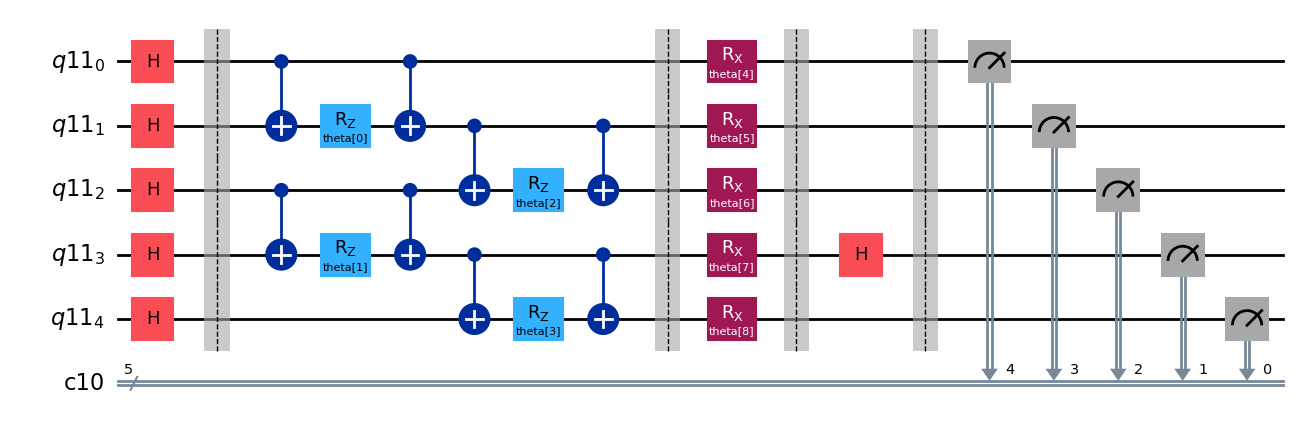

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

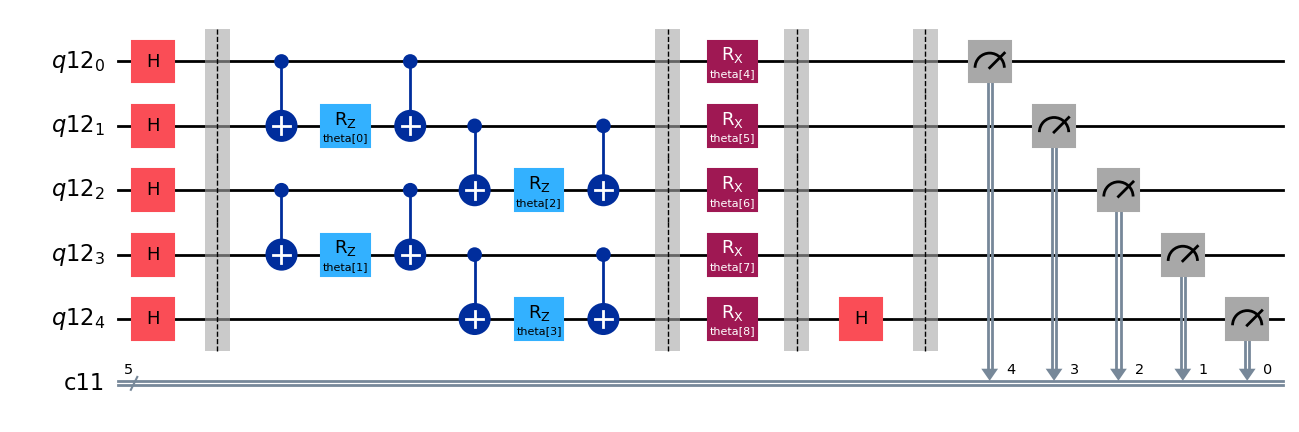

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn(a, b, c, x):
  lst = []
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])

  return np.array(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  FC1 = parameter[0:5]
  c = parameter[5]

  FC1 = FC1.reshape(1,5)


  a1 = np.matmul(FC1, x)
  y = output_activate(c, a1)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=6), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=6), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=6), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=6), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(6) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

Optimization terminated successfully.
         Current function value: -5.919692
         Iterations: 66
         Function evaluations: 539
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: -5.898826
         Iterations: 53
         Function evaluations: 406
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: -5.919691
         Iterations: 55
         Function evaluations: 413
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: -5.873491
         Iterations: 43
         Function evaluations: 574
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: -5.898767
         Iterations: 42
         Function evaluations: 329
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: -

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.860513
         Iterations: 45
         Function evaluations: 427
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: -5.798343
         Iterations: 53
         Function evaluations: 588
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: -5.860512
         Iterations: 44
         Function evaluations: 322
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -5.806718
         Iterations: 57
         Function evaluations: 462
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: -5.814993
         Iterations: 76
         Function evaluations: 658
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: -5.860513
         Iterations: 58
         Function evaluations: 455
         Gradient evaluation

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.772274
         Iterations: 49
         Function evaluations: 483
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: -5.820421
         Iterations: 56
         Function evaluations: 441
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: -5.817207
         Iterations: 51
         Function evaluations: 399
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: -5.827856
         Iterations: 61
         Function evaluations: 511
         Gradient evaluations: 73
error rate : 0.004, lowest energy vqnhe : -5.827856166661195



error rate : 0.005, lowest energy vqe : -5.742000000000001

Optimization terminated successfully.
         Current function value: -5.789710
         Iterations: 58
         Function evaluations: 602
         Gradient evaluations: 86
Optimization terminated successfully.
      

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.793299
         Iterations: 56
         Function evaluations: 677
         Gradient evaluations: 95
Optimization terminated successfully.
         Current function value: -5.786723
         Iterations: 66
         Function evaluations: 532
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: -5.869353
         Iterations: 62
         Function evaluations: 560
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: -5.794190
         Iterations: 47
         Function evaluations: 371
         Gradient evaluations: 53


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.869353
         Iterations: 48
         Function evaluations: 656
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: -5.790517
         Iterations: 35
         Function evaluations: 294
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.805146
         Iterations: 48
         Function evaluations: 448
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -5.805146
         Iterations: 46
         Function evaluations: 371
         Gradient evaluations: 53
error rate : 0.005, lowest energy vqnhe : -5.8693531158632455



error rate : 0.006, lowest energy vqe : -5.6944



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.721471
         Iterations: 54
         Function evaluations: 476
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: -5.761155
         Iterations: 99
         Function evaluations: 833
         Gradient evaluations: 119
Optimization terminated successfully.
         Current function value: -5.803894
         Iterations: 51
         Function evaluations: 371
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: -5.803894
         Iterations: 39
         Function evaluations: 301
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: -5.731167
         Iterations: 51
         Function evaluations: 413
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: -5.803894
         Iterations: 48
         Function evaluations: 392
         Gradient evaluatio

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.755751
         Iterations: 68
         Function evaluations: 588
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: -5.791311
         Iterations: 47
         Function evaluations: 350
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: -5.816255
         Iterations: 47
         Function evaluations: 350
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: -5.749527
         Iterations: 36
         Function evaluations: 294
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -5.791311
         Iterations: 50
         Function evaluations: 413
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: -5.753165
         Iterations: 54
         Function evaluations: 420
         Gradient evaluation

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.691668
         Iterations: 49
         Function evaluations: 504
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: -5.755068
         Iterations: 39
         Function evaluations: 371
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: -5.755068
         Iterations: 40
         Function evaluations: 315
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: -5.734160
         Iterations: 44
         Function evaluations: 357
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: -5.755068
         Iterations: 48
         Function evaluations: 483
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: -5.755068
         Iterations: 44
         Function evaluations: 357
         Gradient evaluation

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.468837
         Iterations: 52
         Function evaluations: 719
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: -5.497512
         Iterations: 89
         Function evaluations: 756
         Gradient evaluations: 108
Optimization terminated successfully.
         Current function value: -5.495975
         Iterations: 51
         Function evaluations: 392
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -5.568578
         Iterations: 48
         Function evaluations: 378
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: -5.567221
         Iterations: 52
         Function evaluations: 420
         Gradient evaluations: 60
error rate : 0.02, lowest energy vqnhe : -5.568578059117119



error rate : 0.03, lowest energy vqe : -5.256800000000002

Optimization terminated successfully.
      

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.411915
         Iterations: 188
         Function evaluations: 1792
         Gradient evaluations: 256
Optimization terminated successfully.
         Current function value: -5.405870
         Iterations: 58
         Function evaluations: 546
         Gradient evaluations: 78
Optimization terminated successfully.
         Current function value: -5.388054
         Iterations: 30
         Function evaluations: 301
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: -5.388054
         Iterations: 32
         Function evaluations: 259
         Gradient evaluations: 37
error rate : 0.03, lowest energy vqnhe : -5.411916222038937



error rate : 0.04, lowest energy vqe : -5.056400000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.258392
         Iterations: 173
         Function evaluations: 1972
         Gradient evaluations: 280


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.284469
         Iterations: 194
         Function evaluations: 1897
         Gradient evaluations: 271
Optimization terminated successfully.
         Current function value: -5.247274
         Iterations: 31
         Function evaluations: 294
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -5.088006
         Iterations: 33
         Function evaluations: 238
         Gradient evaluations: 34


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.258391
         Iterations: 166
         Function evaluations: 1694
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.284469
         Iterations: 167
         Function evaluations: 1757
         Gradient evaluations: 251
Optimization terminated successfully.
         Current function value: -5.110803
         Iterations: 53
         Function evaluations: 462
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: -5.183392
         Iterations: 53
         Function evaluations: 413
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: -5.112370
         Iterations: 61
         Function evaluations: 581
         Gradient evaluations: 83
Optimization terminated successfully.
         Current function value: -5.247274
         Iterations: 30
         Function evaluations: 238
         Gradient evaluations: 34
error rate : 0.04, lowest energy vqnhe : -5.284468919589966



error rate : 0.05, lowest energy vqe : -4.8721999999999985

Optimization terminated successfully.
    

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.265287
         Iterations: 200
         Function evaluations: 1988
         Gradient evaluations: 284
Optimization terminated successfully.
         Current function value: -4.925063
         Iterations: 42
         Function evaluations: 343
         Gradient evaluations: 49


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.265286
         Iterations: 179
         Function evaluations: 1818
         Gradient evaluations: 258
Optimization terminated successfully.
         Current function value: -5.265287
         Iterations: 220
         Function evaluations: 2240
         Gradient evaluations: 320
Optimization terminated successfully.
         Current function value: -4.965638
         Iterations: 49
         Function evaluations: 371
         Gradient evaluations: 53


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.246989
         Iterations: 207
         Function evaluations: 2238
         Gradient evaluations: 318
Optimization terminated successfully.
         Current function value: -5.246989
         Iterations: 193
         Function evaluations: 1855
         Gradient evaluations: 265
Optimization terminated successfully.
         Current function value: -4.933620
         Iterations: 46
         Function evaluations: 406
         Gradient evaluations: 58


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.246987
         Iterations: 195
         Function evaluations: 1820
         Gradient evaluations: 260
error rate : 0.05, lowest energy vqnhe : -5.265287221604532



error rate : 0.06, lowest energy vqe : -4.706800000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.129174
         Iterations: 191
         Function evaluations: 1951
         Gradient evaluations: 277


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.116340
         Iterations: 175
         Function evaluations: 1827
         Gradient evaluations: 261
Optimization terminated successfully.
         Current function value: -4.780580
         Iterations: 43
         Function evaluations: 315
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: -5.129173
         Iterations: 207
         Function evaluations: 2107
         Gradient evaluations: 301
Optimization terminated successfully.
         Current function value: -5.116340
         Iterations: 193
         Function evaluations: 1918
         Gradient evaluations: 274
Optimization terminated successfully.
         Current function value: -5.116341
         Iterations: 217
         Function evaluations: 2051
         Gradient evaluations: 293
Optimization terminated successfully.
         Current function value: -5.116342
         Iterations: 228
         Function evaluations: 2268
         Gradi

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.116342
         Iterations: 222
         Function evaluations: 2100
         Gradient evaluations: 300


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.129172
         Iterations: 175
         Function evaluations: 1666
         Gradient evaluations: 238
error rate : 0.06, lowest energy vqnhe : -5.129173554445168



error rate : 0.07, lowest energy vqe : -4.576600000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.059500
         Iterations: 246
         Function evaluations: 2380
         Gradient evaluations: 340


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.077622
         Iterations: 214
         Function evaluations: 2009
         Gradient evaluations: 287


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.077624
         Iterations: 253
         Function evaluations: 2843
         Gradient evaluations: 403


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.059500
         Iterations: 228
         Function evaluations: 2301
         Gradient evaluations: 327
Optimization terminated successfully.
         Current function value: -5.077622
         Iterations: 175
         Function evaluations: 1652
         Gradient evaluations: 236
Optimization terminated successfully.
         Current function value: -5.059498
         Iterations: 195
         Function evaluations: 1918
         Gradient evaluations: 274


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.077624
         Iterations: 223
         Function evaluations: 2296
         Gradient evaluations: 328
Optimization terminated successfully.
         Current function value: -5.059499
         Iterations: 186
         Function evaluations: 1813
         Gradient evaluations: 259
Optimization terminated successfully.
         Current function value: -4.681916
         Iterations: 52
         Function evaluations: 385
         Gradient evaluations: 55


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.077624
         Iterations: 234
         Function evaluations: 2338
         Gradient evaluations: 334
error rate : 0.07, lowest energy vqnhe : -5.077624272045166



error rate : 0.08, lowest energy vqe : -4.430999999999998



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.073424
         Iterations: 243
         Function evaluations: 2443
         Gradient evaluations: 349


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.073422
         Iterations: 171
         Function evaluations: 1575
         Gradient evaluations: 225
Optimization terminated successfully.
         Current function value: -4.567780
         Iterations: 53
         Function evaluations: 413
         Gradient evaluations: 59


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.007553
         Iterations: 170
         Function evaluations: 1519
         Gradient evaluations: 217
Optimization terminated successfully.
         Current function value: -4.494543
         Iterations: 63
         Function evaluations: 679
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: -4.567780
         Iterations: 104
         Function evaluations: 791
         Gradient evaluations: 113
Optimization terminated successfully.
         Current function value: -4.567780
         Iterations: 101
         Function evaluations: 917
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: -5.007555
         Iterations: 192
         Function evaluations: 1862
         Gradient evaluations: 266


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.007554
         Iterations: 196
         Function evaluations: 2044
         Gradient evaluations: 292


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.073423
         Iterations: 204
         Function evaluations: 1953
         Gradient evaluations: 279
error rate : 0.08, lowest energy vqnhe : -5.073424152028077



error rate : 0.09, lowest energy vqe : -4.254599999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.928244
         Iterations: 246
         Function evaluations: 2749
         Gradient evaluations: 391


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.928241
         Iterations: 196
         Function evaluations: 1981
         Gradient evaluations: 283
Optimization terminated successfully.
         Current function value: -4.928244
         Iterations: 241
         Function evaluations: 2373
         Gradient evaluations: 339
Optimization terminated successfully.
         Current function value: -4.390860
         Iterations: 72
         Function evaluations: 609
         Gradient evaluations: 87
Optimization terminated successfully.
         Current function value: -4.367651
         Iterations: 53
         Function evaluations: 448
         Gradient evaluations: 64


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.928243
         Iterations: 184
         Function evaluations: 1848
         Gradient evaluations: 264
Optimization terminated successfully.
         Current function value: -4.347525
         Iterations: 40
         Function evaluations: 287
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: -4.347525
         Iterations: 44
         Function evaluations: 336
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: -4.928243
         Iterations: 223
         Function evaluations: 2254
         Gradient evaluations: 322
         Current function value: -4.344322
         Iterations: 73
         Function evaluations: 756
         Gradient evaluations: 108
error rate : 0.09, lowest energy vqnhe : -4.928244187760365





/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
lowest_energy_vqnhe_list

[-5.919691524202059,
 -5.909266681731913,
 -5.871121846295345,
 -5.860512992519139,
 -5.827856166661195,
 -5.8693531158632455,
 -5.803894487338251,
 -5.816255217174009,
 -5.763852070123904,
 -5.7550676097308475,
 -5.720940795044208,
 -5.568578059117119,
 -5.411916222038937,
 -5.284468919589966,
 -5.265287221604532,
 -5.129173554445168,
 -5.077624272045166,
 -5.073424152028077,
 -4.928244187760365]

In [ ]:
lowest_energy_vqnhe_list

[-4.911047483324537]

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, FC Hidden Layer 1개

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

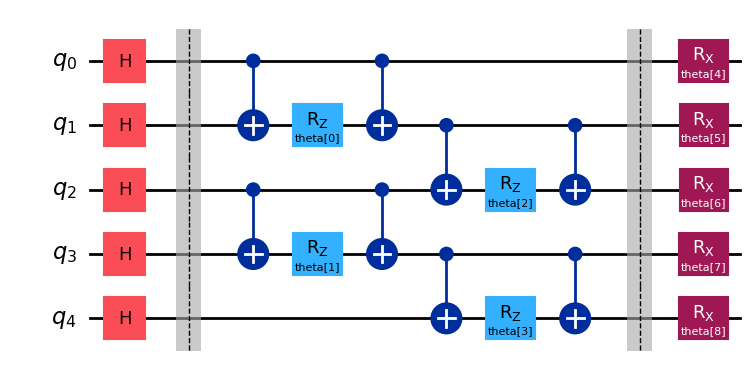

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

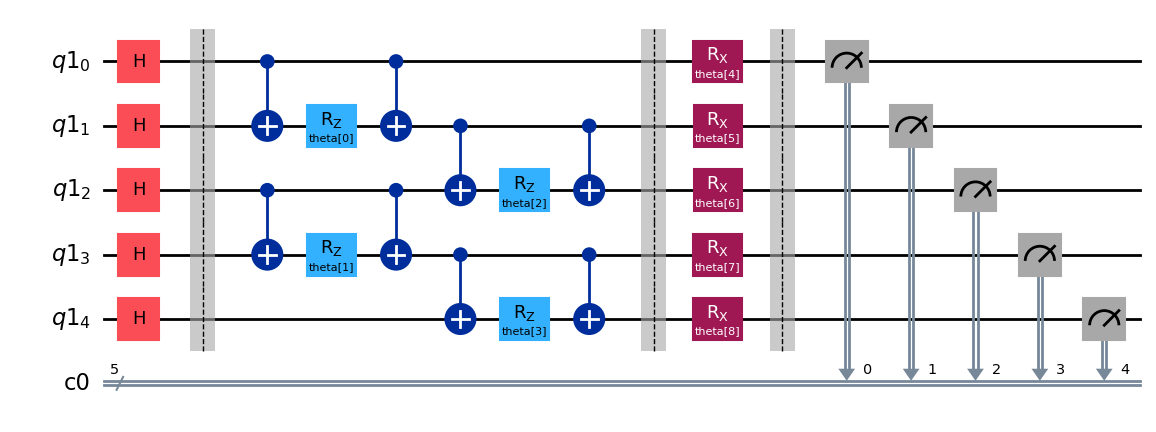

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

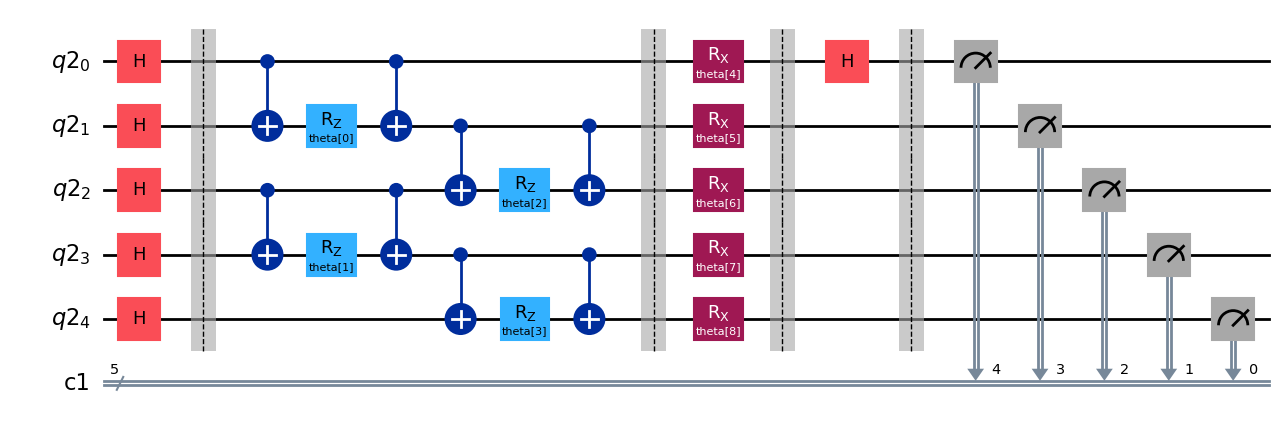

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

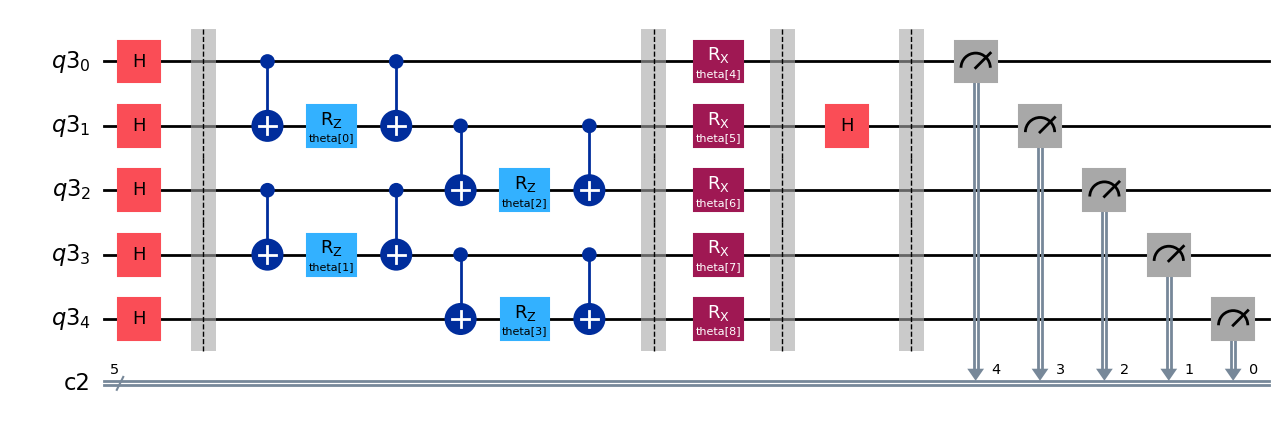

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

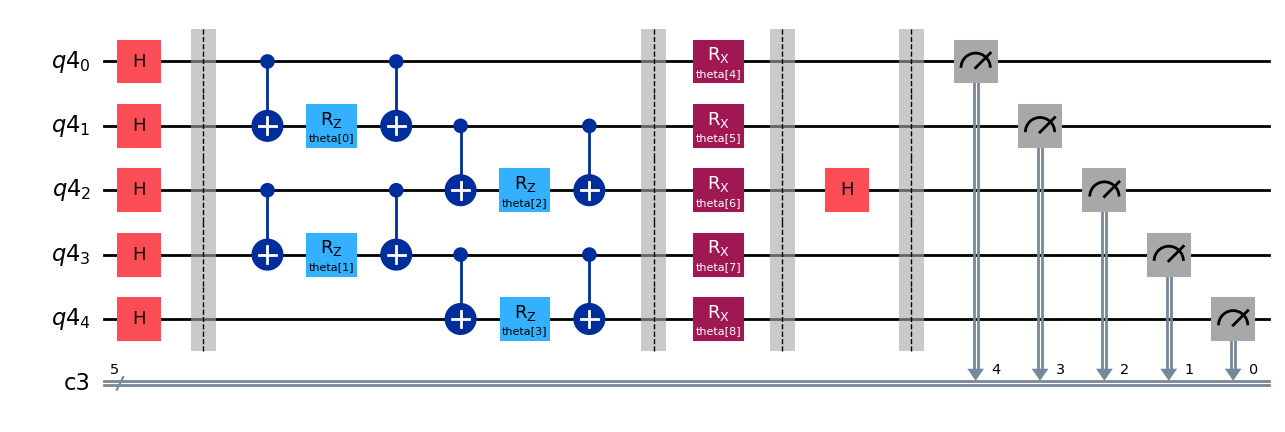

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

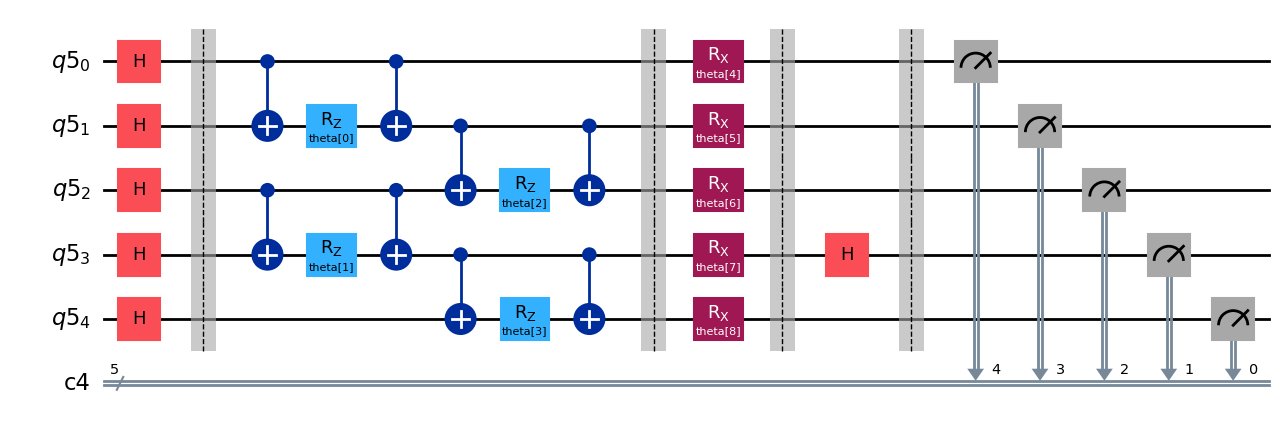

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

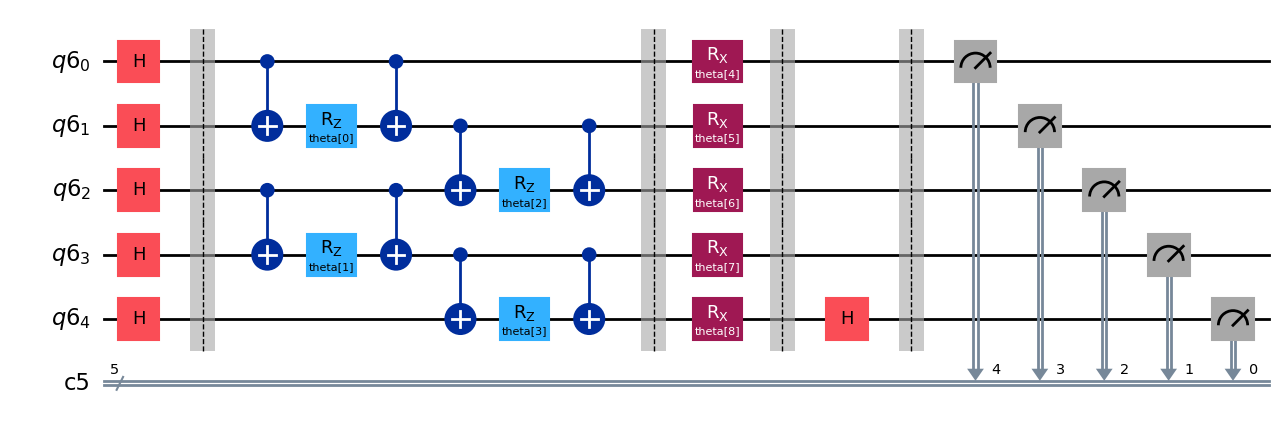

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn(a, b, c, x):
  lst = []
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])

  return np.array(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  FC1 = parameter[0:25]
  FC2 = parameter[25:30]
  c = parameter[30]

  FC1 = FC1.reshape(5,5)
  FC2 = FC2.reshape(1,5)

  a1 = np.matmul(FC1, x)
  z1 = relu(a1)

  a2 = np.matmul(FC2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=82), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=82), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=31), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=31), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100+10, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(31) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

Optimization terminated successfully.
         Current function value: -6.004784
         Iterations: 82
         Function evaluations: 2784
         Gradient evaluations: 87


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.003931
         Iterations: 154
         Function evaluations: 8556
         Gradient evaluations: 267


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.927758
         Iterations: 122
         Function evaluations: 6795
         Gradient evaluations: 212
Optimization terminated successfully.
         Current function value: -5.939194
         Iterations: 208
         Function evaluations: 7840
         Gradient evaluations: 245


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016810
         Iterations: 221
         Function evaluations: 8800
         Gradient evaluations: 275


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.952731
         Iterations: 80
         Function evaluations: 7691
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944070
         Iterations: 300
         Function evaluations: 12864
         Gradient evaluations: 402
Optimization terminated successfully.
         Current function value: -5.950618
         Iterations: 152
         Function evaluations: 6336
         Gradient evaluations: 198


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009845
         Iterations: 188
         Function evaluations: 10475
         Gradient evaluations: 327


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.992475
         Iterations: 300
         Function evaluations: 15040
         Gradient evaluations: 470
error rate : 0.0, lowest energy vqnhe : -6.016810277150228



error rate : 0.001, lowest energy vqe : -5.8191999999999995

         Current function value: -5.987465
         Iterations: 300
         Function evaluations: 14176
         Gradient evaluations: 443


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976115
         Iterations: 117
         Function evaluations: 6502
         Gradient evaluations: 203


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.991393
         Iterations: 300
         Function evaluations: 15872
         Gradient evaluations: 496
Optimization terminated successfully.
         Current function value: -5.917169
         Iterations: 120
         Function evaluations: 4544
         Gradient evaluations: 142
         Current function value: -5.979523
         Iterations: 300
         Function evaluations: 13024
         Gradient evaluations: 407


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985428
         Iterations: 117
         Function evaluations: 5578
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.993446
         Iterations: 232
         Function evaluations: 11020
         Gradient evaluations: 344


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.958837
         Iterations: 104
         Function evaluations: 5484
         Gradient evaluations: 171
Optimization terminated successfully.
         Current function value: -5.918238
         Iterations: 93
         Function evaluations: 3808
         Gradient evaluations: 119


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987207
         Iterations: 137
         Function evaluations: 6762
         Gradient evaluations: 211
error rate : 0.001, lowest energy vqnhe : -5.993445929692607



error rate : 0.002, lowest energy vqe : -5.775000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983269
         Iterations: 133
         Function evaluations: 7079
         Gradient evaluations: 221


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012592
         Iterations: 300
         Function evaluations: 12480
         Gradient evaluations: 390


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989294
         Iterations: 168
         Function evaluations: 9160
         Gradient evaluations: 286


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.838989
         Iterations: 70
         Function evaluations: 4904
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009351
         Iterations: 196
         Function evaluations: 13702
         Gradient evaluations: 428


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955667
         Iterations: 145
         Function evaluations: 7264
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987242
         Iterations: 300
         Function evaluations: 12224
         Gradient evaluations: 382
Optimization terminated successfully.
         Current function value: -5.998896
         Iterations: 248
         Function evaluations: 9280
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010824
         Iterations: 180
         Function evaluations: 8331
         Gradient evaluations: 260


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.928891
         Iterations: 156
         Function evaluations: 9898
         Gradient evaluations: 309
error rate : 0.002, lowest energy vqnhe : -6.012591815389597



error rate : 0.003, lowest energy vqe : -5.782000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.950474
         Iterations: 226
         Function evaluations: 11052
         Gradient evaluations: 345


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913197
         Iterations: 44
         Function evaluations: 3015
         Gradient evaluations: 94


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.958281
         Iterations: 300
         Function evaluations: 12320
         Gradient evaluations: 385


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.794519
         Iterations: 6
         Function evaluations: 3084
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: -5.958370
         Iterations: 165
         Function evaluations: 5504
         Gradient evaluations: 172


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.882057
         Iterations: 300
         Function evaluations: 13376
         Gradient evaluations: 418
         Current function value: -5.959096
         Iterations: 300
         Function evaluations: 11424
         Gradient evaluations: 357


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.952870
         Iterations: 151
         Function evaluations: 7530
         Gradient evaluations: 235


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.949357
         Iterations: 121
         Function evaluations: 6572
         Gradient evaluations: 205


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955255
         Iterations: 173
         Function evaluations: 9708
         Gradient evaluations: 303
error rate : 0.003, lowest energy vqnhe : -5.959095768598058



error rate : 0.004, lowest energy vqe : -5.7467999999999995



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.909028
         Iterations: 300
         Function evaluations: 11424
         Gradient evaluations: 357


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.892768
         Iterations: 195
         Function evaluations: 7808
         Gradient evaluations: 244


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900657
         Iterations: 300
         Function evaluations: 13792
         Gradient evaluations: 431


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.905168
         Iterations: 110
         Function evaluations: 6924
         Gradient evaluations: 216


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.904828
         Iterations: 300
         Function evaluations: 12544
         Gradient evaluations: 392
Optimization terminated successfully.
         Current function value: -5.810790
         Iterations: 85
         Function evaluations: 3168
         Gradient evaluations: 99
         Current function value: -5.871710
         Iterations: 300
         Function evaluations: 14464
         Gradient evaluations: 452


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.905535
         Iterations: 284
         Function evaluations: 13515
         Gradient evaluations: 422


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.885154
         Iterations: 174
         Function evaluations: 7648
         Gradient evaluations: 239


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900848
         Iterations: 215
         Function evaluations: 10795
         Gradient evaluations: 337
error rate : 0.004, lowest energy vqnhe : -5.909027999679842



error rate : 0.005, lowest energy vqe : -5.742000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977925
         Iterations: 300
         Function evaluations: 11616
         Gradient evaluations: 363


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.950637
         Iterations: 105
         Function evaluations: 5129
         Gradient evaluations: 160


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.975976
         Iterations: 119
         Function evaluations: 6122
         Gradient evaluations: 191
Optimization terminated successfully.
         Current function value: -5.887694
         Iterations: 152
         Function evaluations: 7264
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982712
         Iterations: 300
         Function evaluations: 11584
         Gradient evaluations: 362
         Current function value: -5.981216
         Iterations: 300
         Function evaluations: 10752
         Gradient evaluations: 336


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987107
         Iterations: 229
         Function evaluations: 10795
         Gradient evaluations: 337


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.939757
         Iterations: 300
         Function evaluations: 11936
         Gradient evaluations: 373


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971180
         Iterations: 207
         Function evaluations: 8160
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983984
         Iterations: 249
         Function evaluations: 14020
         Gradient evaluations: 438
error rate : 0.005, lowest energy vqnhe : -5.987107360376306



error rate : 0.006, lowest energy vqe : -5.6944



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.694462
         Iterations: 2
         Function evaluations: 1732
         Gradient evaluations: 54


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.916291
         Iterations: 153
         Function evaluations: 9420
         Gradient evaluations: 294


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.883635
         Iterations: 107
         Function evaluations: 5931
         Gradient evaluations: 185


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.893039
         Iterations: 242
         Function evaluations: 15432
         Gradient evaluations: 482
Optimization terminated successfully.
         Current function value: -5.836749
         Iterations: 105
         Function evaluations: 4416
         Gradient evaluations: 138


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.889464
         Iterations: 300
         Function evaluations: 11808
         Gradient evaluations: 369


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.917036
         Iterations: 118
         Function evaluations: 4672
         Gradient evaluations: 146


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.895745
         Iterations: 300
         Function evaluations: 12832
         Gradient evaluations: 401


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.854487
         Iterations: 174
         Function evaluations: 10377
         Gradient evaluations: 324


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900008
         Iterations: 300
         Function evaluations: 13824
         Gradient evaluations: 432
error rate : 0.006, lowest energy vqnhe : -5.917036036455259



error rate : 0.007, lowest energy vqe : -5.709399999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.918606
         Iterations: 194
         Function evaluations: 9484
         Gradient evaluations: 296


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.914814
         Iterations: 146
         Function evaluations: 7692
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.906318
         Iterations: 147
         Function evaluations: 7040
         Gradient evaluations: 220
Optimization terminated successfully.
         Current function value: -5.758435
         Iterations: 82
         Function evaluations: 2816
         Gradient evaluations: 88


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.902753
         Iterations: 300
         Function evaluations: 12288
         Gradient evaluations: 384
         Current function value: -5.898296
         Iterations: 300
         Function evaluations: 12576
         Gradient evaluations: 393
         Current function value: -5.921805
         Iterations: 300
         Function evaluations: 12896
         Gradient evaluations: 403


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.834116
         Iterations: 118
         Function evaluations: 6540
         Gradient evaluations: 204


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.922397
         Iterations: 266
         Function evaluations: 12139
         Gradient evaluations: 379
Optimization terminated successfully.
         Current function value: -5.800655
         Iterations: 137
         Function evaluations: 6528
         Gradient evaluations: 204
error rate : 0.007, lowest energy vqnhe : -5.922397274809012



error rate : 0.008, lowest energy vqe : -5.684400000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.803893
         Iterations: 127
         Function evaluations: 9094
         Gradient evaluations: 284


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.851807
         Iterations: 247
         Function evaluations: 14859
         Gradient evaluations: 464


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.857230
         Iterations: 245
         Function evaluations: 10667
         Gradient evaluations: 333


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.849149
         Iterations: 300
         Function evaluations: 12064
         Gradient evaluations: 377


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.842266
         Iterations: 162
         Function evaluations: 8492
         Gradient evaluations: 265


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.843977
         Iterations: 245
         Function evaluations: 14440
         Gradient evaluations: 451


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.833843
         Iterations: 254
         Function evaluations: 10848
         Gradient evaluations: 339


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.803848
         Iterations: 300
         Function evaluations: 13056
         Gradient evaluations: 408


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.836476
         Iterations: 182
         Function evaluations: 11884
         Gradient evaluations: 371


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.835793
         Iterations: 178
         Function evaluations: 8203
         Gradient evaluations: 256
error rate : 0.008, lowest energy vqnhe : -5.857229761262304



error rate : 0.009000000000000001, lowest energy vqe : -5.6546



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.841495
         Iterations: 155
         Function evaluations: 7884
         Gradient evaluations: 246


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.821779
         Iterations: 265
         Function evaluations: 16428
         Gradient evaluations: 513
Optimization terminated successfully.
         Current function value: -5.839629
         Iterations: 142
         Function evaluations: 4896
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.840852
         Iterations: 252
         Function evaluations: 10976
         Gradient evaluations: 343
Optimization terminated successfully.
         Current function value: -5.834423
         Iterations: 141
         Function evaluations: 5920
         Gradient evaluations: 185
Optimization terminated successfully.
         Current function value: -5.760576
         Iterations: 134
         Function evaluations: 5408
         Gradient evaluations: 169


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.788668
         Iterations: 155
         Function evaluations: 8748
         Gradient evaluations: 273


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.791790
         Iterations: 172
         Function evaluations: 7718
         Gradient evaluations: 241


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.827276
         Iterations: 145
         Function evaluations: 8268
         Gradient evaluations: 258
Optimization terminated successfully.
         Current function value: -5.788337
         Iterations: 69
         Function evaluations: 2464
         Gradient evaluations: 77
error rate : 0.009000000000000001, lowest energy vqnhe : -5.841494889534196



error rate : 0.01, lowest energy vqe : -5.6246



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.796173
         Iterations: 76
         Function evaluations: 4935
         Gradient evaluations: 154


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.797782
         Iterations: 249
         Function evaluations: 13100
         Gradient evaluations: 409


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.791856
         Iterations: 300
         Function evaluations: 13728
         Gradient evaluations: 429


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.803214
         Iterations: 153
         Function evaluations: 9381
         Gradient evaluations: 293


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.810582
         Iterations: 300
         Function evaluations: 14976
         Gradient evaluations: 468


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.801589
         Iterations: 200
         Function evaluations: 9191
         Gradient evaluations: 287


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.796633
         Iterations: 265
         Function evaluations: 12812
         Gradient evaluations: 400


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.809051
         Iterations: 300
         Function evaluations: 14048
         Gradient evaluations: 439


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.791724
         Iterations: 162
         Function evaluations: 11276
         Gradient evaluations: 352


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.807917
         Iterations: 89
         Function evaluations: 4908
         Gradient evaluations: 153
error rate : 0.01, lowest energy vqnhe : -5.8105821583220525



error rate : 0.02, lowest energy vqe : -5.4496



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.687281
         Iterations: 130
         Function evaluations: 7941
         Gradient evaluations: 248


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.687746
         Iterations: 300
         Function evaluations: 13184
         Gradient evaluations: 412


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.679840
         Iterations: 176
         Function evaluations: 8871
         Gradient evaluations: 277


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.651836
         Iterations: 177
         Function evaluations: 8616
         Gradient evaluations: 269


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.674844
         Iterations: 74
         Function evaluations: 6086
         Gradient evaluations: 190


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.678134
         Iterations: 188
         Function evaluations: 10312
         Gradient evaluations: 322


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.590757
         Iterations: 64
         Function evaluations: 5893
         Gradient evaluations: 184
Optimization terminated successfully.
         Current function value: -5.505818
         Iterations: 72
         Function evaluations: 4288
         Gradient evaluations: 134


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.653318
         Iterations: 51
         Function evaluations: 3878
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.692371
         Iterations: 200
         Function evaluations: 11628
         Gradient evaluations: 363
error rate : 0.02, lowest energy vqnhe : -5.692370916403381



error rate : 0.03, lowest energy vqe : -5.256800000000002

Optimization terminated successfully.
         Current function value: -5.569566
         Iterations: 151
         Function evaluations: 5472
         Gradient evaluations: 171


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.484393
         Iterations: 189
         Function evaluations: 10924
         Gradient evaluations: 341


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.567749
         Iterations: 300
         Function evaluations: 14336
         Gradient evaluations: 448


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.562695
         Iterations: 163
         Function evaluations: 11276
         Gradient evaluations: 352


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.566582
         Iterations: 102
         Function evaluations: 4640
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.532760
         Iterations: 300
         Function evaluations: 12512
         Gradient evaluations: 391


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.486350
         Iterations: 160
         Function evaluations: 8201
         Gradient evaluations: 256
Optimization terminated successfully.
         Current function value: -5.481217
         Iterations: 112
         Function evaluations: 4832
         Gradient evaluations: 151


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.566094
         Iterations: 203
         Function evaluations: 9804
         Gradient evaluations: 306


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.375342
         Iterations: 194
         Function evaluations: 11087
         Gradient evaluations: 346
error rate : 0.03, lowest energy vqnhe : -5.569565571660491



error rate : 0.04, lowest energy vqe : -5.056400000000001

Optimization terminated successfully.
         Current function value: -5.406280
         Iterations: 209
         Function evaluations: 10785
         Gradient evaluations: 337


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.186635
         Iterations: 55
         Function evaluations: 5740
         Gradient evaluations: 179


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.397456
         Iterations: 281
         Function evaluations: 13705
         Gradient evaluations: 428
Optimization terminated successfully.
         Current function value: -5.127045
         Iterations: 186
         Function evaluations: 8544
         Gradient evaluations: 267
Optimization terminated successfully.
         Current function value: -5.237900
         Iterations: 207
         Function evaluations: 11616
         Gradient evaluations: 363


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.119312
         Iterations: 94
         Function evaluations: 5388
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.403480
         Iterations: 252
         Function evaluations: 11392
         Gradient evaluations: 356


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.405543
         Iterations: 300
         Function evaluations: 12960
         Gradient evaluations: 405
Optimization terminated successfully.
         Current function value: -5.184419
         Iterations: 129
         Function evaluations: 6592
         Gradient evaluations: 206


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.401993
         Iterations: 218
         Function evaluations: 8844
         Gradient evaluations: 276
error rate : 0.04, lowest energy vqnhe : -5.406280078842187



error rate : 0.05, lowest energy vqe : -4.8721999999999985



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.359564
         Iterations: 282
         Function evaluations: 14784
         Gradient evaluations: 462


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.367122
         Iterations: 199
         Function evaluations: 11168
         Gradient evaluations: 349


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.396340
         Iterations: 300
         Function evaluations: 12224
         Gradient evaluations: 382


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.313988
         Iterations: 41
         Function evaluations: 3078
         Gradient evaluations: 96


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.384467
         Iterations: 300
         Function evaluations: 14080
         Gradient evaluations: 440
Optimization terminated successfully.
         Current function value: -4.946605
         Iterations: 56
         Function evaluations: 2016
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.320557
         Iterations: 106
         Function evaluations: 6027
         Gradient evaluations: 188


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.309957
         Iterations: 300
         Function evaluations: 12640
         Gradient evaluations: 395
Optimization terminated successfully.
         Current function value: -5.346774
         Iterations: 39
         Function evaluations: 1472
         Gradient evaluations: 46
         Current function value: -5.376679
         Iterations: 300
         Function evaluations: 13216
         Gradient evaluations: 413
error rate : 0.05, lowest energy vqnhe : -5.396340270045532



error rate : 0.06, lowest energy vqe : -4.706800000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.974623
         Iterations: 256
         Function evaluations: 14406
         Gradient evaluations: 450


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.218012
         Iterations: 300
         Function evaluations: 11648
         Gradient evaluations: 364
Optimization terminated successfully.
         Current function value: -5.245673
         Iterations: 110
         Function evaluations: 4064
         Gradient evaluations: 127
         Current function value: -5.199103
         Iterations: 300
         Function evaluations: 14112
         Gradient evaluations: 441
         Current function value: -5.225961
         Iterations: 300
         Function evaluations: 11264
         Gradient evaluations: 352
         Current function value: -5.169407
         Iterations: 300
         Function evaluations: 17888
         Gradient evaluations: 559
Optimization terminated successfully.
         Current function value: -4.773537
         Iterations: 102
         Function evaluations: 3648
         Gradient evaluations: 114
         Current function value: -5.237629
         Iterations: 300
         Function 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.977625
         Iterations: 41
         Function evaluations: 3690
         Gradient evaluations: 115


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.190988
         Iterations: 123
         Function evaluations: 7180
         Gradient evaluations: 224
error rate : 0.06, lowest energy vqnhe : -5.245672828163454



error rate : 0.07, lowest energy vqe : -4.576600000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.127998
         Iterations: 175
         Function evaluations: 9642
         Gradient evaluations: 301


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.087322
         Iterations: 182
         Function evaluations: 9938
         Gradient evaluations: 310


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.945553
         Iterations: 206
         Function evaluations: 13868
         Gradient evaluations: 433


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.178612
         Iterations: 154
         Function evaluations: 8588
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.192263
         Iterations: 300
         Function evaluations: 13952
         Gradient evaluations: 436


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.116511
         Iterations: 45
         Function evaluations: 4172
         Gradient evaluations: 130


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.106386
         Iterations: 176
         Function evaluations: 9644
         Gradient evaluations: 301


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.157193
         Iterations: 300
         Function evaluations: 12480
         Gradient evaluations: 390
Optimization terminated successfully.
         Current function value: -5.113668
         Iterations: 107
         Function evaluations: 3744
         Gradient evaluations: 117


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.027863
         Iterations: 209
         Function evaluations: 11271
         Gradient evaluations: 352
error rate : 0.07, lowest energy vqnhe : -5.192263034610052



error rate : 0.08, lowest energy vqe : -4.430999999999998

Optimization terminated successfully.
         Current function value: -4.579489
         Iterations: 56
         Function evaluations: 2016
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.812540
         Iterations: 118
         Function evaluations: 8293
         Gradient evaluations: 259


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.024736
         Iterations: 95
         Function evaluations: 7975
         Gradient evaluations: 249


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.163134
         Iterations: 52
         Function evaluations: 4204
         Gradient evaluations: 131


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.136310
         Iterations: 300
         Function evaluations: 11648
         Gradient evaluations: 364
         Current function value: -5.138430
         Iterations: 300
         Function evaluations: 11104
         Gradient evaluations: 347


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.087306
         Iterations: 218
         Function evaluations: 11462
         Gradient evaluations: 358
Optimization terminated successfully.
         Current function value: -4.747034
         Iterations: 71
         Function evaluations: 4512
         Gradient evaluations: 141
Optimization terminated successfully.
         Current function value: -4.599573
         Iterations: 178
         Function evaluations: 9184
         Gradient evaluations: 287


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.153846
         Iterations: 262
         Function evaluations: 11914
         Gradient evaluations: 372
error rate : 0.08, lowest energy vqnhe : -5.16313359541295



error rate : 0.09, lowest energy vqe : -4.254599999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.955791
         Iterations: 300
         Function evaluations: 12736
         Gradient evaluations: 398
         Current function value: -4.994550
         Iterations: 300
         Function evaluations: 12608
         Gradient evaluations: 394
         Current function value: -5.011734
         Iterations: 300
         Function evaluations: 13760
         Gradient evaluations: 430
         Current function value: -4.948532
         Iterations: 300
         Function evaluations: 10944
         Gradient evaluations: 342


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.028445
         Iterations: 184
         Function evaluations: 8779
         Gradient evaluations: 274


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.971662
         Iterations: 255
         Function evaluations: 13100
         Gradient evaluations: 409


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.028304
         Iterations: 300
         Function evaluations: 10912
         Gradient evaluations: 341


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.032879
         Iterations: 110
         Function evaluations: 5572
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.022429
         Iterations: 300
         Function evaluations: 13152
         Gradient evaluations: 411


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.985514
         Iterations: 246
         Function evaluations: 12872
         Gradient evaluations: 402
error rate : 0.09, lowest energy vqnhe : -5.032879195310073



error rate : 0.1, lowest energy vqe : -4.114799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.532301
         Iterations: 300
         Function evaluations: 15648
         Gradient evaluations: 489


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.919126
         Iterations: 137
         Function evaluations: 7465
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.907353
         Iterations: 225
         Function evaluations: 10442
         Gradient evaluations: 326


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.940800
         Iterations: 135
         Function evaluations: 6272
         Gradient evaluations: 196


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.978092
         Iterations: 300
         Function evaluations: 11456
         Gradient evaluations: 358


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.891284
         Iterations: 263
         Function evaluations: 14348
         Gradient evaluations: 448


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.504413
         Iterations: 56
         Function evaluations: 4646
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.911056
         Iterations: 273
         Function evaluations: 15276
         Gradient evaluations: 477


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.903781
         Iterations: 71
         Function evaluations: 4869
         Gradient evaluations: 152
         Current function value: -4.974572
         Iterations: 260
         Function evaluations: 12681
         Gradient evaluations: 396
error rate : 0.1, lowest energy vqnhe : -4.978091901266644





/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
lowest_energy_vqnhe_list

[-6.016810277150228,
 -5.993445929692607,
 -6.012591815389597,
 -5.959095768598058,
 -5.909027999679842,
 -5.987107360376306,
 -5.917036036455259,
 -5.922397274809012,
 -5.857229761262304,
 -5.841494889534196,
 -5.8105821583220525,
 -5.692370916403381,
 -5.569565571660491,
 -5.406280078842187,
 -5.396340270045532,
 -5.245672828163454,
 -5.192263034610052,
 -5.16313359541295,
 -5.032879195310073,
 -4.978091901266644]

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, CNN Hidden Layer 1개

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn2(vec, x):
  a = vec[0]
  b = vec[1]

  lst = []
  lst.append(b*x[0])
  lst.append(a*x[0]+b*x[1])
  lst.append(a*x[1]+b*x[2])
  lst.append(a*x[2]+b*x[3])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(c*x[0])
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn4(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]

  lst = []
  lst.append(d*x[0])
  lst.append(c*x[0]+d*x[1])
  lst.append(b*x[0]+c*x[1]+d*x[2])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn2(parameter[0:2], x), cnn2(parameter[2:4], x), cnn3(parameter[4:7], x), cnn3(parameter[7:10], x), cnn4(parameter[10:14], x), cnn4(parameter[14:18], x)])
  z1 = relu(a1)

  FC1 = parameter[18:24]
  c = parameter[24]

  FC1 = FC1.reshape(1,6)


  a2 = np.matmul(FC1, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=90), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=90), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=90), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=90), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(90) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 400
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, CNN Hidden Layer 1개 + FC Hidden Layer 1개

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

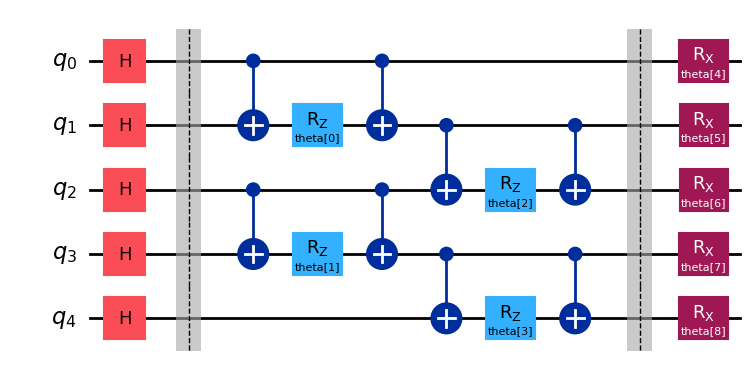

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

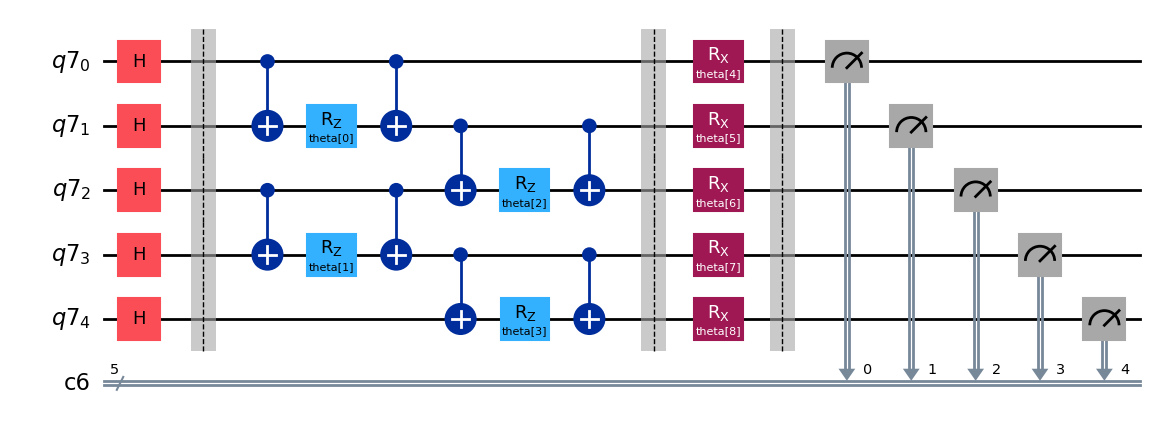

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

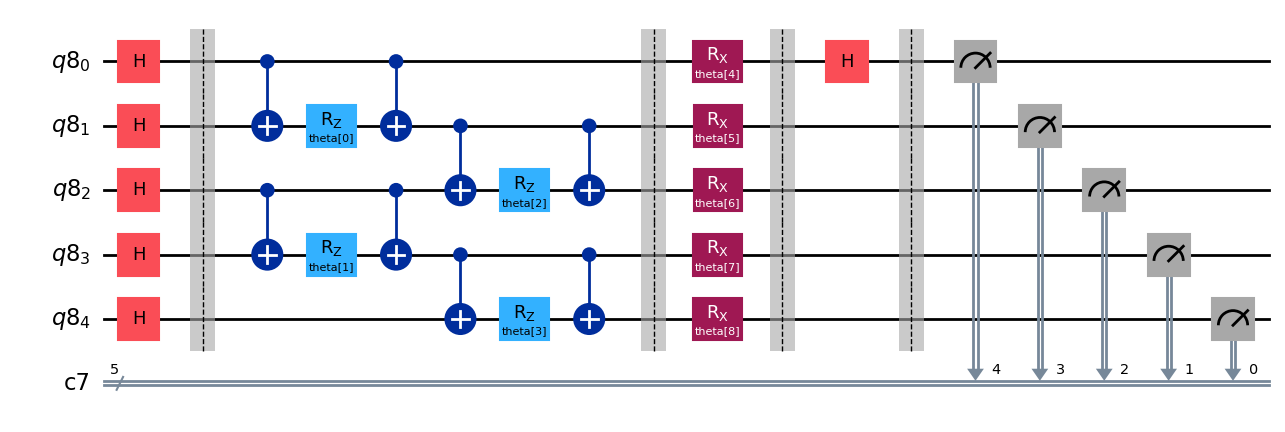

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

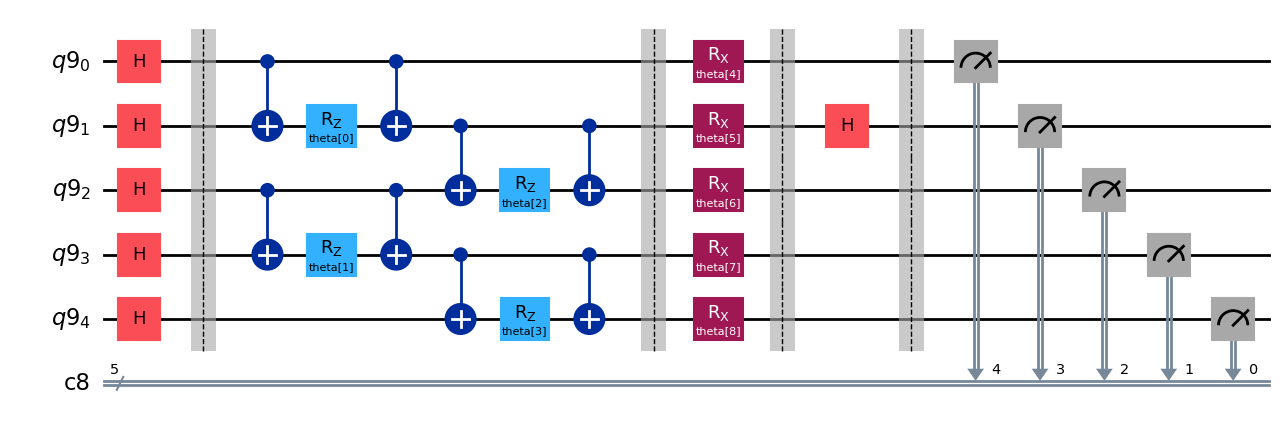

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

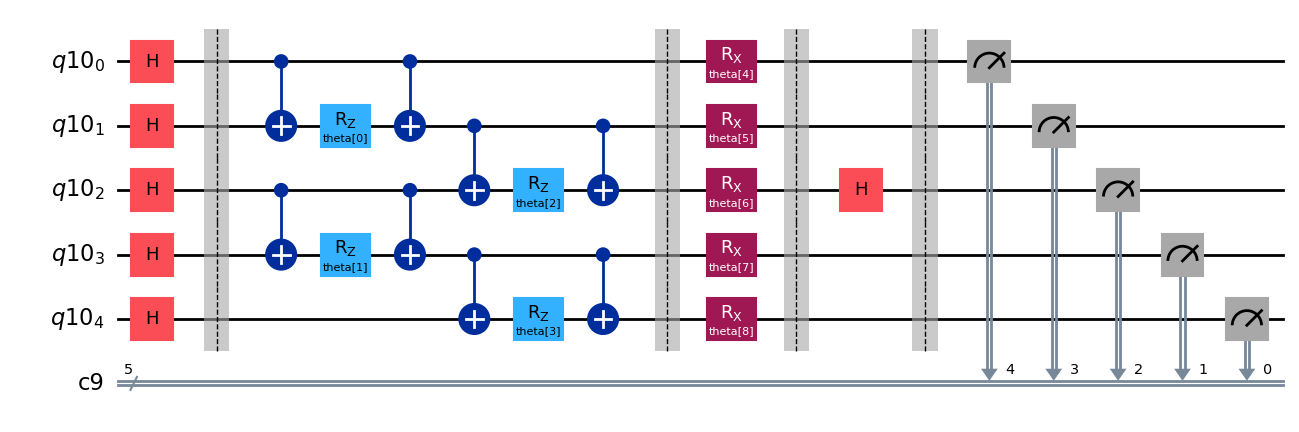

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

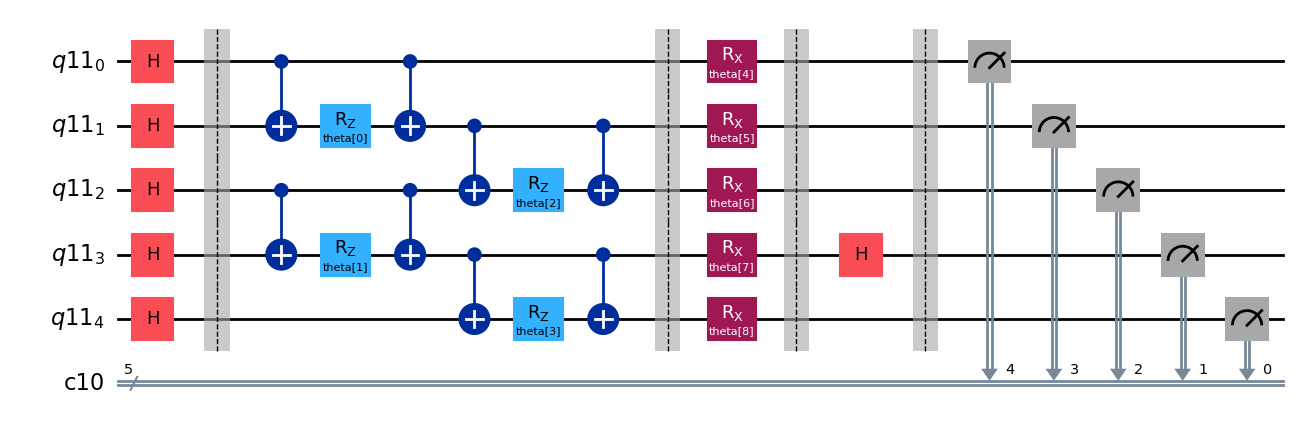

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

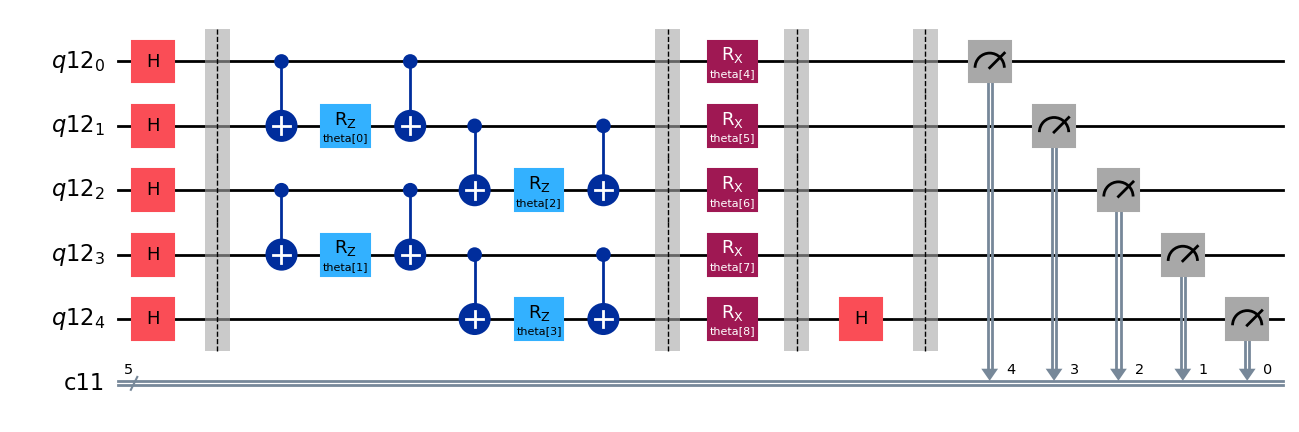

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn2(vec, x):
  a = vec[0]
  b = vec[1]

  lst = []
  lst.append(b*x[0])
  lst.append(a*x[0]+b*x[1])
  lst.append(a*x[1]+b*x[2])
  lst.append(a*x[2]+b*x[3])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(c*x[0])
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn4(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]

  lst = []
  lst.append(d*x[0])
  lst.append(c*x[0]+d*x[1])
  lst.append(b*x[0]+c*x[1]+d*x[2])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn2(parameter[0:2], x), cnn2(parameter[2:4], x), cnn3(parameter[4:7], x), cnn3(parameter[7:10], x), cnn4(parameter[10:14], x), cnn4(parameter[14:18], x)])
  z1 = relu(a1)

  FC1 = parameter[18:48]
  FC2 = parameter[48:53]
  c = parameter[53]

  FC1 = FC1.reshape(5,6)
  FC2 = FC2.reshape(1,5)


  a2 = np.matmul(FC1, z1)
  z2 = relu(a2)

  a3 = np.matmul(FC2, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=54), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=54), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=54), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=54), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(54) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.903948
         Iterations: 60
         Function evaluations: 9031
         Gradient evaluations: 164


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.897615
         Iterations: 41
         Function evaluations: 6721
         Gradient evaluations: 122
Optimization terminated successfully.
         Current function value: -5.902854
         Iterations: 78
         Function evaluations: 9240
         Gradient evaluations: 168
Optimization terminated successfully.
         Current function value: -5.864111
         Iterations: 63
         Function evaluations: 4400
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: -5.921569
         Iterations: 78
         Function evaluations: 6875
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: -5.860597
         Iterations: 39
         Function evaluations: 2640
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900397
         Iterations: 57
         Function evaluations: 6055
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: -5.900608
         Iterations: 100
         Function evaluations: 9295
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: -5.895773
         Iterations: 23
         Function evaluations: 1430
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -5.901901
         Iterations: 42
         Function evaluations: 2420
         Gradient evaluations: 44
error rate : 0.0, lowest energy vqnhe : -5.9215692209688084



error rate : 0.001, lowest energy vqe : -5.8191999999999995

Optimization terminated successfully.
         Current function value: -5.872847
         Iterations: 43
         Function evaluations: 2585
         Gradient evaluations: 47
Optimization terminated successfully

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.842839
         Iterations: 4
         Function evaluations: 2976
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: -5.821059
         Iterations: 18
         Function evaluations: 1265
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.874404
         Iterations: 36
         Function evaluations: 6991
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: -5.874866
         Iterations: 92
         Function evaluations: 7260
         Gradient evaluations: 132


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.871604
         Iterations: 28
         Function evaluations: 5287
         Gradient evaluations: 96
error rate : 0.001, lowest energy vqnhe : -5.9051113716317625



error rate : 0.002, lowest energy vqe : -5.775000000000001

Optimization terminated successfully.
         Current function value: -5.776677
         Iterations: 18
         Function evaluations: 1100
         Gradient evaluations: 20


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.849878
         Iterations: 54
         Function evaluations: 7987
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.869496
         Iterations: 168
         Function evaluations: 16731
         Gradient evaluations: 304
Optimization terminated successfully.
         Current function value: -5.882039
         Iterations: 162
         Function evaluations: 12485
         Gradient evaluations: 227
Optimization terminated successfully.
         Current function value: -5.812554
         Iterations: 38
         Function evaluations: 2695
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: -5.859794
         Iterations: 36
         Function evaluations: 2200
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: -5.810124
         Iterations: 9
         Function evaluations: 990
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -5.860276
         Iterations: 59
         Function evaluations: 4015
         Gradient 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.886623
         Iterations: 30
         Function evaluations: 6392
         Gradient evaluations: 116
Optimization terminated successfully.
         Current function value: -5.881305
         Iterations: 71
         Function evaluations: 5225
         Gradient evaluations: 95
Optimization terminated successfully.
         Current function value: -5.815053
         Iterations: 41
         Function evaluations: 2860
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: -5.782000
         Iterations: 0
         Function evaluations: 55
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: -5.832017
         Iterations: 34
         Function evaluations: 2145
         Gradient evaluations: 39
error rate : 0.003, lowest energy vqnhe : -5.88662268294751



error rate : 0.004, lowest energy vqe : -5.7467999999999995



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.824758
         Iterations: 51
         Function evaluations: 8206
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.771251
         Iterations: 37
         Function evaluations: 4135
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: -5.823477
         Iterations: 10
         Function evaluations: 1155
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -5.768789
         Iterations: 15
         Function evaluations: 1210
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -5.829257
         Iterations: 77
         Function evaluations: 9240
         Gradient evaluations: 168
Optimization terminated successfully.
         Current function value: -5.764788
         Iterations: 3
         Function evaluations: 330
         Gradient evaluations: 6


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.839374
         Iterations: 114
         Function evaluations: 13321
         Gradient evaluations: 242
Optimization terminated successfully.
         Current function value: -5.776580
         Iterations: 21
         Function evaluations: 1430
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -5.794593
         Iterations: 38
         Function evaluations: 6270
         Gradient evaluations: 114


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.810364
         Iterations: 58
         Function evaluations: 7706
         Gradient evaluations: 140
error rate : 0.004, lowest energy vqnhe : -5.839374372609238



error rate : 0.005, lowest energy vqe : -5.742000000000001

Optimization terminated successfully.
         Current function value: -5.771971
         Iterations: 35
         Function evaluations: 4565
         Gradient evaluations: 83


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.823752
         Iterations: 142
         Function evaluations: 16182
         Gradient evaluations: 294
Optimization terminated successfully.
         Current function value: -5.823257
         Iterations: 65
         Function evaluations: 5060
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: -5.823945
         Iterations: 58
         Function evaluations: 3795
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: -5.836690
         Iterations: 37
         Function evaluations: 2530
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -5.824407
         Iterations: 296
         Function evaluations: 20955
         Gradient evaluations: 381
Optimization terminated successfully.
         Current function value: -5.742898
         Iterations: 9
         Function evaluations: 605
         Gradient 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.744221
         Iterations: 5
         Function evaluations: 3745
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: -5.742898
         Iterations: 27
         Function evaluations: 1595
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -5.772579
         Iterations: 26
         Function evaluations: 1650
         Gradient evaluations: 30
error rate : 0.005, lowest energy vqnhe : -5.836689658429629



error rate : 0.006, lowest energy vqe : -5.6944

Optimization terminated successfully.
         Current function value: -5.808364
         Iterations: 92
         Function evaluations: 6050
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: -5.752148
         Iterations: 21
         Function evaluations: 1760
         Gradient evaluations: 32


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.757709
         Iterations: 281
         Function evaluations: 23770
         Gradient evaluations: 432


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.743845
         Iterations: 67
         Function evaluations: 10069
         Gradient evaluations: 183
Optimization terminated successfully.
         Current function value: -5.695017
         Iterations: 25
         Function evaluations: 1430
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.735724
         Iterations: 16
         Function evaluations: 5178
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: -5.737654
         Iterations: 32
         Function evaluations: 2310
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -5.805710
         Iterations: 110
         Function evaluations: 12980
         Gradient evaluations: 236
Optimization terminated successfully.
         Current function value: -5.760383
         Iterations: 32
         Function evaluations: 2475
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: -5.808484
         Iterations: 25
         Function evaluations: 1650
         Gradient evaluations: 30
error rate : 0.006, lowest energy vqnhe : -5.808483999142415



error rate : 0.007, lowest energy vqe : -5.709399999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.828647
         Iterations: 35
         Function evaluations: 6440
         Gradient evaluations: 117
Optimization terminated successfully.
         Current function value: -5.756774
         Iterations: 32
         Function evaluations: 1980
         Gradient evaluations: 36


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.825133
         Iterations: 44
         Function evaluations: 6447
         Gradient evaluations: 117
Optimization terminated successfully.
         Current function value: -5.709408
         Iterations: 10
         Function evaluations: 660
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: -5.797708
         Iterations: 45
         Function evaluations: 2970
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: -5.764550
         Iterations: 54
         Function evaluations: 4015
         Gradient evaluations: 73
Optimization terminated successfully.
         Current function value: -5.774309
         Iterations: 39
         Function evaluations: 3025
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: -5.827833
         Iterations: 47
         Function evaluations: 2750
         Gradient eval

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.714425
         Iterations: 9
         Function evaluations: 4521
         Gradient evaluations: 82


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.738934
         Iterations: 19
         Function evaluations: 4742
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: -5.787440
         Iterations: 63
         Function evaluations: 4345
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: -5.775048
         Iterations: 20
         Function evaluations: 1320
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -5.741271
         Iterations: 53
         Function evaluations: 3300
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: -5.756113
         Iterations: 79
         Function evaluations: 5830
         Gradient evaluations: 106
error rate : 0.008, lowest energy vqnhe : -5.787439979698193



error rate : 0.009000000000000001, lowest energy vqe : -5.6546

Optimization terminated successful

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.695681
         Iterations: 134
         Function evaluations: 15190
         Gradient evaluations: 276
Optimization terminated successfully.
         Current function value: -5.654600
         Iterations: 1
         Function evaluations: 110
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.728248
         Iterations: 119
         Function evaluations: 13265
         Gradient evaluations: 241
Optimization terminated successfully.
         Current function value: -5.757376
         Iterations: 219
         Function evaluations: 17600
         Gradient evaluations: 320
Optimization terminated successfully.
         Current function value: -5.692339
         Iterations: 38
         Function evaluations: 2310
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -5.757147
         Iterations: 74
         Function evaluations: 7434
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.765175
         Iterations: 56
         Function evaluations: 7325
         Gradient evaluations: 133
Optimization terminated successfully.
         Current function value: -5.768134
         Iterations: 95
         Function evaluations: 9295
         Gradient evaluations: 169


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.686956
         Iterations: 24
         Function evaluations: 6442
         Gradient evaluations: 117
error rate : 0.009000000000000001, lowest energy vqnhe : -5.768134065885558



error rate : 0.01, lowest energy vqe : -5.6246

Optimization terminated successfully.
         Current function value: -5.673007
         Iterations: 23
         Function evaluations: 1705
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: -5.624600
         Iterations: 2
         Function evaluations: 220
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: -5.726225
         Iterations: 36
         Function evaluations: 2255
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: -5.624600
         Iterations: 0
         Function evaluations: 55
         Gradient evaluations: 1
Optimization terminated successfully.
    

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.705343
         Iterations: 132
         Function evaluations: 16122
         Gradient evaluations: 293
Optimization terminated successfully.
         Current function value: -5.727551
         Iterations: 54
         Function evaluations: 3520
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -5.727475
         Iterations: 55
         Function evaluations: 3905
         Gradient evaluations: 71
error rate : 0.01, lowest energy vqnhe : -5.727824786531487



error rate : 0.02, lowest energy vqe : -5.4496

Optimization terminated successfully.
         Current function value: -5.449792
         Iterations: 12
         Function evaluations: 880
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: -5.606434
         Iterations: 124
         Function evaluations: 13255
         Gradient evaluations: 241
Optimization terminated successfully.
         

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.519476
         Iterations: 42
         Function evaluations: 5016
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: -5.449793
         Iterations: 2
         Function evaluations: 275
         Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.600544
         Iterations: 82
         Function evaluations: 10952
         Gradient evaluations: 199
Optimization terminated successfully.
         Current function value: -5.613545
         Iterations: 65
         Function evaluations: 4730
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: -5.590128
         Iterations: 76
         Function evaluations: 4950
         Gradient evaluations: 90


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.527883
         Iterations: 61
         Function evaluations: 7427
         Gradient evaluations: 135
error rate : 0.02, lowest energy vqnhe : -5.613545399129404



error rate : 0.03, lowest energy vqe : -5.256800000000002

Optimization terminated successfully.
         Current function value: -5.458938
         Iterations: 17
         Function evaluations: 1100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -5.460875
         Iterations: 50
         Function evaluations: 3025
         Gradient evaluations: 55


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.455503
         Iterations: 84
         Function evaluations: 8916
         Gradient evaluations: 162
Optimization terminated successfully.
         Current function value: -5.460960
         Iterations: 31
         Function evaluations: 1760
         Gradient evaluations: 32


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.338670
         Iterations: 86
         Function evaluations: 10677
         Gradient evaluations: 194
Optimization terminated successfully.
         Current function value: -5.459033
         Iterations: 51
         Function evaluations: 3245
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: -5.317422
         Iterations: 19
         Function evaluations: 1100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -5.460801
         Iterations: 46
         Function evaluations: 3080
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -5.458955
         Iterations: 41
         Function evaluations: 2695
         Gradient evaluations: 49


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.333792
         Iterations: 66
         Function evaluations: 9305
         Gradient evaluations: 169
error rate : 0.03, lowest energy vqnhe : -5.460960445529198



error rate : 0.04, lowest energy vqe : -5.056400000000001

Optimization terminated successfully.
         Current function value: -5.309513
         Iterations: 97
         Function evaluations: 6655
         Gradient evaluations: 121
Optimization terminated successfully.
         Current function value: -5.124620
         Iterations: 14
         Function evaluations: 1540
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: -5.152873
         Iterations: 34
         Function evaluations: 4070
         Gradient evaluations: 74
Optimization terminated successfully.
         Current function value: -5.310324
         Iterations: 66
         Function evaluations: 4455
         Gradient evaluations: 81
Optimization terminated successfully.
 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.310528
         Iterations: 54
         Function evaluations: 11342
         Gradient evaluations: 206


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.146757
         Iterations: 24
         Function evaluations: 4906
         Gradient evaluations: 89
Optimization terminated successfully.
         Current function value: -5.124620
         Iterations: 14
         Function evaluations: 990
         Gradient evaluations: 18


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.318625
         Iterations: 149
         Function evaluations: 16727
         Gradient evaluations: 304
error rate : 0.04, lowest energy vqnhe : -5.318625460239696



error rate : 0.05, lowest energy vqe : -4.8721999999999985

Optimization terminated successfully.
         Current function value: -4.958665
         Iterations: 41
         Function evaluations: 8415
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.142257
         Iterations: 27
         Function evaluations: 6004
         Gradient evaluations: 109


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.874884
         Iterations: 26
         Function evaluations: 5339
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: -5.216971
         Iterations: 40
         Function evaluations: 2365
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.217420
         Iterations: 128
         Function evaluations: 14365
         Gradient evaluations: 261


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.971966
         Iterations: 15
         Function evaluations: 4357
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: -5.216595
         Iterations: 28
         Function evaluations: 1870
         Gradient evaluations: 34


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.208042
         Iterations: 103
         Function evaluations: 14807
         Gradient evaluations: 269
Optimization terminated successfully.
         Current function value: -5.135251
         Iterations: 19
         Function evaluations: 1595
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.044182
         Iterations: 38
         Function evaluations: 6330
         Gradient evaluations: 115
error rate : 0.05, lowest energy vqnhe : -5.2174201256509285



error rate : 0.06, lowest energy vqe : -4.706800000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.863231
         Iterations: 13
         Function evaluations: 3751
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: -4.929487
         Iterations: 24
         Function evaluations: 3410
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: -4.817217
         Iterations: 14
         Function evaluations: 990
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -4.882262
         Iterations: 45
         Function evaluations: 2915
         Gradient evaluations: 53


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.113364
         Iterations: 156
         Function evaluations: 12493
         Gradient evaluations: 227
Optimization terminated successfully.
         Current function value: -5.100524
         Iterations: 76
         Function evaluations: 6050
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: -5.046667
         Iterations: 38
         Function evaluations: 3135
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: -4.856975
         Iterations: 19
         Function evaluations: 1155
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.820294
         Iterations: 3
         Function evaluations: 6117
         Gradient evaluations: 111
Optimization terminated successfully.
         Current function value: -4.865660
         Iterations: 39
         Function evaluations: 2640
         Gradient evaluations: 48
error rate : 0.06, lowest energy vqnhe : -5.1133637963997245



error rate : 0.07, lowest energy vqe : -4.576600000000001

Optimization terminated successfully.
         Current function value: -4.956498
         Iterations: 24
         Function evaluations: 2090
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: -4.961433
         Iterations: 36
         Function evaluations: 2640
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: -4.965836
         Iterations: 20
         Function evaluations: 2585
         Gradient evaluations: 47
Optimization terminated successfully.
  

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.031851
         Iterations: 41
         Function evaluations: 7708
         Gradient evaluations: 140
Optimization terminated successfully.
         Current function value: -4.583802
         Iterations: 8
         Function evaluations: 660
         Gradient evaluations: 12


<ipython-input-46-4048d43bbc56>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-25-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-25-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-25-942dbc8389c9>:41: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-25-942dbc8389c9>:54: RuntimeWarning: invalid value encountered in scalar add
  expval = expval + prob_string[k]*nnval[k]
<ipython-input-46-4048d43bbc56>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-25-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-25-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in s

         Current function value: nan
         Iterations: 32
         Function evaluations: 8690
         Gradient evaluations: 158


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.013207
         Iterations: 56
         Function evaluations: 11617
         Gradient evaluations: 211


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.029072
         Iterations: 82
         Function evaluations: 9630
         Gradient evaluations: 175
error rate : 0.07, lowest energy vqnhe : -5.031851065964



error rate : 0.08, lowest energy vqe : -4.430999999999998

Optimization terminated successfully.
         Current function value: -4.981780
         Iterations: 139
         Function evaluations: 8855
         Gradient evaluations: 161
Optimization terminated successfully.
         Current function value: -4.967187
         Iterations: 25
         Function evaluations: 1540
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: -4.935037
         Iterations: 69
         Function evaluations: 6105
         Gradient evaluations: 111
Optimization terminated successfully.
         Current function value: -4.441542
         Iterations: 5
         Function evaluations: 385
         Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.973514
         Iterations: 76
         Function evaluations: 10792
         Gradient evaluations: 196
Optimization terminated successfully.
         Current function value: -4.607947
         Iterations: 44
         Function evaluations: 2805
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: -4.943426
         Iterations: 82
         Function evaluations: 7425
         Gradient evaluations: 135
Optimization terminated successfully.
         Current function value: -4.723343
         Iterations: 16
         Function evaluations: 1155
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -4.441542
         Iterations: 12
         Function evaluations: 770
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: -4.882211
         Iterations: 16
         Function evaluations: 1540
         Gradient ev

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.863445
         Iterations: 190
         Function evaluations: 17007
         Gradient evaluations: 309


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.491423
         Iterations: 58
         Function evaluations: 8977
         Gradient evaluations: 163
Optimization terminated successfully.
         Current function value: -4.843244
         Iterations: 61
         Function evaluations: 3795
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: -4.714009
         Iterations: 16
         Function evaluations: 1320
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -4.585880
         Iterations: 15
         Function evaluations: 1155
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -4.853432
         Iterations: 58
         Function evaluations: 3575
         Gradient evaluations: 65
error rate : 0.09, lowest energy vqnhe : -4.863445336486164



error rate : 0.1, lowest energy vqe : -4.114799999999999

Optimization terminated successfully.
   

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.751654
         Iterations: 69
         Function evaluations: 5830
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: -4.320494
         Iterations: 12
         Function evaluations: 990
         Gradient evaluations: 18


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.774759
         Iterations: 29
         Function evaluations: 6166
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.241151
         Iterations: 10
         Function evaluations: 6777
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: -4.755514
         Iterations: 60
         Function evaluations: 4950
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: -4.744186
         Iterations: 66
         Function evaluations: 4510
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: -4.751654
         Iterations: 99
         Function evaluations: 8030
         Gradient evaluations: 146
         Current function value: -4.739020
         Iterations: 74
         Function evaluations: 9411
         Gradient evaluations: 171
error rate : 0.1, lowest energy vqnhe : -4.774758869722714





/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
lowest_energy_vqnhe_list

[-5.9215692209688084,
 -5.9051113716317625,
 -5.882038846182267,
 -5.88662268294751,
 -5.839374372609238,
 -5.836689658429629,
 -5.808483999142415,
 -5.8287110002385445,
 -5.787439979698193,
 -5.768134065885558,
 -5.727824786531487,
 -5.613545399129404,
 -5.460960445529198,
 -5.318625460239696,
 -5.2174201256509285,
 -5.1133637963997245,
 -5.031851065964,
 -4.981779980345924,
 -4.863445336486164,
 -4.774758869722714]

# QEM Plot

## 1. Baseline

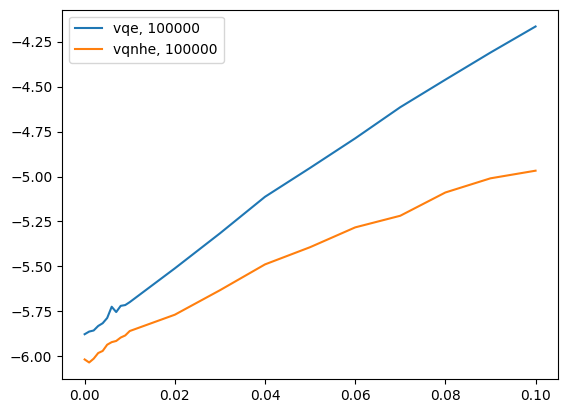

In [ ]:
import matplotlib.pyplot as plt

error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqe_100000 = [-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]
vqnhe_100000 = [-6.016802141557301, -6.033668811971606, -6.0126360379539046, -5.981320863910831, -5.969558737051838, -5.934874750042589, -5.920637462798409, -5.914035409603047, -5.895030747146389, -5.883510734777119, -5.8589093314138285, -5.768163382324187, -5.632185221427297, -5.488488523492795, -5.392835794187803, -5.282777008483308, -5.218086763971021, -5.088782119949112, -5.010089066676246, -4.967618445813056]


plt.plot(error_list, vqe_100000, label="vqe, 100000")
plt.plot(error_list, vqnhe_100000, label="vqnhe, 100000")
plt.legend()

In [ ]:
energy_gain = []
for i in range(20):
  energy_gain.append(vqe_100000[i]-vqnhe_100000[i])

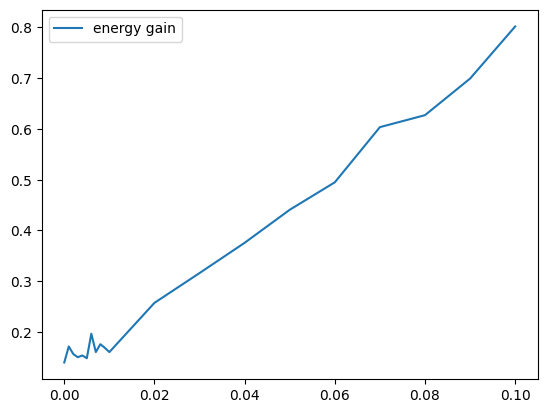

In [ ]:
plt.plot(error_list, energy_gain, label="energy gain")
plt.legend()

In [ ]:
energy_gain_ratio = []
for i in range(20):
  energy_gain_ratio.append((6.02+vqnhe_100000[i])/(6.02+vqe_100000[i]))

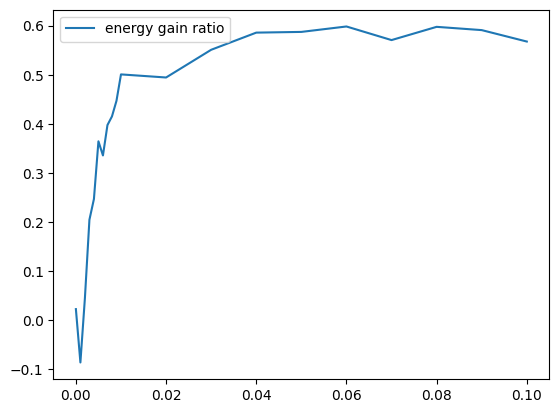

In [ ]:
plt.plot(error_list, energy_gain_ratio, label="energy gain ratio")
plt.legend()

## 2. Shot Error & Intrinsic Error Estimation

10000 vqe

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

30000 vqe

[-5.850666666666667,
 -5.859466666666668,
 -5.830133333333334,
 -5.813199999999999,
 -5.790866666666667,
 -5.7708,
 -5.707466666666669,
 -5.723466666666665,
 -5.702400000000001,
 -5.696933333333334,
 -5.672933333333334,
 -5.478666666666667,
 -5.291599999999998,
 -5.0936,
 -4.924399999999999,
 -4.759200000000001,
 -4.611600000000001,
 -4.456133333333334,
 -4.288799999999999,
 -4.136866666666666]

100000 vqe

[-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]

10000 vqnhe

[-6.014734786487967,
-5.989263505054438,
-6.010556311541972,
-5.959000805512114,
-5.90902994516003,
-5.986069017531553,
-5.918936707538753,
-5.922863905333515,
-5.858878301772931,
-5.842224777100799,
-5.812727748299529,
-5.6952421550762695,
-5.571245238356655,
-5.406581444990768,
-5.397470040254054,
-5.249472288545349,
-5.190127777349049,
-5.167980221092957,
-5.024392948082632,
-4.978463087318152]

30000 vqnhe

[-6.027142621912499,
 -6.033085899460828,
 -6.0629807162333575,
 -5.996240243862845,
 -5.97756913106401,
 -5.980228004516064,
 -5.893838089065045,
 -5.907310093612567,
 -5.877291883262352,
 -5.8991690833812,
 -5.875203193351284,
 -5.7852193058394406,
 -5.5876021166347805,
 -5.4853892479751885,
 -5.36817474367053,
 -5.404464520877687,
 -5.212678070406619,
 -5.128110236249247,
 -5.049706978350467,
 -5.1164011041185375]

100000 vqnhe

[-6.016802141557301, -6.033668811971606, -6.0126360379539046, -5.981320863910831, -5.969558737051838, -5.934874750042589, -5.920637462798409, -5.914035409603047, -5.895030747146389, -5.883510734777119, -5.8589093314138285, -5.768163382324187, -5.632185221427297, -5.488488523492795, -5.392835794187803, -5.282777008483308, -5.218086763971021, -5.088782119949112, -5.010089066676246, -4.967618445813056]

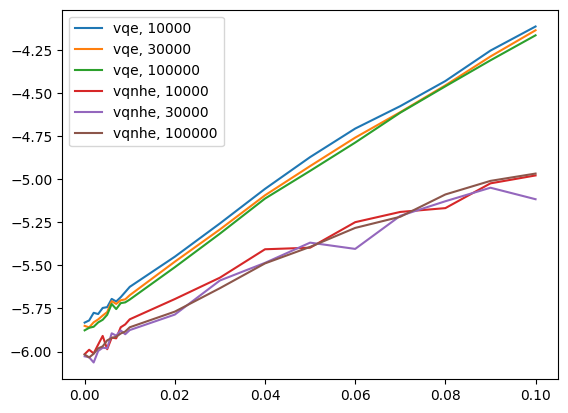

In [ ]:
import matplotlib.pyplot as plt

error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqe_10000 = [-5.831799999999999, -5.8191999999999995, -5.775000000000001, -5.782000000000001, -5.7467999999999995, -5.742000000000001, -5.6944, -5.709399999999999, -5.684400000000002, -5.6546, -5.6246, -5.4496, -5.256800000000002, -5.056400000000001, -4.8721999999999985, -4.706800000000002, -4.576600000000001, -4.430999999999998, -4.254599999999999, -4.114799999999999]
vqe_30000 = [-5.850666666666667, -5.859466666666668, -5.830133333333334, -5.813199999999999, -5.790866666666667, -5.7708, -5.707466666666669, -5.723466666666665, -5.702400000000001, -5.696933333333334, -5.672933333333334, -5.478666666666667, -5.291599999999998, -5.0936, -4.924399999999999, -4.759200000000001, -4.611600000000001, -4.456133333333334, -4.288799999999999, -4.136866666666666]
vqe_100000 = [-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]

vqnhe_10000 = [-6.014734786487967, -5.989263505054438, -6.010556311541972, -5.959000805512114, -5.90902994516003, -5.986069017531553, -5.918936707538753, -5.922863905333515, -5.858878301772931, -5.842224777100799, -5.812727748299529, -5.6952421550762695, -5.571245238356655, -5.406581444990768, -5.397470040254054, -5.249472288545349, -5.190127777349049, -5.167980221092957, -5.024392948082632, -4.978463087318152]
vqnhe_30000 = [-6.027142621912499, -6.033085899460828, -6.0629807162333575, -5.996240243862845, -5.97756913106401, -5.980228004516064, -5.893838089065045, -5.907310093612567, -5.877291883262352, -5.8991690833812, -5.875203193351284, -5.7852193058394406, -5.5876021166347805, -5.4853892479751885, -5.36817474367053, -5.404464520877687, -5.212678070406619, -5.128110236249247, -5.049706978350467, -5.1164011041185375]
vqnhe_100000 = [-6.016802141557301, -6.033668811971606, -6.0126360379539046, -5.981320863910831, -5.969558737051838, -5.934874750042589, -5.920637462798409, -5.914035409603047, -5.895030747146389, -5.883510734777119, -5.8589093314138285, -5.768163382324187, -5.632185221427297, -5.488488523492795, -5.392835794187803, -5.282777008483308, -5.218086763971021, -5.088782119949112, -5.010089066676246, -4.967618445813056]


plt.plot(error_list, vqe_10000, label="vqe, 10000")
plt.plot(error_list, vqe_30000, label="vqe, 30000")
plt.plot(error_list, vqe_100000, label="vqe, 100000")
plt.plot(error_list, vqnhe_10000, label="vqnhe, 10000")
plt.plot(error_list, vqnhe_30000, label="vqnhe, 30000")
plt.plot(error_list, vqnhe_100000, label="vqnhe, 100000")
plt.legend()

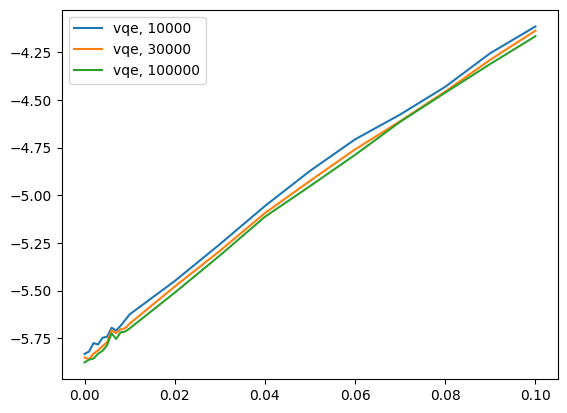

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqe_10000 = [-5.831799999999999, -5.8191999999999995, -5.775000000000001, -5.782000000000001, -5.7467999999999995, -5.742000000000001, -5.6944, -5.709399999999999, -5.684400000000002, -5.6546, -5.6246, -5.4496, -5.256800000000002, -5.056400000000001, -4.8721999999999985, -4.706800000000002, -4.576600000000001, -4.430999999999998, -4.254599999999999, -4.114799999999999]
vqe_30000 = [-5.850666666666667, -5.859466666666668, -5.830133333333334, -5.813199999999999, -5.790866666666667, -5.7708, -5.707466666666669, -5.723466666666665, -5.702400000000001, -5.696933333333334, -5.672933333333334, -5.478666666666667, -5.291599999999998, -5.0936, -4.924399999999999, -4.759200000000001, -4.611600000000001, -4.456133333333334, -4.288799999999999, -4.136866666666666]
vqe_100000 = [-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]


plt.plot(error_list, vqe_10000, label="vqe, 10000")
plt.plot(error_list, vqe_30000, label="vqe, 30000")
plt.plot(error_list, vqe_100000, label="vqe, 100000")
plt.legend()

In [ ]:
vqe_delt_10000_30000 = []
for i in range(20):
  vqe_delt_10000_30000.append(vqe_10000[i]-vqe_30000[i])


vqe_delt_30000_100000 = []
for i in range(20):
  vqe_delt_30000_100000.append(vqe_30000[i]-vqe_100000[i])

0.03058000000000023

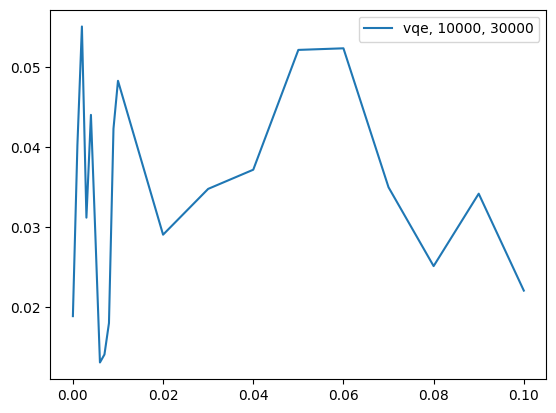

In [ ]:
plt.plot(error_list, vqe_delt_10000_30000, label="vqe, 10000, 30000")
plt.legend()

0.019228000000000023

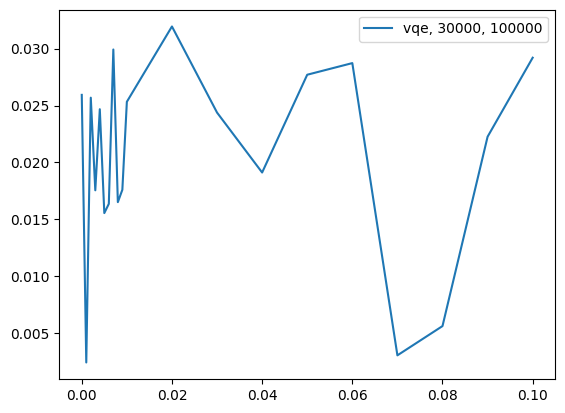

In [ ]:
plt.plot(error_list, vqe_delt_30000_100000, label="vqe, 30000, 100000")
plt.legend()

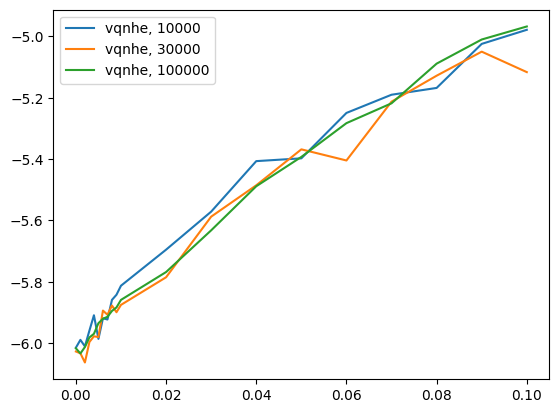

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqnhe_10000 = [-6.014734786487967, -5.989263505054438, -6.010556311541972, -5.959000805512114, -5.90902994516003, -5.986069017531553, -5.918936707538753, -5.922863905333515, -5.858878301772931, -5.842224777100799, -5.812727748299529, -5.6952421550762695, -5.571245238356655, -5.406581444990768, -5.397470040254054, -5.249472288545349, -5.190127777349049, -5.167980221092957, -5.024392948082632, -4.978463087318152]
vqnhe_30000 = [-6.027142621912499, -6.033085899460828, -6.0629807162333575, -5.996240243862845, -5.97756913106401, -5.980228004516064, -5.893838089065045, -5.907310093612567, -5.877291883262352, -5.8991690833812, -5.875203193351284, -5.7852193058394406, -5.5876021166347805, -5.4853892479751885, -5.36817474367053, -5.404464520877687, -5.212678070406619, -5.128110236249247, -5.049706978350467, -5.1164011041185375]
vqnhe_100000 = [-6.016802141557301, -6.033668811971606, -6.0126360379539046, -5.981320863910831, -5.969558737051838, -5.934874750042589, -5.920637462798409, -5.914035409603047, -5.895030747146389, -5.883510734777119, -5.8589093314138285, -5.768163382324187, -5.632185221427297, -5.488488523492795, -5.392835794187803, -5.282777008483308, -5.218086763971021, -5.088782119949112, -5.010089066676246, -4.967618445813056]


plt.plot(error_list, vqnhe_10000, label="vqnhe, 10000")
plt.plot(error_list, vqnhe_30000, label="vqnhe, 30000")
plt.plot(error_list, vqnhe_100000, label="vqnhe, 100000")
plt.legend()

## 3. Error Type Estimation

vqe depolarization

[-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]

vqe bit flip

[-5.876600000000001,
 -5.878239999999999,
 -5.87098,
 -5.860439999999999,
 -5.8485000000000005,
 -5.8170600000000015,
 -5.824020000000002,
 -5.820760000000001,
 -5.8051200000000005,
 -5.798660000000001,
 -5.77824,
 -5.684420000000001,
 -5.59114,
 -5.51376,
 -5.46274,
 -5.3962200000000005,
 -5.35034,
 -5.310279999999999,
 -5.273199999999999,
 -5.24208]

vqe bit flip 300000

[-5.878866666666666,
 -5.88234,
 -5.870326666666667,
 -5.845793333333334,
 -5.85292,
 -5.82512,
 -5.826173333333334,
 -5.8130533333333325,
 -5.802933333333334,
 -5.796166666666666,
 -5.778326666666667,
 -5.683786666666665,
 -5.605160000000001,
 -5.52334,
 -5.465386666666667,
 -5.410873333333334,
 -5.357606666666667,
 -5.3163133333333334,
 -5.281346666666668,
 -5.249626666666665]

vqe amplitude damping

[-5.876600000000001,
 -5.86932,
 -5.86418,
 -5.845739999999998,
 -5.833380000000001,
 -5.807200000000001,
 -5.75984,
 -5.778060000000001,
 -5.780600000000001,
 -5.76292,
 -5.74794,
 -5.5960600000000005,
 -5.459139999999999,
 -5.32774,
 -5.209740000000001,
 -5.126619999999998,
 -4.999879999999998,
 -4.930679999999999,
 -4.82584,
 -4.778400000000002]

vqnhe depolarization

[-6.016802141557301, -6.033668811971606, -6.0126360379539046, -5.981320863910831, -5.969558737051838, -5.934874750042589, -5.920637462798409, -5.914035409603047, -5.895030747146389, -5.883510734777119, -5.8589093314138285, -5.768163382324187, -5.632185221427297, -5.488488523492795, -5.392835794187803, -5.282777008483308, -5.218086763971021, -5.088782119949112, -5.010089066676246, -4.967618445813056]

vqnhe bit flip

[-6.019126621218642,
 -6.0213940058525806,
 -6.015603515043843,
 -6.017359142120439,
 -6.001245818368271,
 -5.988176273738773,
 -5.984089709709089,
 -5.99685397380326,
 -5.977711074345531,
 -5.979120673588977,
 -5.981785982746555,
 -5.989969989284615,
 -6.006848070735053,
 -6.047315282989249,
 -6.0389465575756605,
 -6.057383003790219,
 -6.122890294493822,
 -6.152843872985519,
 -6.152944447387124,
 -6.0771270946929965]

vqnhe bit flip 300000

[-6.025021312458688,
 -6.015350983691933,
 -6.007255853900264,
 -5.996503227549253,
 -5.998975507077523,
 -5.976813418501752,
 -5.973612423965412,
 -5.974840188338734,
 -5.975350470115557,
 -5.974169923874703,
 -5.966364228283026,
 -6.002771071909867,
 -5.987770116045599,
 -6.047998040591936,
 -6.07229118966561,
 -6.136876268589979,
 -6.09469194865808,
 -6.101549423383564,
 -6.08726736731536,
 -6.077200754652118]

vqnhe amplitude damping

[-6.019126621218642,
 -6.0283519164325545,
 -6.011816319158316,
 -5.9983179162393405,
 -6.010080559785847,
 -5.969197110288706,
 -5.9481557135184095,
 -5.966122700142703,
 -5.962386453153363,
 -5.9422808211564675,
 -5.930479088796998,
 -5.812324595702446,
 -6.017348913317574,
 -5.6504068609001,
 -5.653597792429411,
 -5.629358854232405,
 -5.568359517254488,
 -5.492627788939561,
 -5.567734,
 -5.370707]

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqe_depolar = [-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]
vqe_bit_100000 = [-5.876600000000001, -5.878239999999999, -5.87098, -5.860439999999999, -5.8485000000000005, -5.8170600000000015, -5.824020000000002, -5.820760000000001, -5.8051200000000005, -5.798660000000001, -5.77824, -5.684420000000001, -5.59114, -5.51376, -5.46274, -5.3962200000000005, -5.35034, -5.310279999999999, -5.273199999999999, -5.24208]
vqe_bit_300000 = [-5.878866666666666, -5.88234, -5.870326666666667, -5.845793333333334, -5.85292, -5.82512, -5.826173333333334, -5.8130533333333325, -5.802933333333334, -5.796166666666666, -5.778326666666667, -5.683786666666665, -5.605160000000001, -5.52334, -5.465386666666667, -5.410873333333334, -5.357606666666667, -5.3163133333333334, -5.281346666666668, -5.249626666666665]
vqe_ampdamp = [-5.876600000000001, -5.86932, -5.86418, -5.845739999999998, -5.833380000000001, -5.807200000000001, -5.75984, -5.778060000000001, -5.780600000000001, -5.76292, -5.74794, -5.5960600000000005, -5.459139999999999, -5.32774, -5.209740000000001, -5.126619999999998, -4.999879999999998, -4.930679999999999, -4.82584, -4.778400000000002]


vqnhe_depolar = [-6.016802141557301, -6.033668811971606, -6.0126360379539046, -5.981320863910831, -5.969558737051838, -5.934874750042589, -5.920637462798409, -5.914035409603047, -5.895030747146389, -5.883510734777119, -5.8589093314138285, -5.768163382324187, -5.632185221427297, -5.488488523492795, -5.392835794187803, -5.282777008483308, -5.218086763971021, -5.088782119949112, -5.010089066676246, -4.967618445813056]
vqnhe_bit_100000 = [-6.019126621218642, -6.0213940058525806, -6.015603515043843, -6.017359142120439, -6.001245818368271, -5.988176273738773, -5.984089709709089, -5.99685397380326, -5.977711074345531, -5.979120673588977, -5.981785982746555, -5.989969989284615, -6.006848070735053, -6.047315282989249, -6.0389465575756605, -6.057383003790219, -6.122890294493822, -6.152843872985519, -6.152944447387124, -6.0771270946929965]
vqnhe_bit_300000 = [-6.025021312458688, -6.015350983691933, -6.007255853900264, -5.996503227549253, -5.998975507077523, -5.976813418501752, -5.973612423965412, -5.974840188338734, -5.975350470115557, -5.974169923874703, -5.966364228283026, -6.002771071909867, -5.987770116045599, -6.047998040591936, -6.07229118966561, -6.136876268589979, -6.09469194865808, -6.101549423383564, -6.08726736731536, -6.077200754652118]
vqnhe_ampdamp = [-6.019126621218642, -6.0283519164325545, -6.011816319158316, -5.9983179162393405, -6.010080559785847, -5.969197110288706, -5.9481557135184095, -5.966122700142703, -5.962386453153363, -5.9422808211564675, -5.930479088796998, -5.812324595702446, -6.017348913317574, -5.6504068609001, -5.653597792429411, -5.629358854232405, -5.568359517254488, -5.492627788939561, -5.567734, -5.370707]


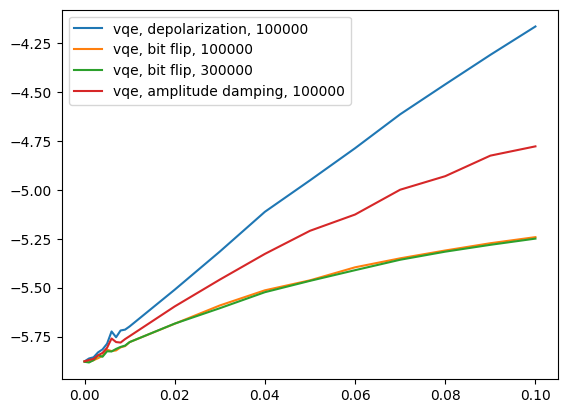

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqe_depolar = [-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]
vqe_bit_100000 = [-5.876600000000001, -5.878239999999999, -5.87098, -5.860439999999999, -5.8485000000000005, -5.8170600000000015, -5.824020000000002, -5.820760000000001, -5.8051200000000005, -5.798660000000001, -5.77824, -5.684420000000001, -5.59114, -5.51376, -5.46274, -5.3962200000000005, -5.35034, -5.310279999999999, -5.273199999999999, -5.24208]
vqe_bit_300000 = [-5.878866666666666, -5.88234, -5.870326666666667, -5.845793333333334, -5.85292, -5.82512, -5.826173333333334, -5.8130533333333325, -5.802933333333334, -5.796166666666666, -5.778326666666667, -5.683786666666665, -5.605160000000001, -5.52334, -5.465386666666667, -5.410873333333334, -5.357606666666667, -5.3163133333333334, -5.281346666666668, -5.249626666666665]
vqe_ampdamp = [-5.876600000000001, -5.86932, -5.86418, -5.845739999999998, -5.833380000000001, -5.807200000000001, -5.75984, -5.778060000000001, -5.780600000000001, -5.76292, -5.74794, -5.5960600000000005, -5.459139999999999, -5.32774, -5.209740000000001, -5.126619999999998, -4.999879999999998, -4.930679999999999, -4.82584, -4.778400000000002]


plt.plot(error_list, vqe_depolar, label="vqe, depolarization, 100000")
plt.plot(error_list, vqe_bit_100000, label="vqe, bit flip, 100000")
plt.plot(error_list, vqe_bit_300000, label="vqe, bit flip, 300000")
plt.plot(error_list, vqe_ampdamp, label="vqe, amplitude damping, 100000")
plt.legend()

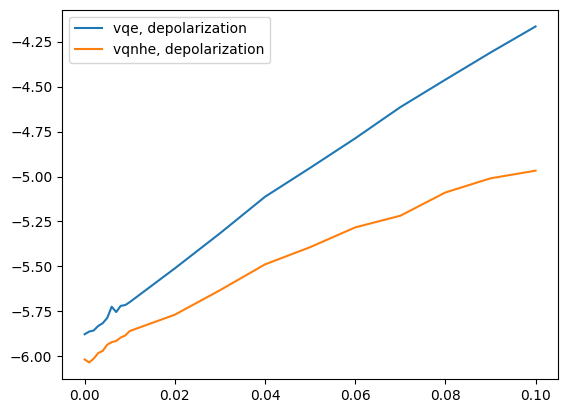

In [ ]:
plt.plot(error_list, vqe_depolar, label="vqe, depolarization")
plt.plot(error_list, vqnhe_depolar, label="vqnhe, depolarization")

plt.legend()

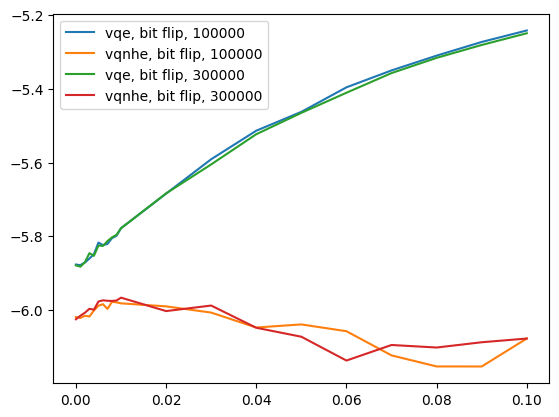

In [ ]:
plt.plot(error_list, vqe_bit_100000, label="vqe, bit flip, 100000")
plt.plot(error_list, vqnhe_bit_100000, label="vqnhe, bit flip, 100000")
plt.plot(error_list, vqe_bit_300000, label="vqe, bit flip, 300000")
plt.plot(error_list, vqnhe_bit_300000, label="vqnhe, bit flip, 300000")

plt.legend()

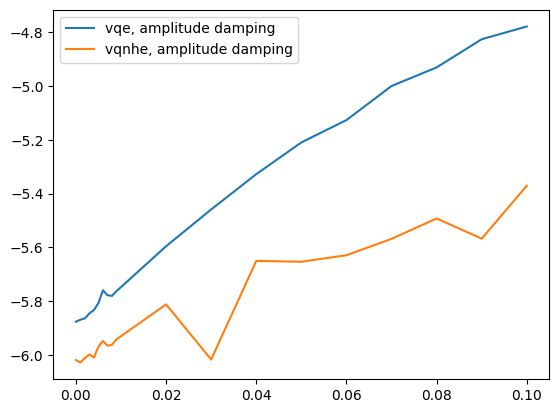

In [ ]:
plt.plot(error_list, vqe_ampdamp, label="vqe, amplitude damping")
plt.plot(error_list, vqnhe_ampdamp, label="vqnhe, amplitude damping")

plt.legend()

## 4. FC Hidden Layer Estimation

vqe

[-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]

vqnhe 1

[-6.016802141557301, -6.033668811971606, -6.0126360379539046, -5.981320863910831, -5.969558737051838, -5.934874750042589, -5.920637462798409, -5.914035409603047, -5.895030747146389, -5.883510734777119, -5.8589093314138285, -5.768163382324187, -5.632185221427297, -5.488488523492795, -5.392835794187803, -5.282777008483308, -5.218086763971021, -5.088782119949112, -5.010089066676246, -4.967618445813056]

vqnhe 2

[-6.0189520440435835,
-6.033933976459512,
-6.015939855858921,
-5.981398538394226,
-5.971035006177397,
-5.937147888028424,
-5.921916205729822,
-5.915723425109382,
-5.896390190020607,
-5.884099549362669,
-5.858966473582975,
-5.768171830036203,
 -5.632245711882939,
 -5.488642324996632,
 -5.393136248291399,
 -5.282811913275707,
 -5.218354733066544,
 -5.089269,
 -5.012300,
 -4.968633]

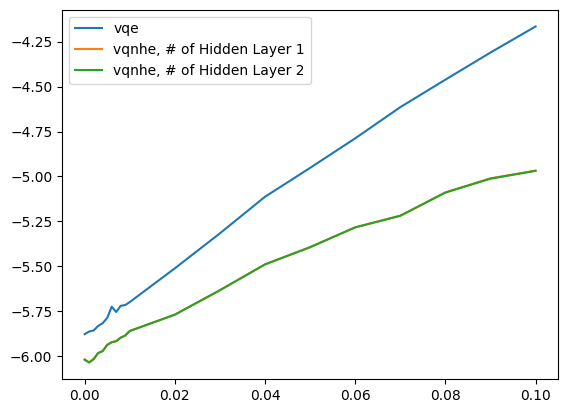

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqe = [-5.876600000000001, -5.8619200000000005, -5.855820000000001, -5.830759999999999, -5.81554, -5.786360000000001, -5.723840000000001, -5.75338, -5.71892, -5.714540000000001, -5.69826, -5.5106, -5.3159800000000015, -5.112719999999999, -4.9521, -4.78792, -4.614680000000001, -4.461779999999999, -4.3110599999999994, -4.16606]
vqnhe_1 = [-6.016802141557301, -6.033668811971606, -6.0126360379539046, -5.981320863910831, -5.969558737051838, -5.934874750042589, -5.920637462798409, -5.914035409603047, -5.895030747146389, -5.883510734777119, -5.8589093314138285, -5.768163382324187, -5.632185221427297, -5.488488523492795, -5.392835794187803, -5.282777008483308, -5.218086763971021, -5.088782119949112, -5.010089066676246, -4.967618445813056]
vqnhe_2 = [-6.0189520440435835, -6.033933976459512, -6.015939855858921, -5.981398538394226, -5.971035006177397, -5.937147888028424, -5.921916205729822, -5.915723425109382, -5.896390190020607, -5.884099549362669, -5.858966473582975, -5.768171830036203, -5.632245711882939, -5.488642324996632, -5.393136248291399, -5.282811913275707, -5.218354733066544, -5.089269, -5.012300, -4.968633]

plt.plot(error_list, vqe, label="vqe")
plt.plot(error_list, vqnhe_1, label="vqnhe, # of Hidden Layer 1")
plt.plot(error_list, vqnhe_2, label="vqnhe, # of Hidden Layer 2")
plt.legend()

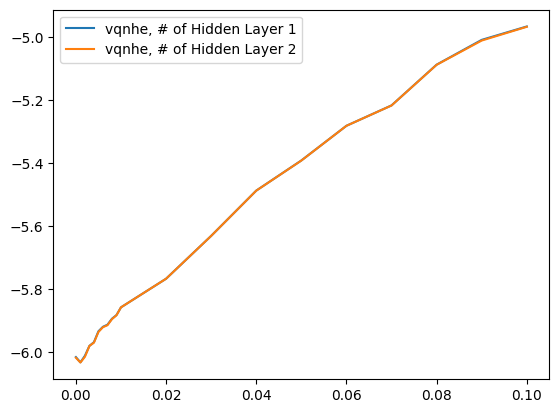

In [ ]:
plt.plot(error_list, vqnhe_1, label="vqnhe, # of Hidden Layer 1")
plt.plot(error_list, vqnhe_2, label="vqnhe, # of Hidden Layer 2")
plt.legend()